Import relevant packages and libraries


In [ ]:
# Import packages
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
%pip install pmdarima --quiet
import pmdarima as pm

Import Dataset and Clean Data

In [ ]:
# import dataset
data = pd.read_csv("../shelter_neighbourhood_features_pca.csv")

In [ ]:
### CLEAN DATA ###

# # extract Toronto only shelters:
data = data[data["LOCATION_CITY"] == "Toronto"]

# # drop columns that are not useful
data = data.drop(columns=["_id",
                          "ORGANIZATION_ID", 
                          "ORGANIZATION_NAME", 
                          "SHELTER_ID", 
                          "SHELTER_GROUP", 
                          "LOCATION_ID", 
                          "LOCATION_ADDRESS", 
                          "LOCATION_POSTAL_CODE", 
                          "LOCATION_CITY", 
                          "LOCATION_PROVINCE", 
                          "PROGRAM_ID", 
                          "PROGRAM_NAME", 
                          "SECTOR", 
                          "PROGRAM_MODEL",
                          "OVERNIGHT_SERVICE_TYPE", 
                          "PROGRAM_AREA",
                          "OVERNIGHT_SERVICE_TYPE",
                          "CAPACITY_TYPE",
                          "CAPACITY_ACTUAL_BED",
                          "CAPACITY_FUNDING_BED",
                          "OCCUPIED_BEDS",
                          "UNOCCUPIED_BEDS",
                          "UNAVAILABLE_BEDS",
                          "CAPACITY_ACTUAL_ROOM",
                          "CAPACITY_FUNDING_ROOM",
                          "OCCUPIED_ROOMS",
                          "UNOCCUPIED_ROOMS",
                          "UNAVAILABLE_ROOMS",
                          "OCCUPANCY_RATE_BEDS",
                          "OCCUPANCY_RATE_ROOMS", 
                          "LAT",
                          "LON",
                          "Neighbourhood Number"])



In [ ]:
# set the OCCUPANCY DATE as index
data = data.set_index(["OCCUPANCY_DATE"])

# convert to OCCUPANCY DATE to datetime format
data.index = pd.to_datetime(data.index)
# data = data.set_index(["OCCUPANCY_DATE"])

# aggregate the service user count
data1= data.groupby(["Neighbourhood", data.index]).agg({'SERVICE_USER_COUNT': 'sum'}).reset_index()

Separate into training data and testing data


In [ ]:
# data_exo  - the exogenous variables
data_exo = data.drop(columns=["LOCATION_NAME",
                          "SERVICE_USER_COUNT"])

In [ ]:
# add in the pca variables 
data1_exo = pd.merge(data1, data_exo, on=['OCCUPANCY_DATE', 'Neighbourhood'], how='left')
data1_exo = data1_exo.drop_duplicates()

In [ ]:
# set index as date-time
data1_exo = data1_exo.set_index(["OCCUPANCY_DATE"])

In [ ]:
# extract training data
train1 = data1_exo[data1_exo.index < pd.to_datetime('2023-01-01')]
test1 = data1_exo[data1_exo.index >= pd.to_datetime('2023-01-01')]

FUNCTIONS

In [ ]:
# Subset Neighbourhood specific data from each of data, test data and train data.
# PARAMETERS: 
#   data - all time series data
#   test - data to be used to test the model
#   train - the training data
#   neighbourhood - the neighbourhood to subset

def subsetNeighbourhood(data, test, train, neighbourhood):
    data = data
    neighbourhood = neighbourhood
    test = test
    train = train

    dataN = data[data["Neighbourhood"] == neighbourhood]
    testN = test[test["Neighbourhood"] == neighbourhood]
    trainN = train[train["Neighbourhood"] == neighbourhood]

    return dataN, testN, trainN

In [1]:
# Plot the timeseries data

def plotData(data, testN, trainN):

    # plot all  
    plt.figure(figsize=(15,7))
    plt.title("Plot of service user counts")
    plt.xlabel('Date')
    plt.ylabel('Service user count')
    plt.plot(dataN["SERVICE_USER_COUNT"])
    plt.plot()
    plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
    plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
    plt.show()

In [2]:
# Train the timeseries model on the training data
# Parameters:
#   trainN - the training time series data

def timeseriesModel(trainN):
    SARIMAX_model = pm.auto_arima(trainN[['SERVICE_USER_COUNT']], 
                                exogenous=trainN.iloc[:, 2:],
                                start_p=1, start_q=1,
                                test='adf',
                                max_p=3, max_q=3, 
                                m=7,  # seasonality of 7 day cycle
                                start_P=0, 
                                seasonal=True,
                                stationary = True,  # try to make data stationary
                                d=None, D=1, 
                                trace=False,   
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True,
                                maxiter = 50,
                                n_jobs=-1,
                                scoring="mse")
    
    print(SARIMAX_model)
    return SARIMAX_model

In [ ]:
# Plot the time series model's predicted values and the actual data
def plotTimeseries(SARIMAX_model, dataN, trainN, testN):
    # Forecast
    df = trainN
    all = dataN
    n_periods = 365

    # get indices for new dataframe
    forecast_df = pd.DataFrame({"day_index":pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D').day},
                    index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    # get predictions and confidence intervals
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df.iloc[:, 2:]
                                            )
    index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)
    plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
    plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
    plt.title("SARIMAX - Forecast of Service Users")
    plt.show()

    return fitted_series, lower_series, upper_series

In [ ]:
# Calculate the MSE
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def calcEval(test, forecast):
    mse = mean_squared_error(test, forecast[0:len(test),])
    print("MSE: ", mse)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)
    mae = mean_absolute_error(test, forecast[0:len(test),])
    print("MAE: ", mae)

    return mse, rmse, mae

ANALYSIS OF DATA AND PLOTS

In [ ]:
# List of Neighbourhoods
neighbourhoods = np.sort(data["Neighbourhood"].unique())

# plot all the neighbourhoods
for neighbourhood in neighbourhoods:
    print(neighbourhood)
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    plotData(dataN)

In [27]:
len(testN["SERVICE_USER_COUNT"])

284

Annex


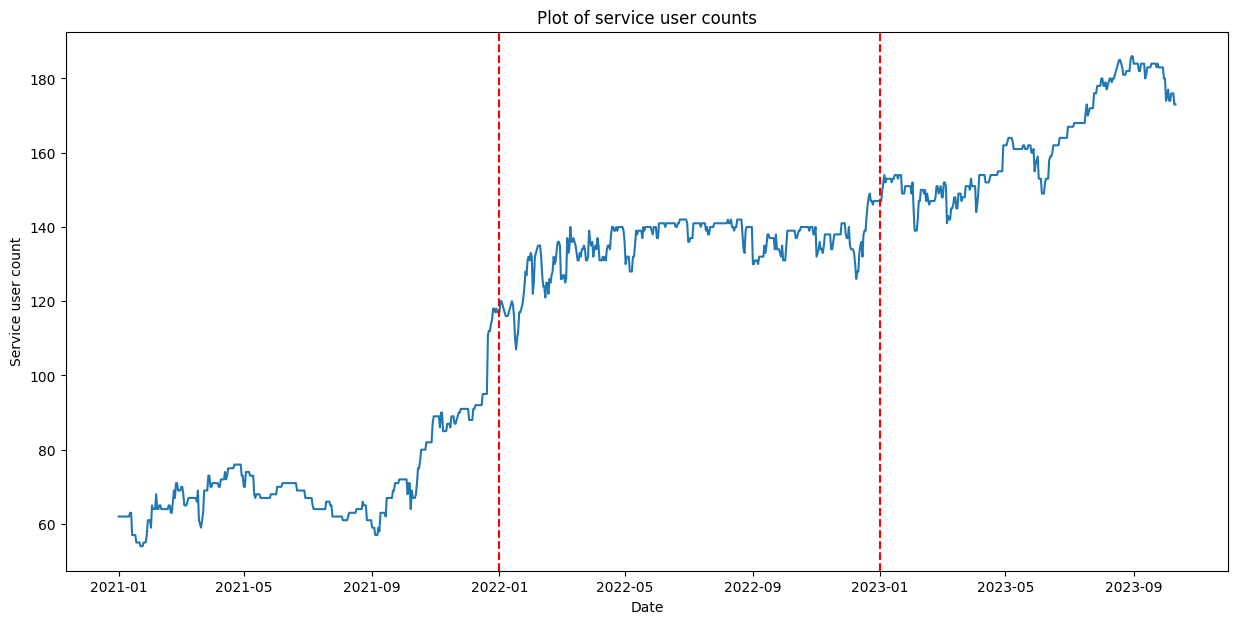

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,1)[7] intercept


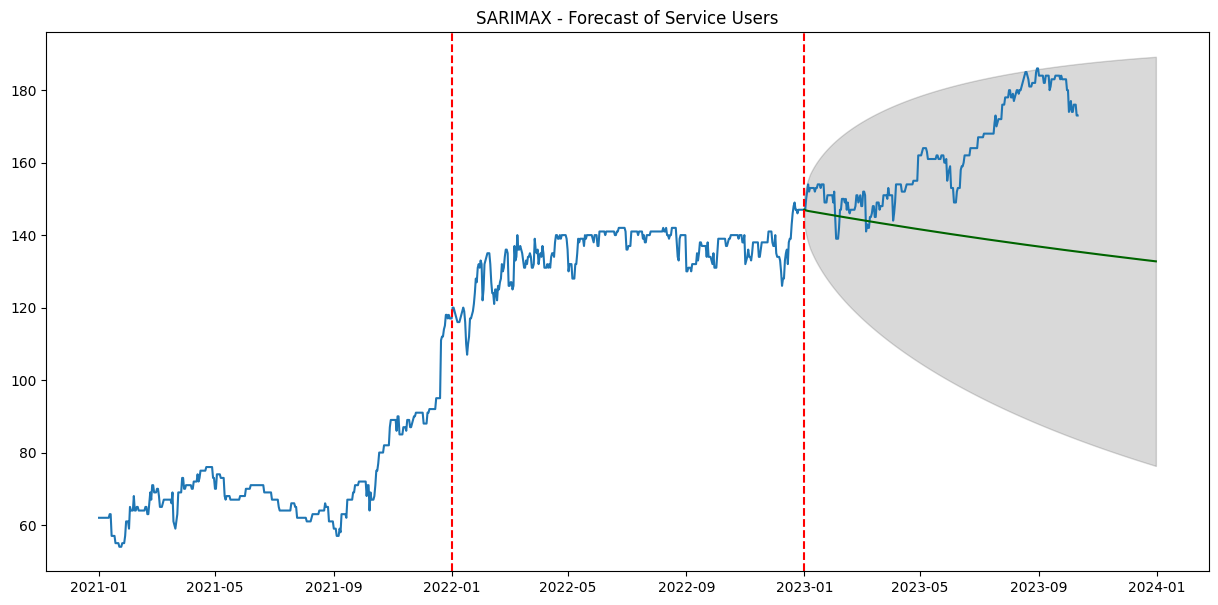

MSE:  731.342807866677
RMSE:  27.04335052959742
MAE:  21.765087449343632
Bendale-Glen Andrew


C:\Users\miche\AppData\Local\Temp\ipykernel_29620\2546742915.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_values = pd.concat([Eval_values, valueEval])


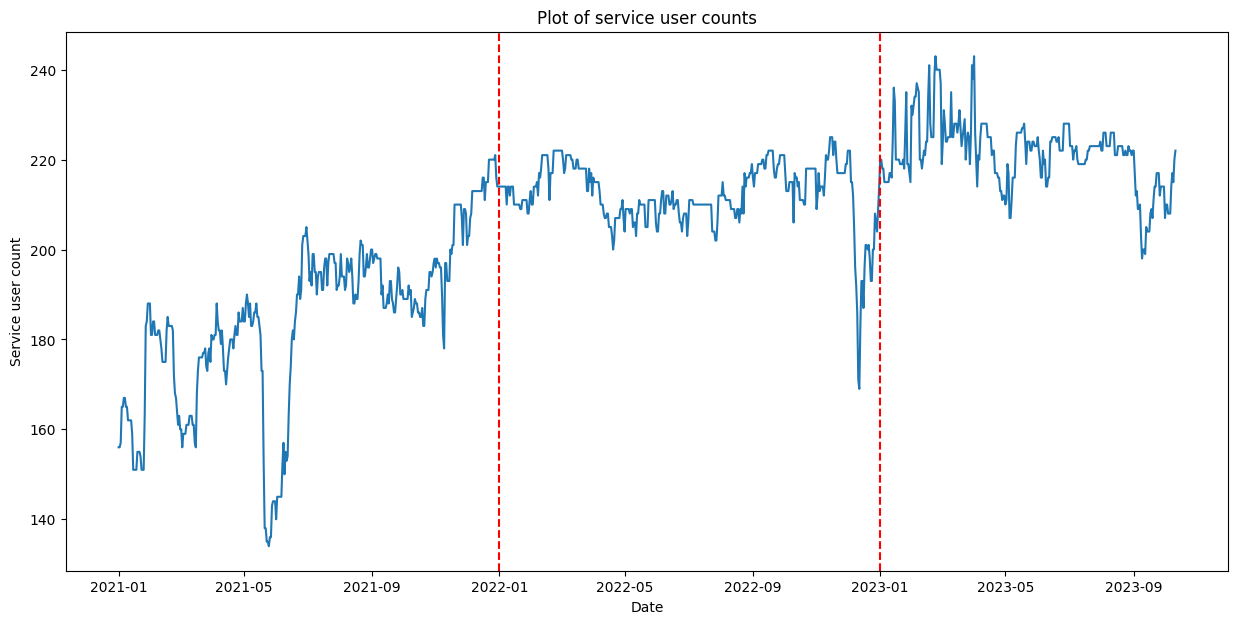

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


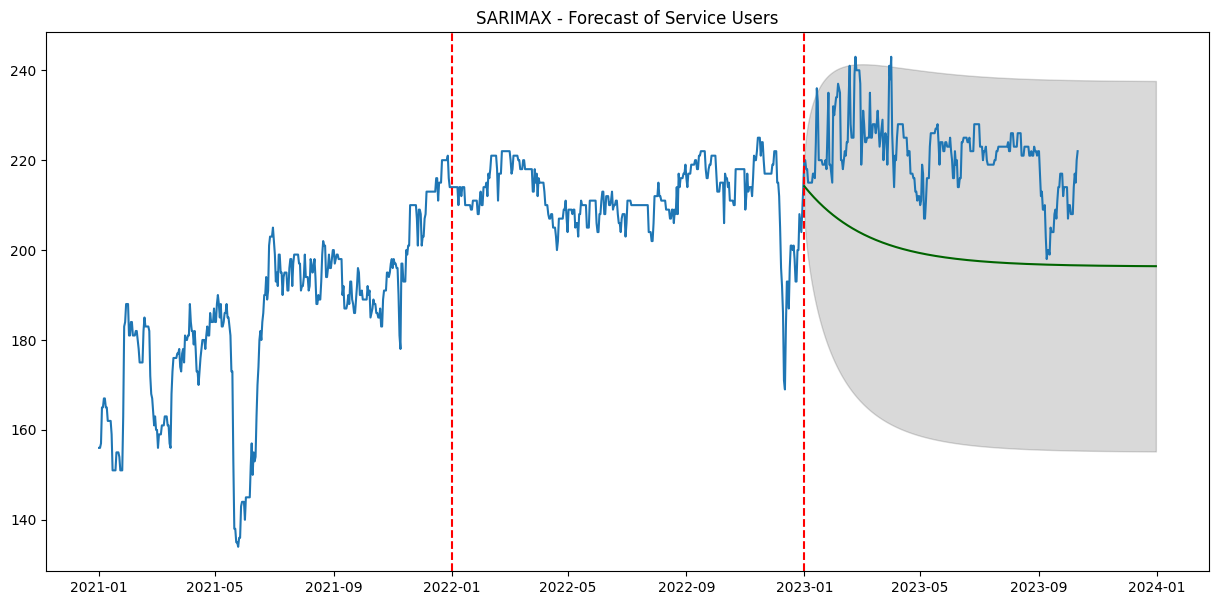

MSE:  499.6654952706403
RMSE:  22.35319877043642
MAE:  20.942907312317992
Broadview North


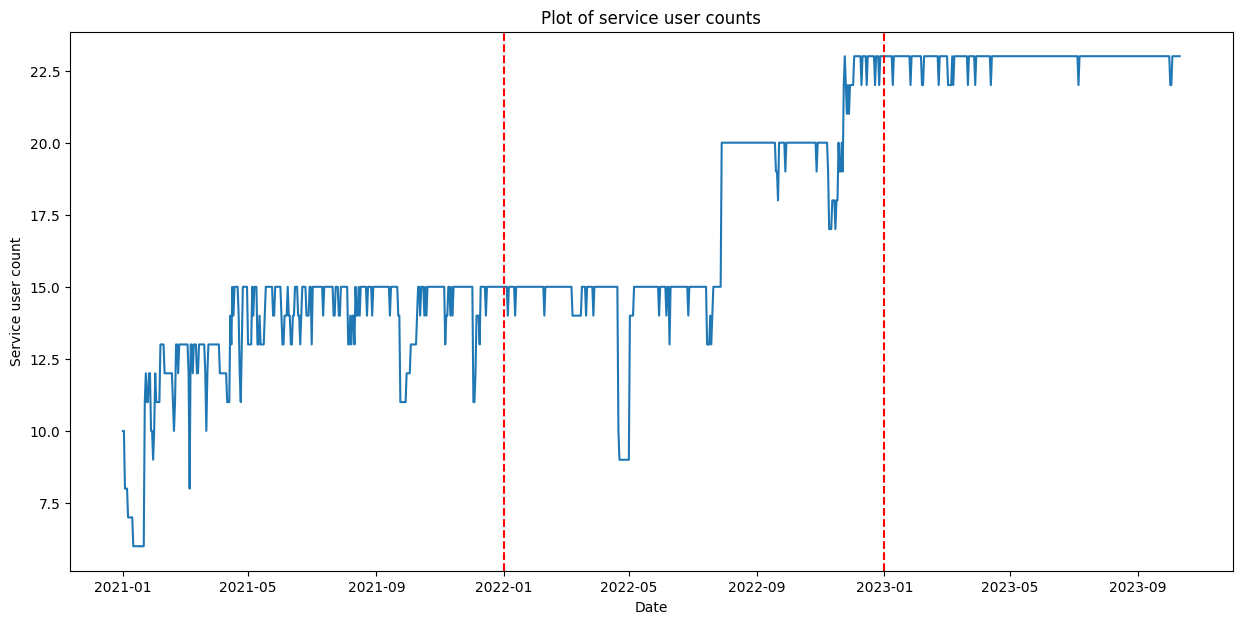

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


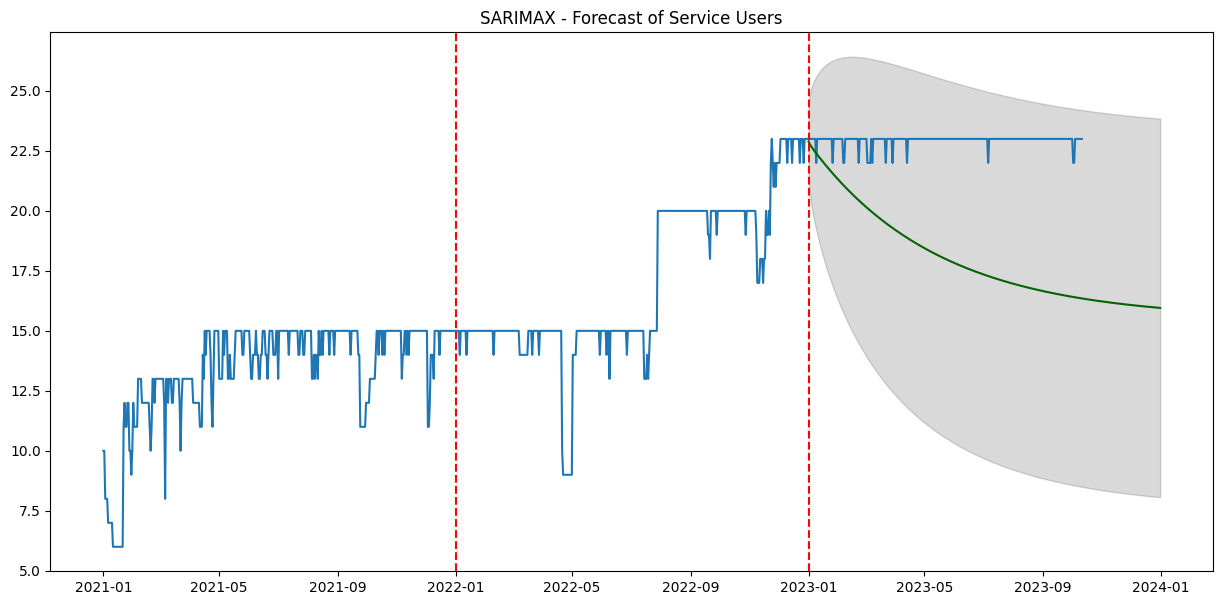

MSE:  23.07039410644512
RMSE:  4.803165009287639
MAE:  4.4298495671563085
Caledonia-Fairbank


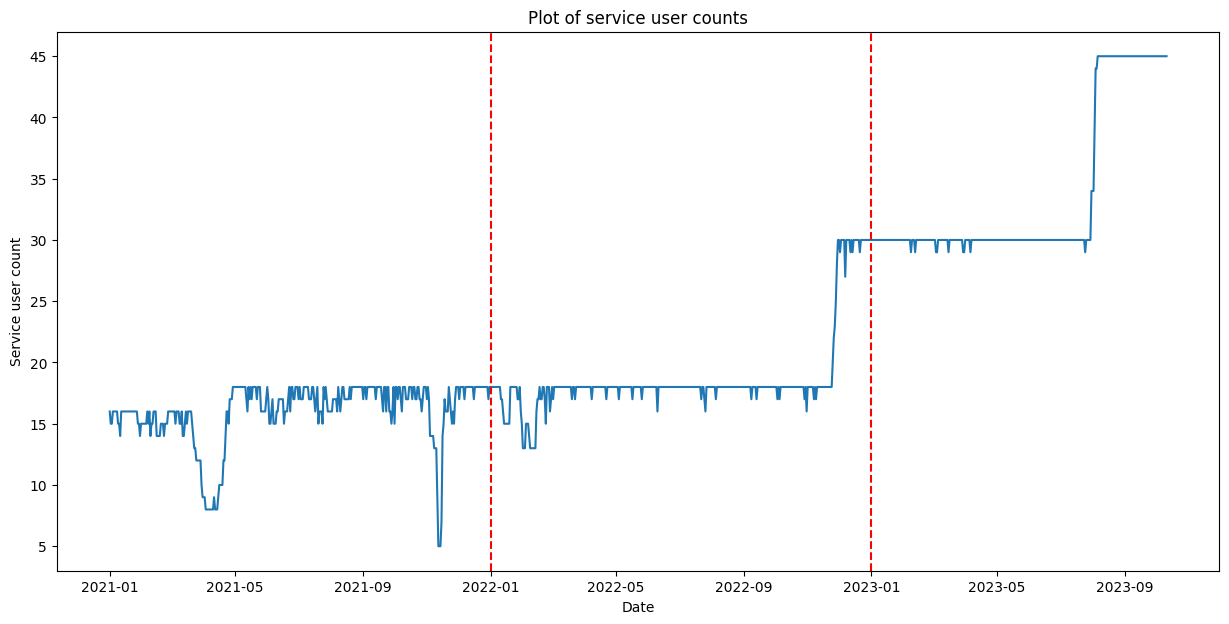

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(0,0,0)[7] intercept


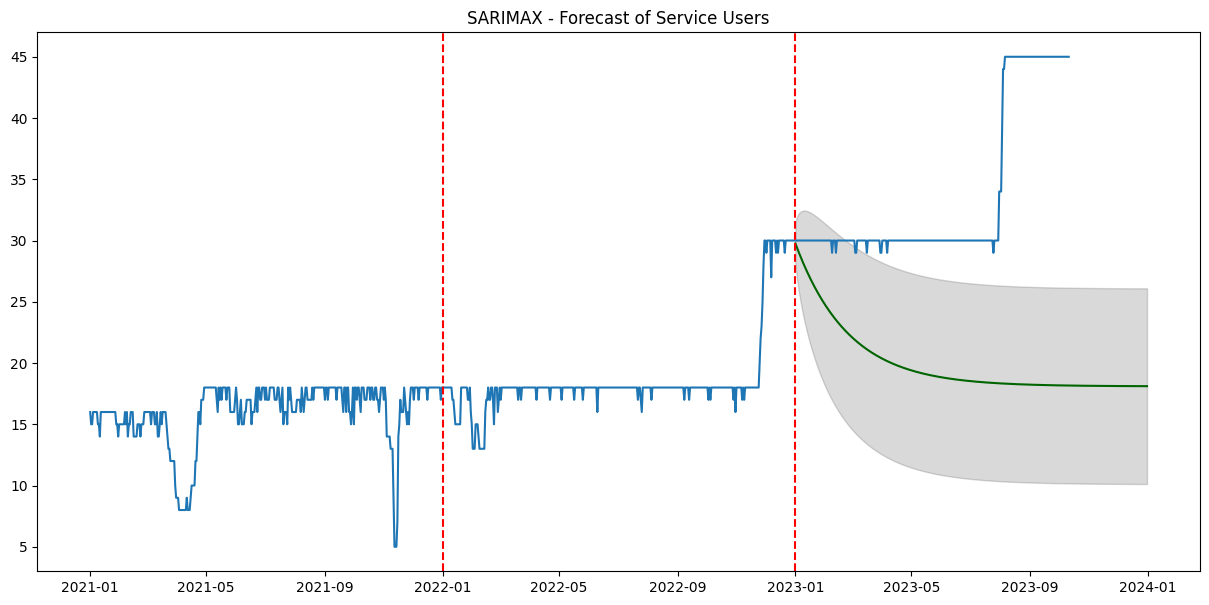

MSE:  243.06994074113118
RMSE:  15.590700457039484
MAE:  13.324777443502798
Church-Wellesley


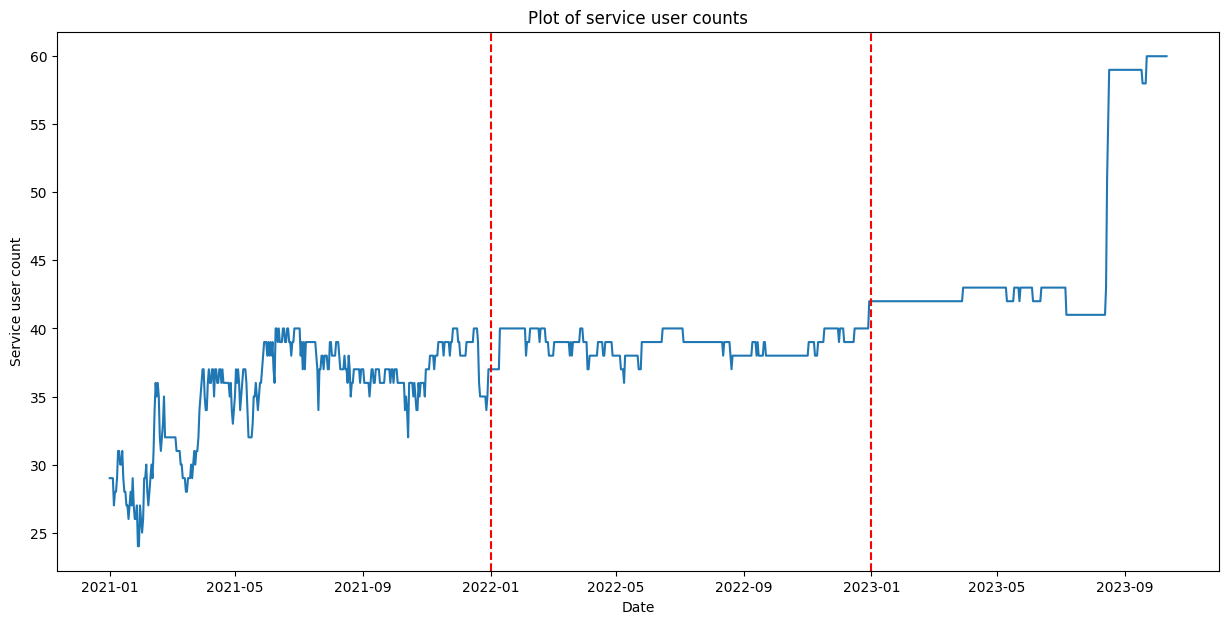

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(1,0,0)[7] intercept


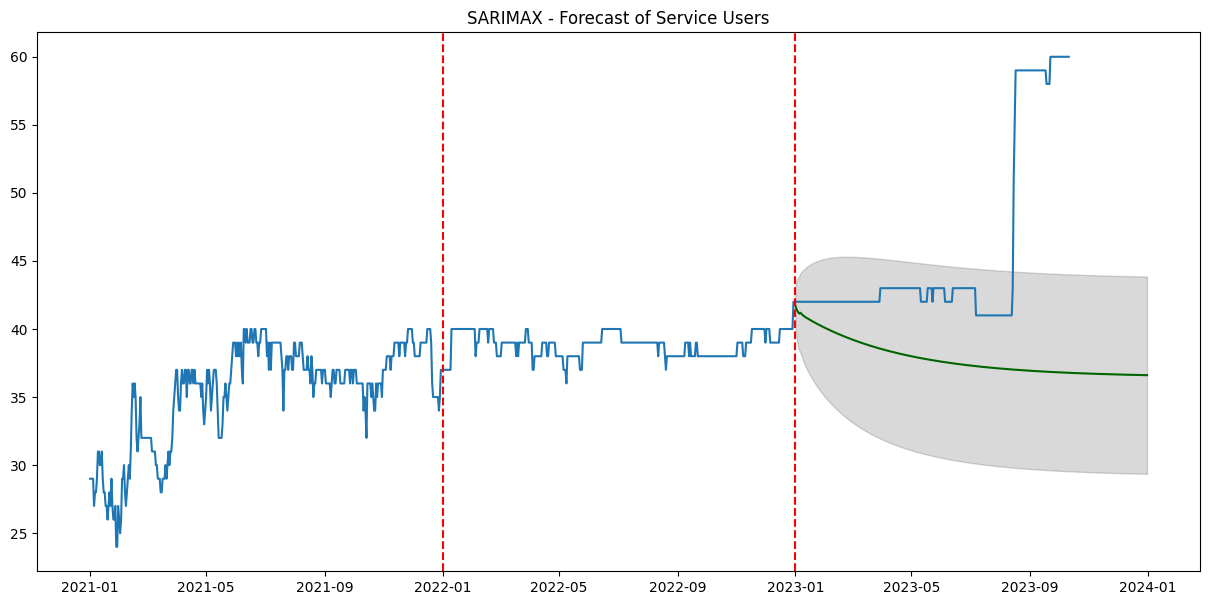

MSE:  113.598231132724
RMSE:  10.65824709474893
MAE:  7.508445554399417
Dovercourt Village


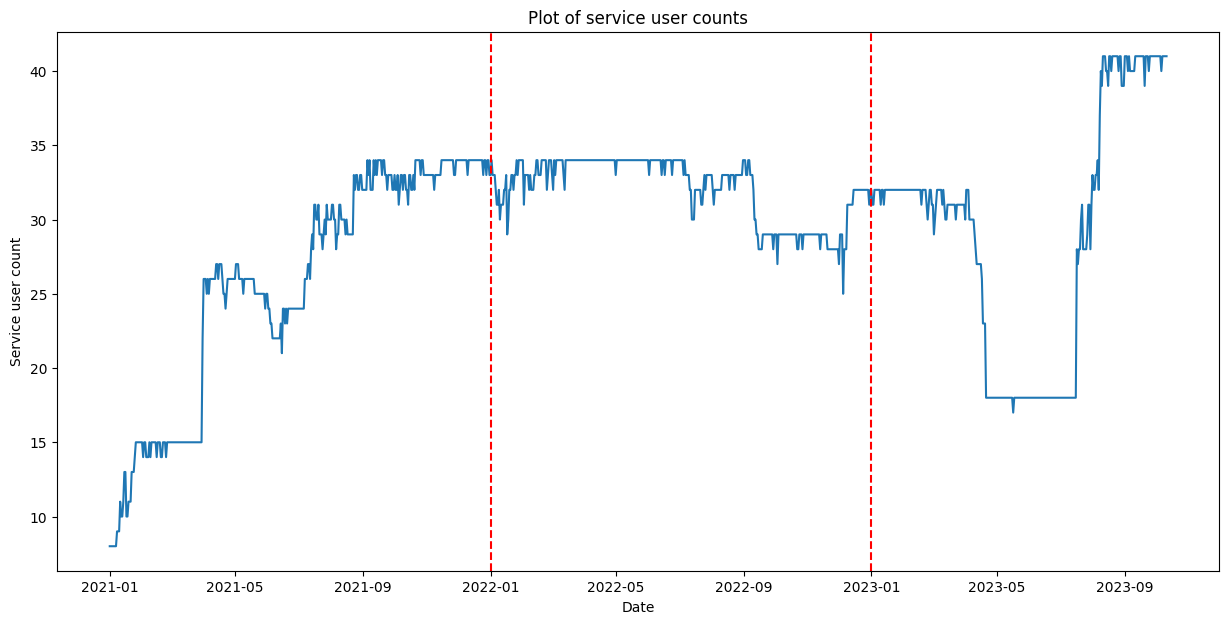

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,1)[7] intercept


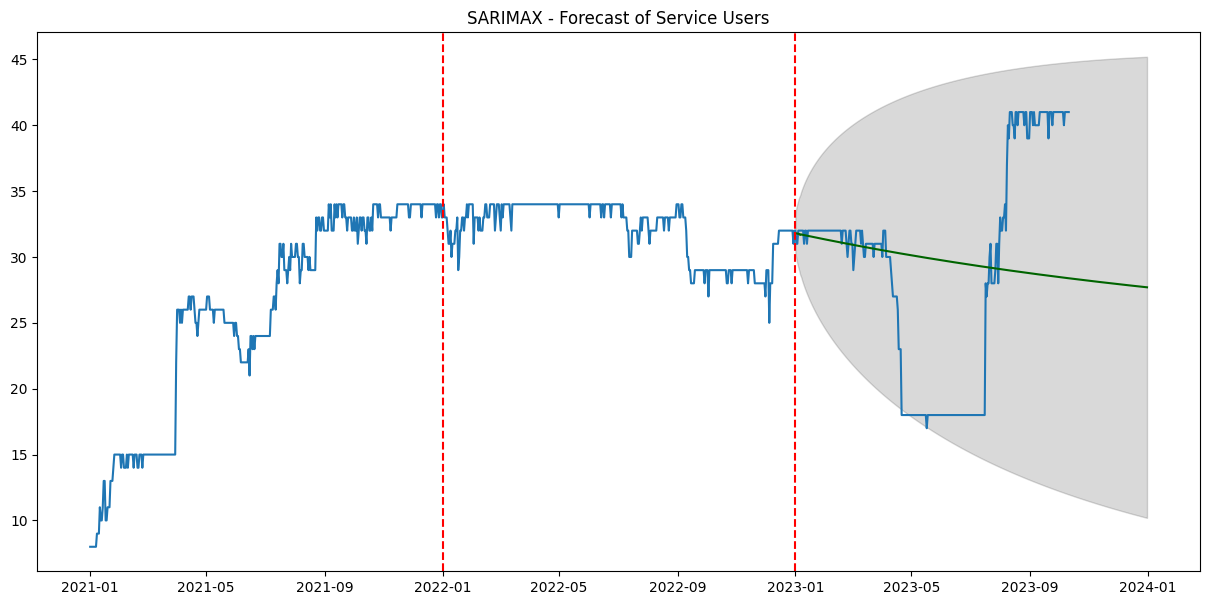

MSE:  76.1808700968284
RMSE:  8.728165333953545
MAE:  6.854764089599899
Downtown Yonge East


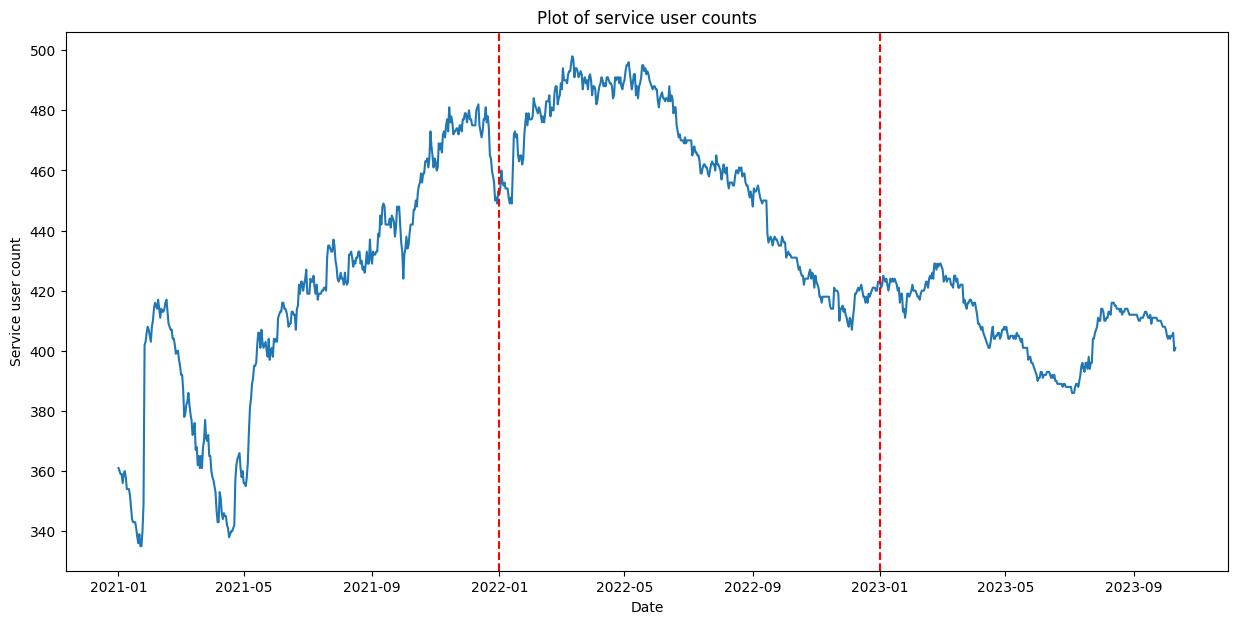

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[7] intercept


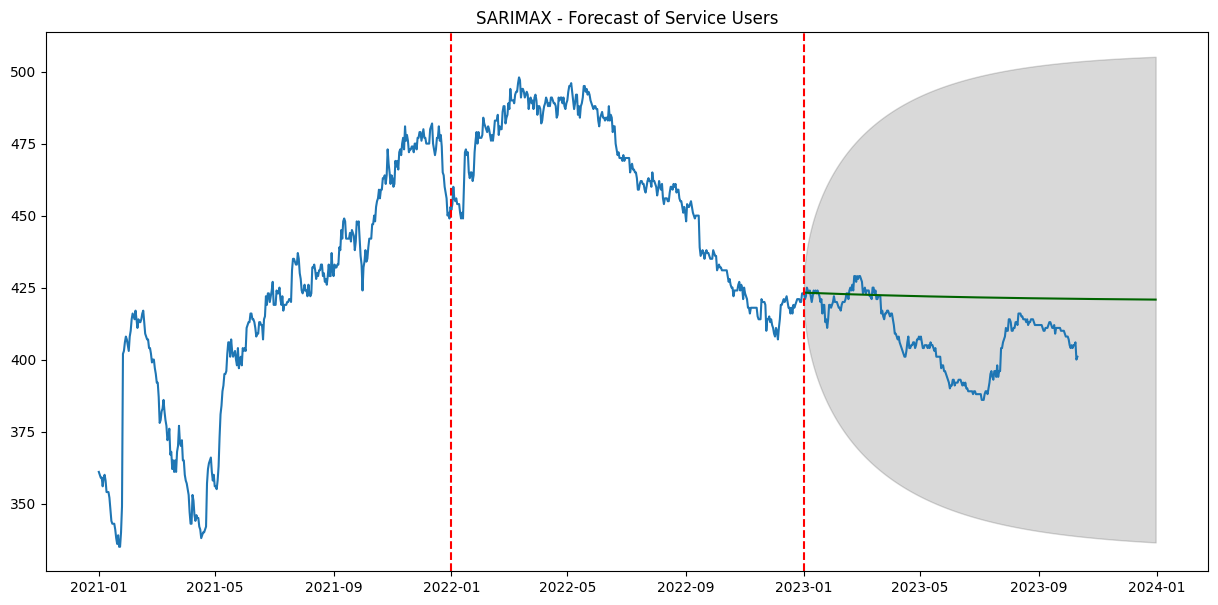

MSE:  291.60568955211795
RMSE:  17.076465956166633
MAE:  13.610686494580031
East End-Danforth


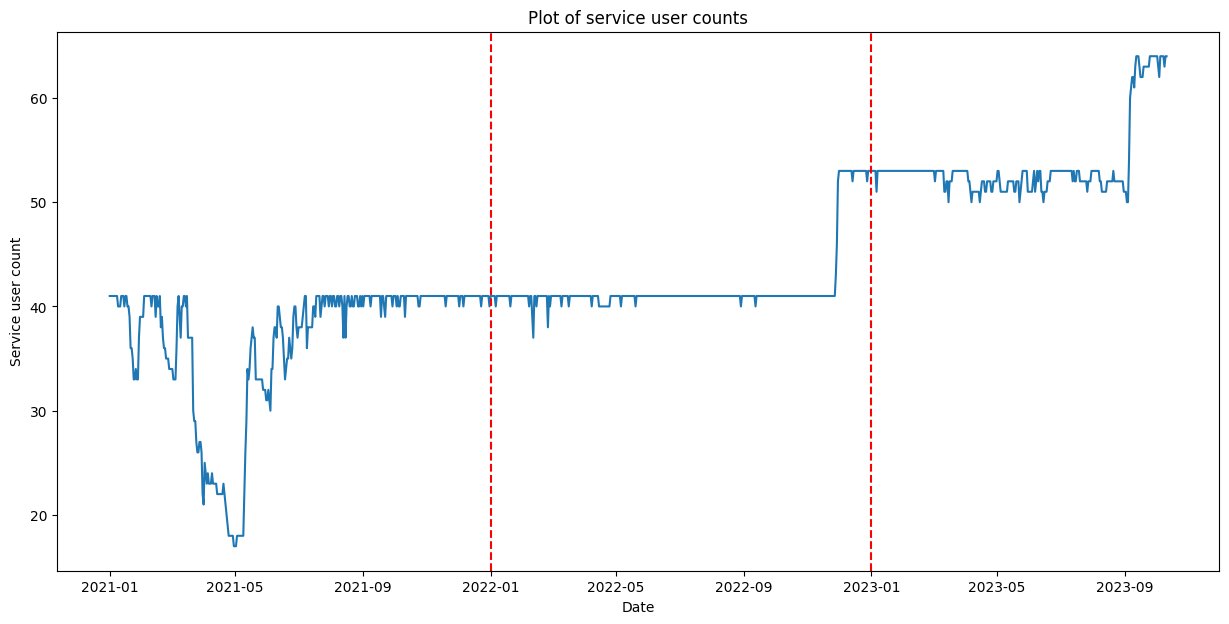

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(2,0,0)[7] intercept


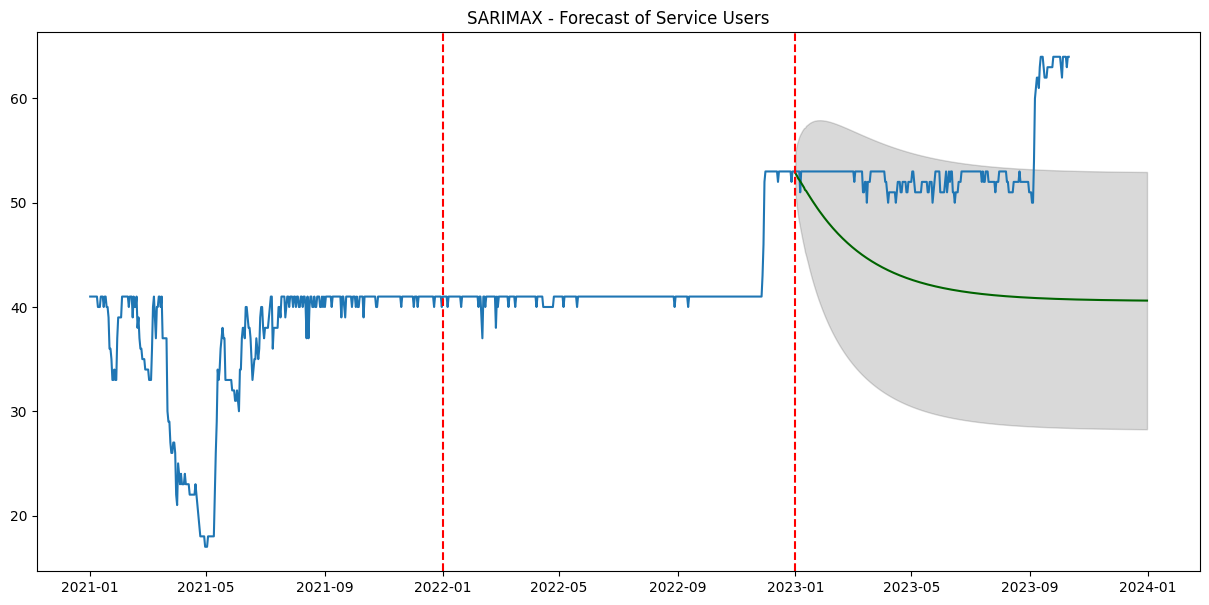

MSE:  132.9373589435104
RMSE:  11.529846440586725
MAE:  10.189024124963042
Fort York-Liberty Village


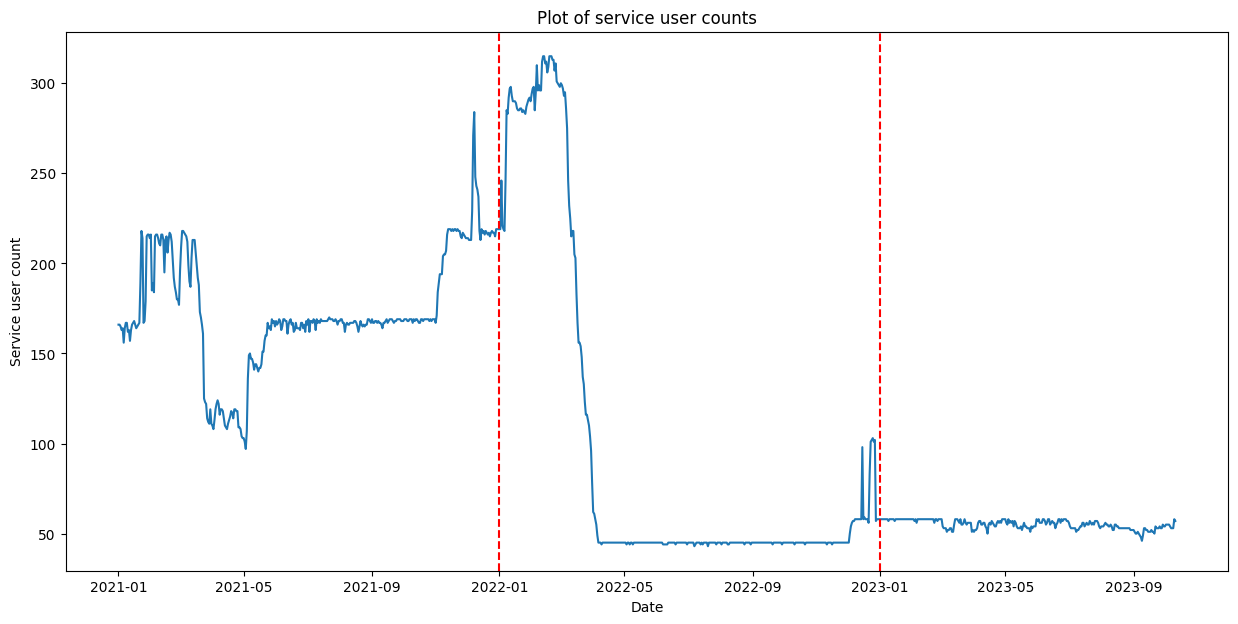

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


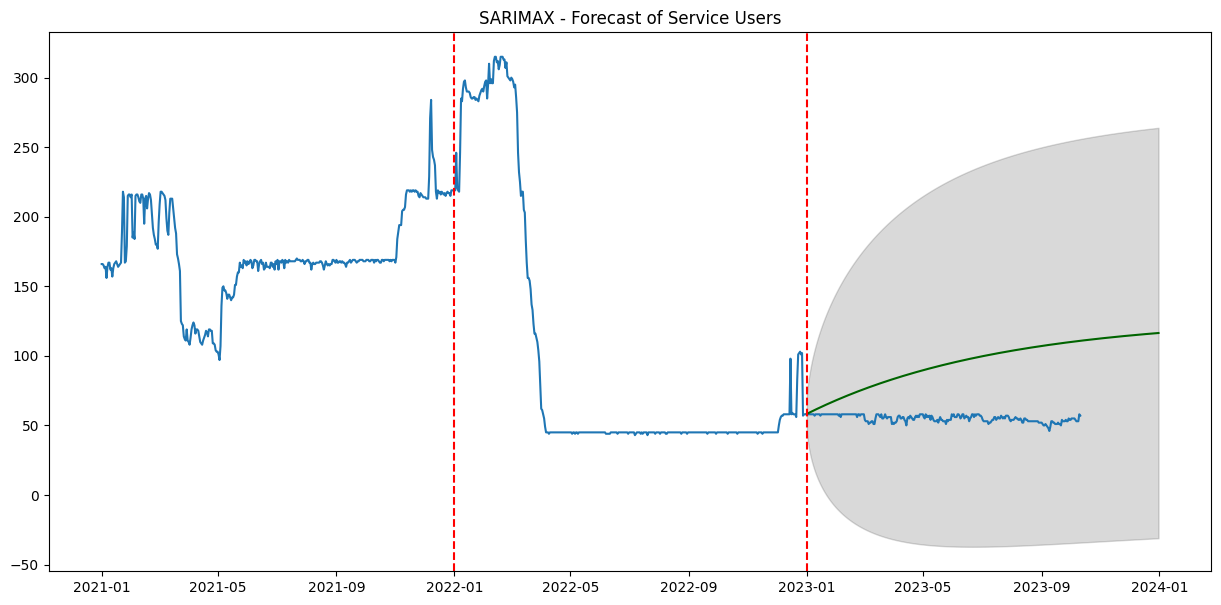

MSE:  1528.1522477096858
RMSE:  39.091587940497966
MAE:  35.420074111173165
Harbourfront-CityPlace


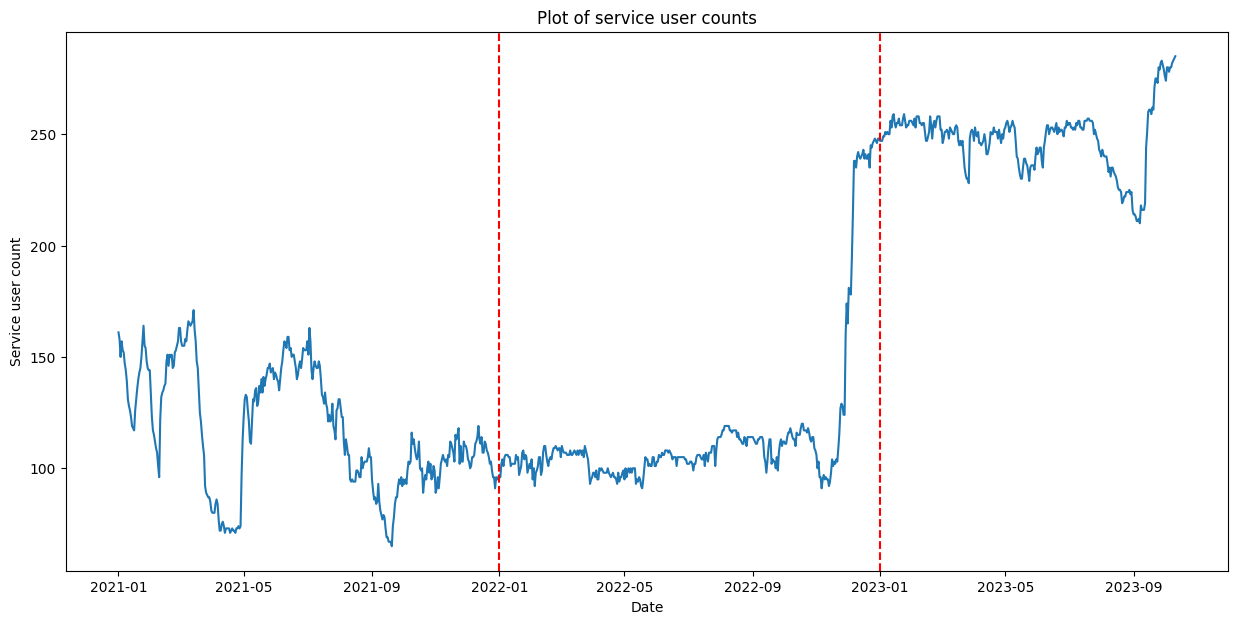

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(1,0,0)[7] intercept


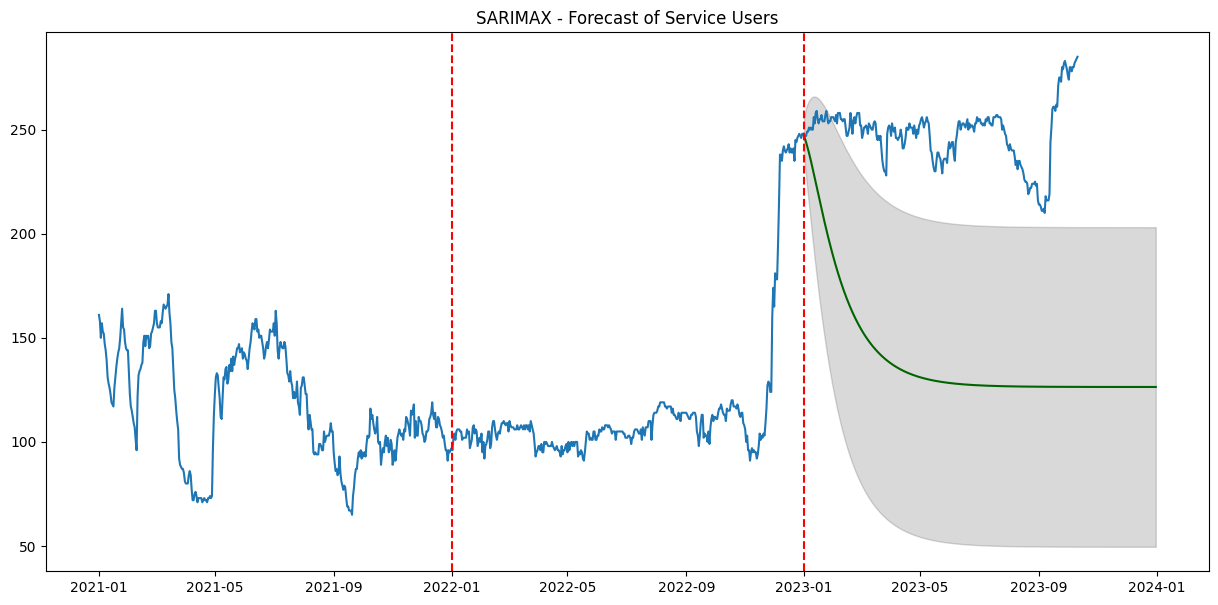

MSE:  11806.449824673624
RMSE:  108.65748858073991
MAE:  104.18758495410765
High Park-Swansea


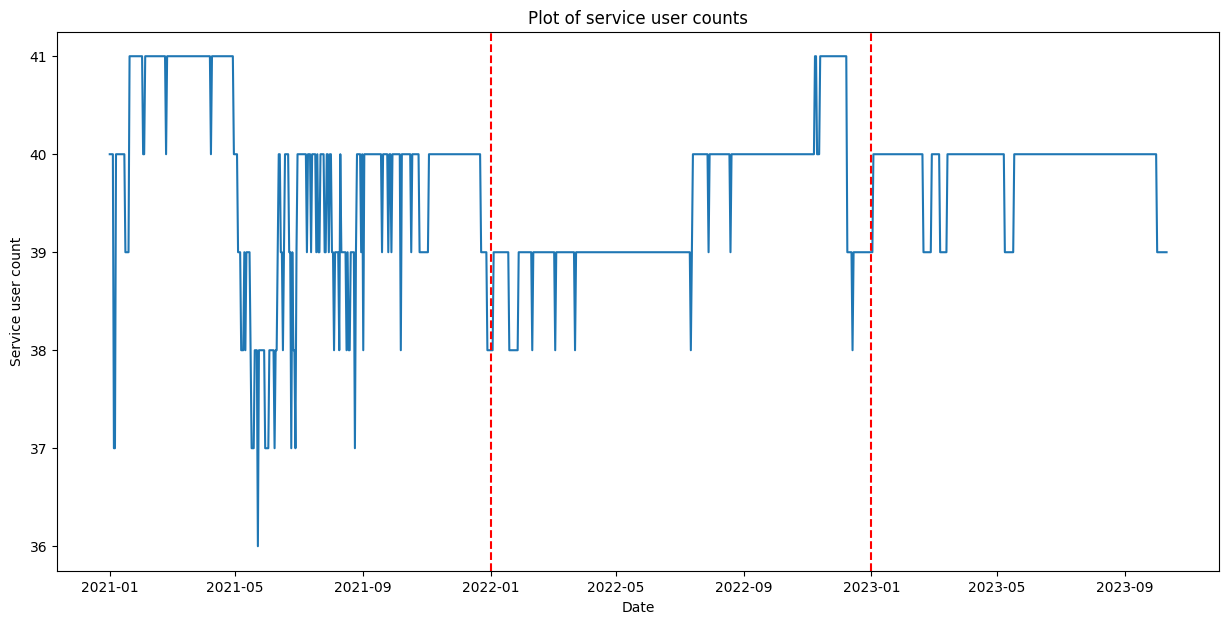

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,3)(0,0,0)[7] intercept


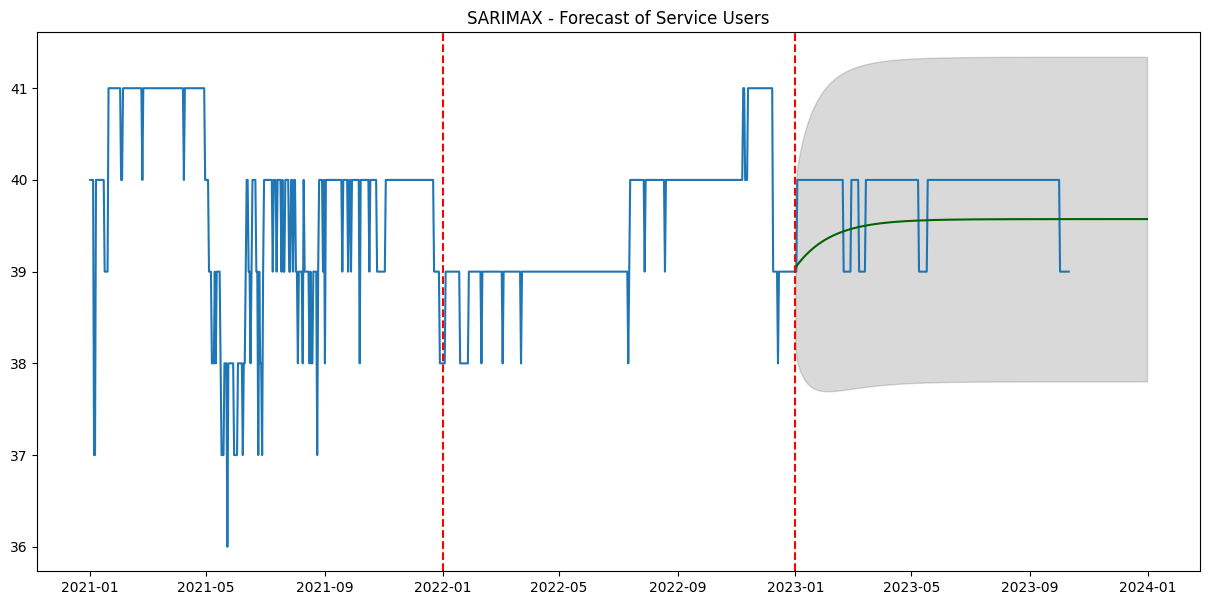

MSE:  0.25855031312675764
RMSE:  0.508478429362306
MAE:  0.49484684382342375
Hillcrest Village


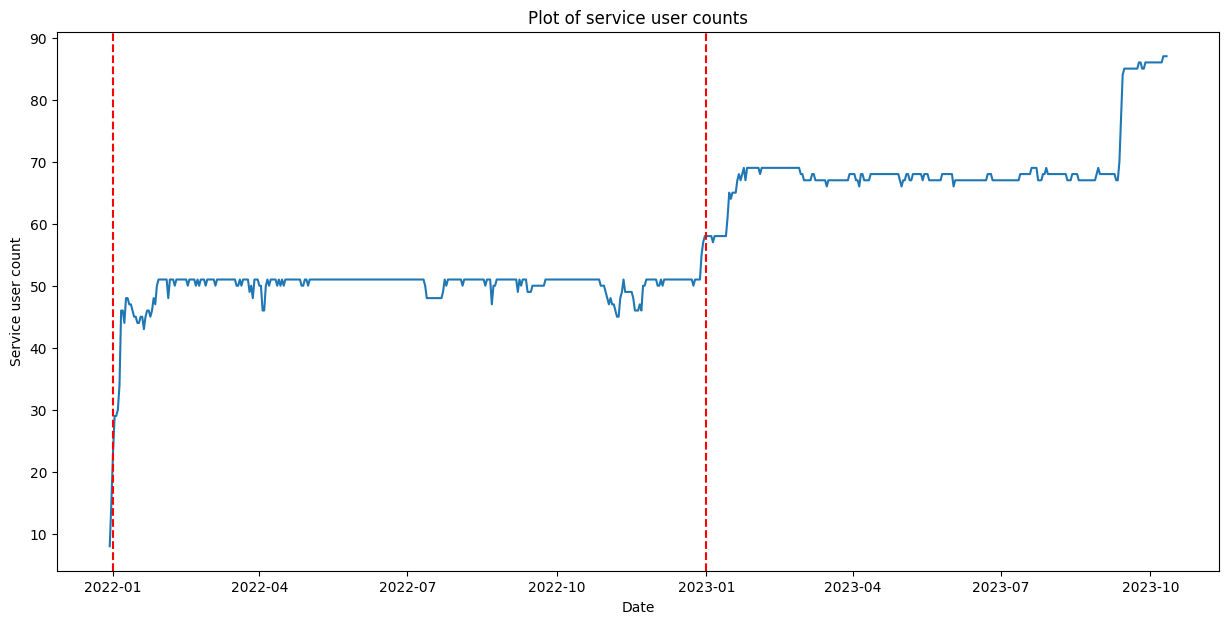

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(0,0,0)[7]          


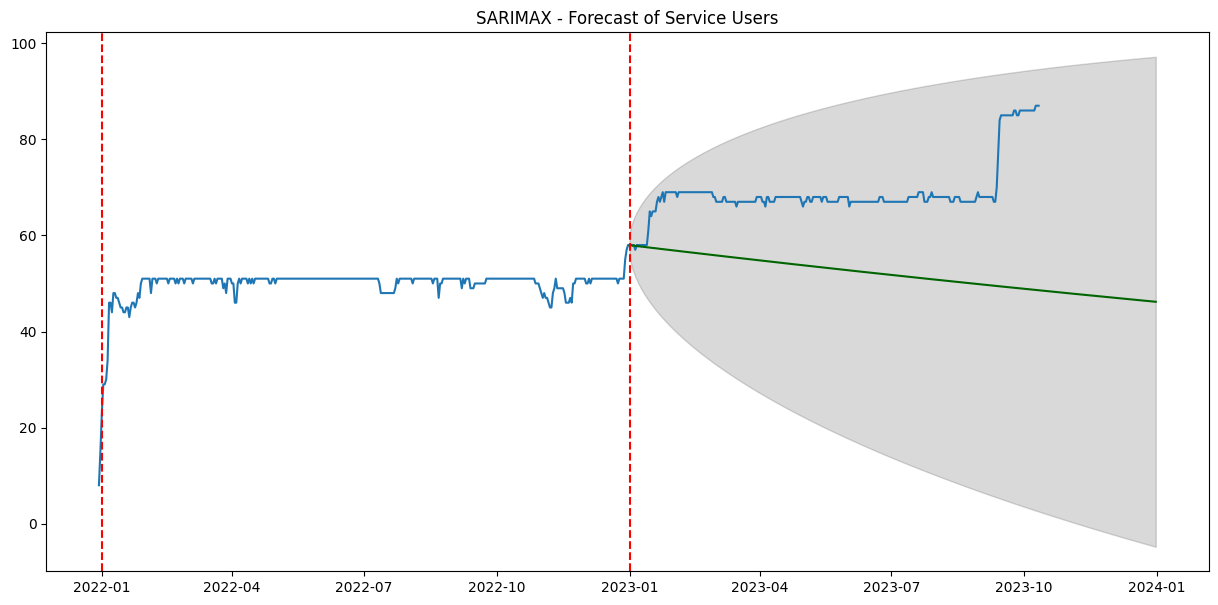

MSE:  312.86241225849074
RMSE:  17.687917126063507
MAE:  15.84509742134731
Junction Area


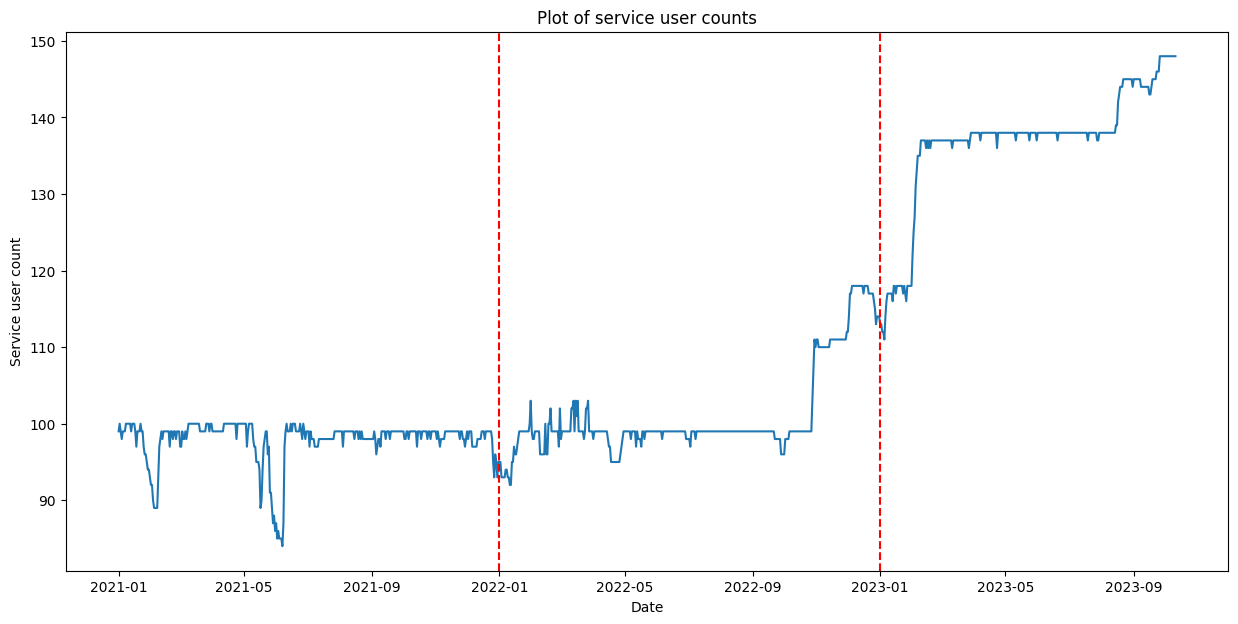

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[7] intercept


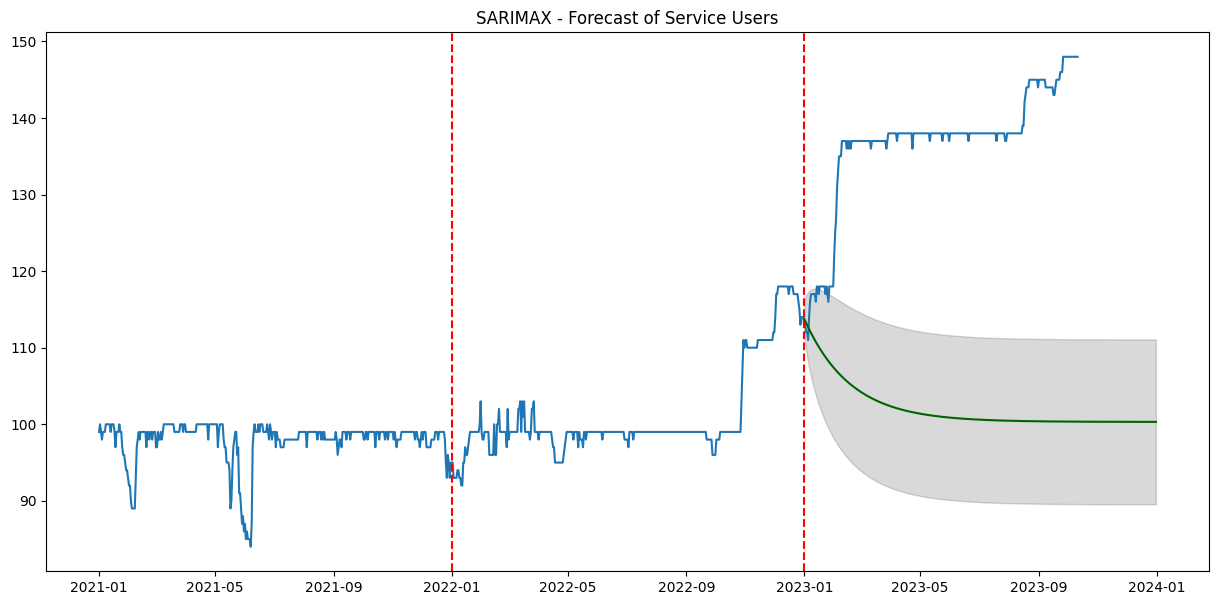

MSE:  1284.6310803899294
RMSE:  35.84175052072554
MAE:  34.165650135074316
Junction-Wallace Emerson


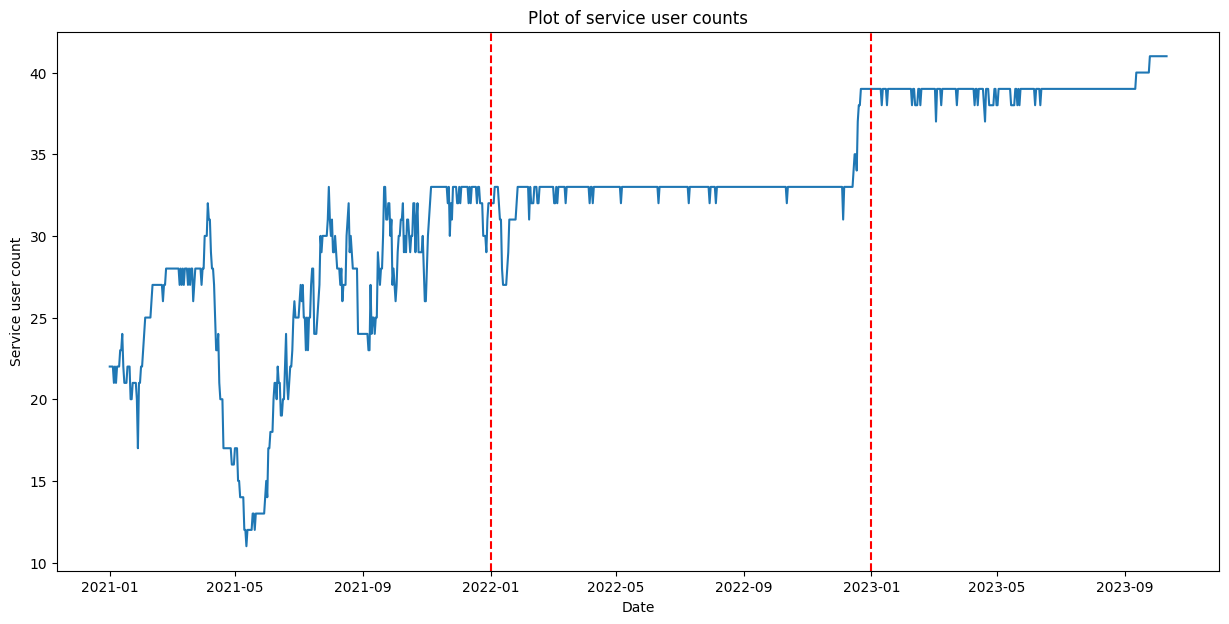

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


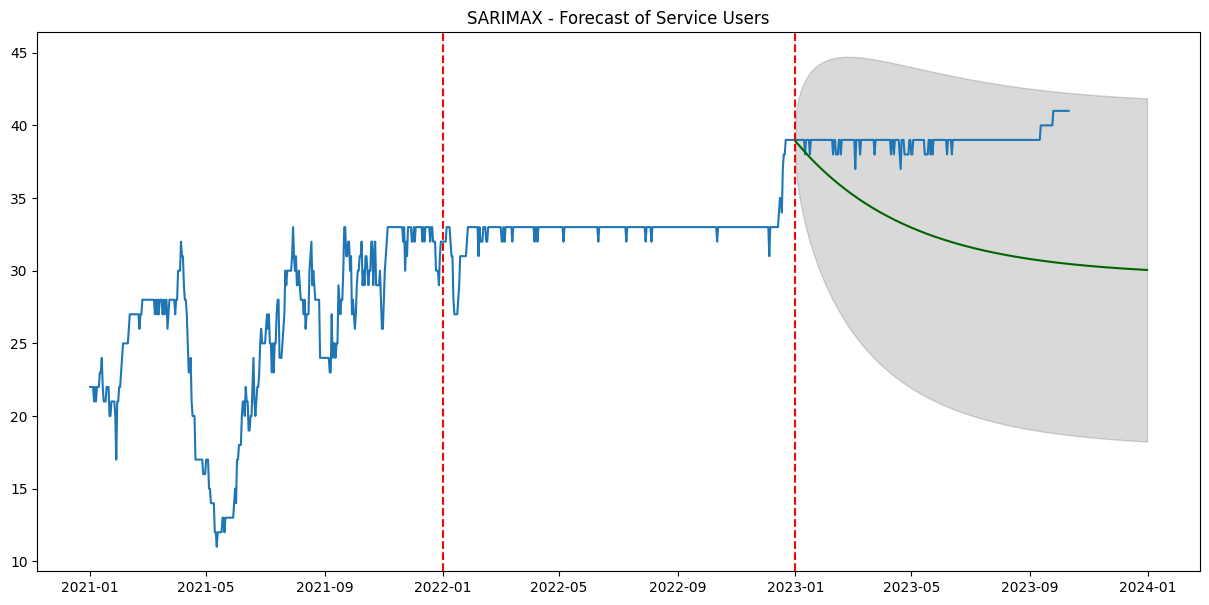

MSE:  41.94501241863535
RMSE:  6.476496924930587
MAE:  5.918102622590099
Kennedy Park


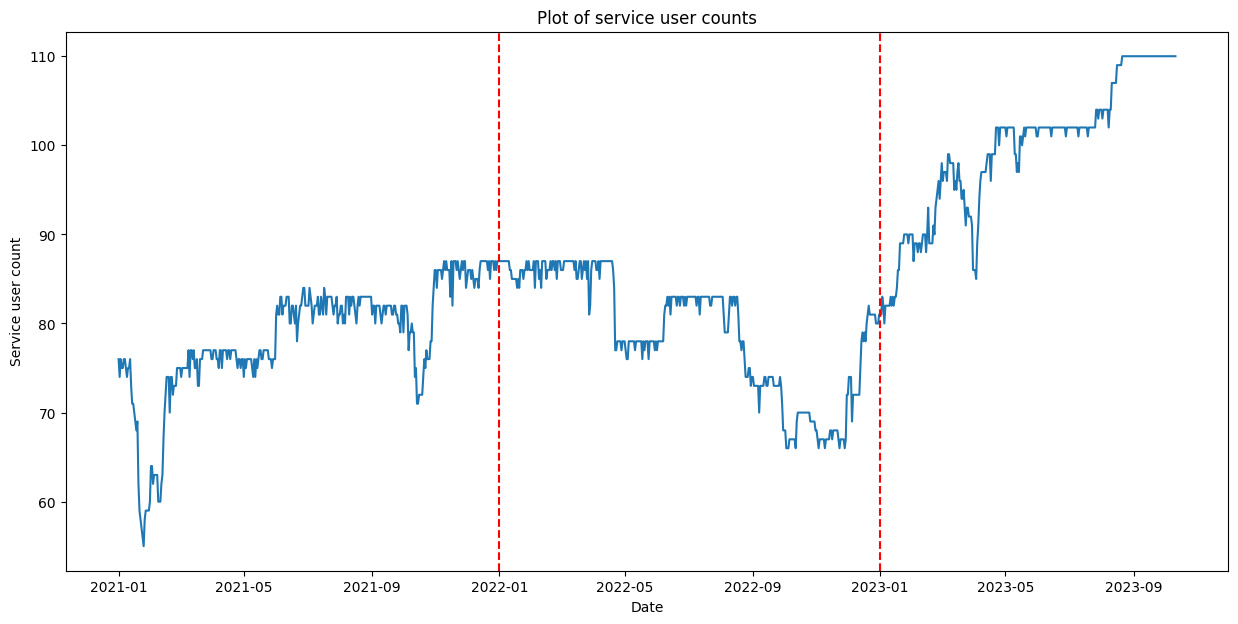

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(0,0,1)[7] intercept


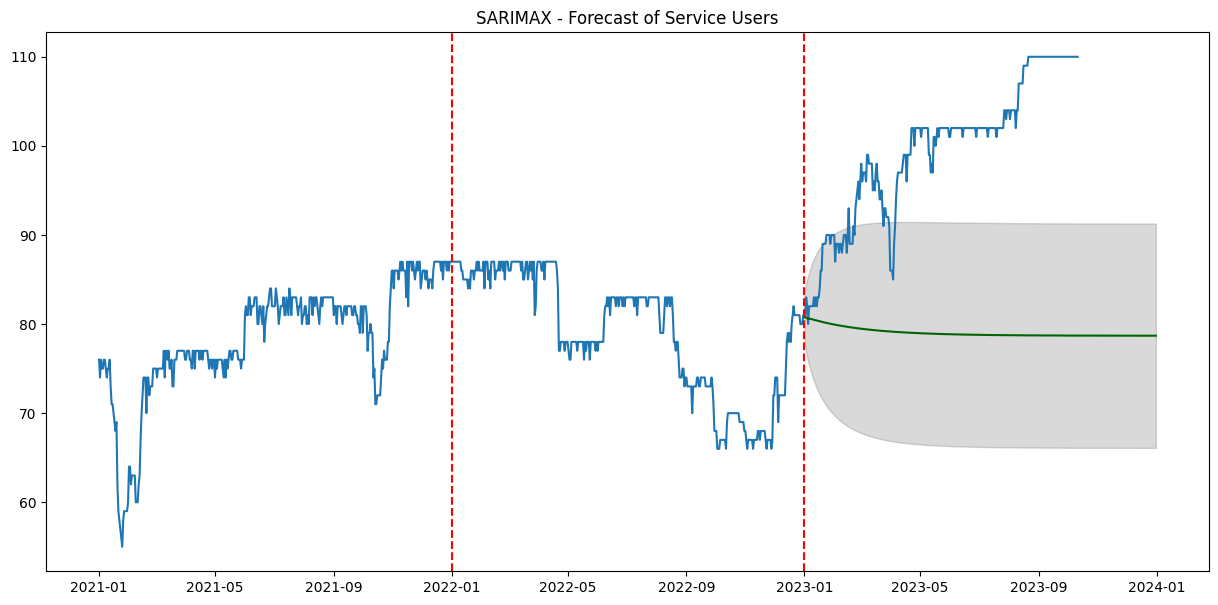

MSE:  483.7236711400461
RMSE:  21.993718901996683
MAE:  20.308068352746194
Kensington-Chinatown


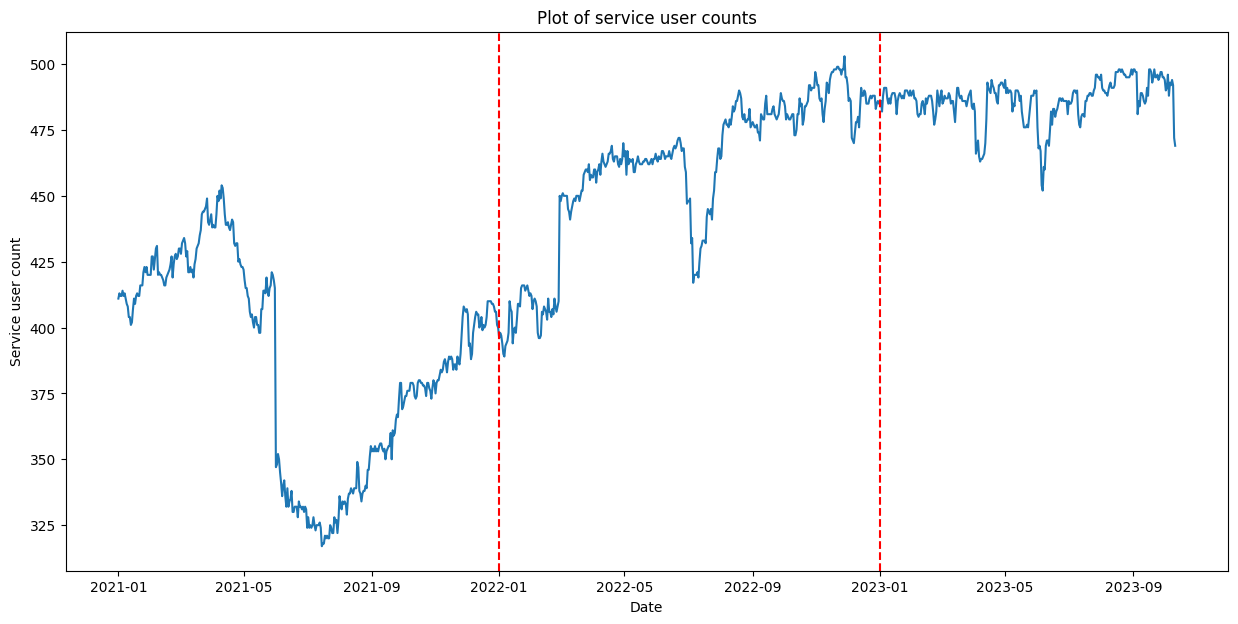

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


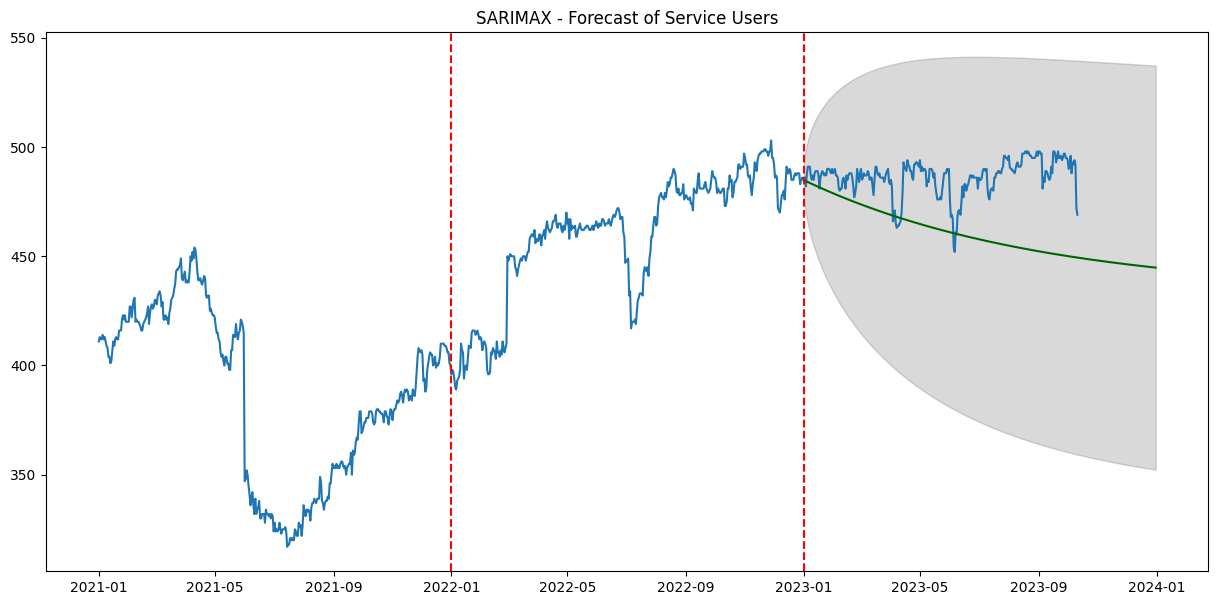

MSE:  713.9595088313738
RMSE:  26.72002074908202
MAE:  22.939424101249376
Little Portugal


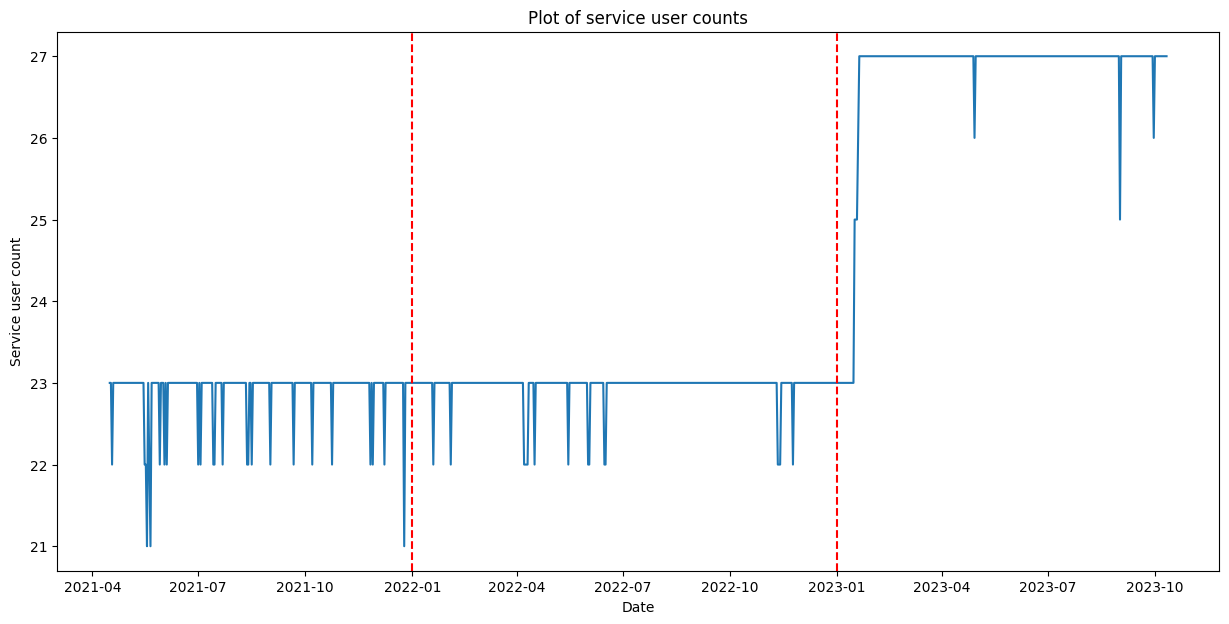

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(0,0,0)[7] intercept


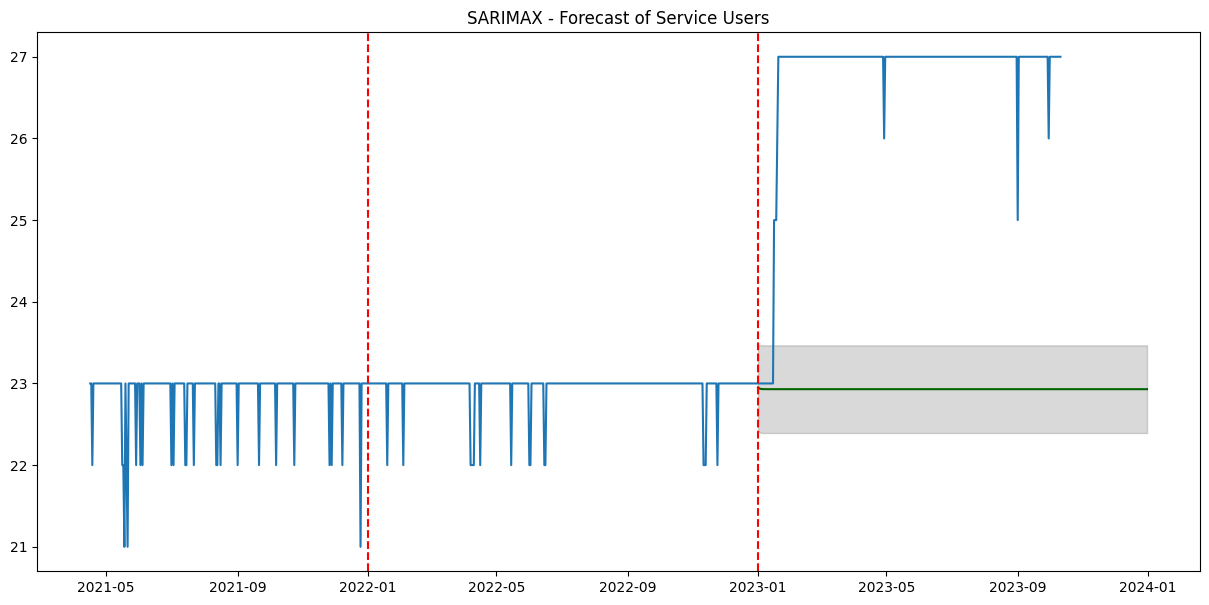

MSE:  15.443730483025215
RMSE:  3.92985120367492
MAE:  3.8201005497738416
Mimico-Queensway


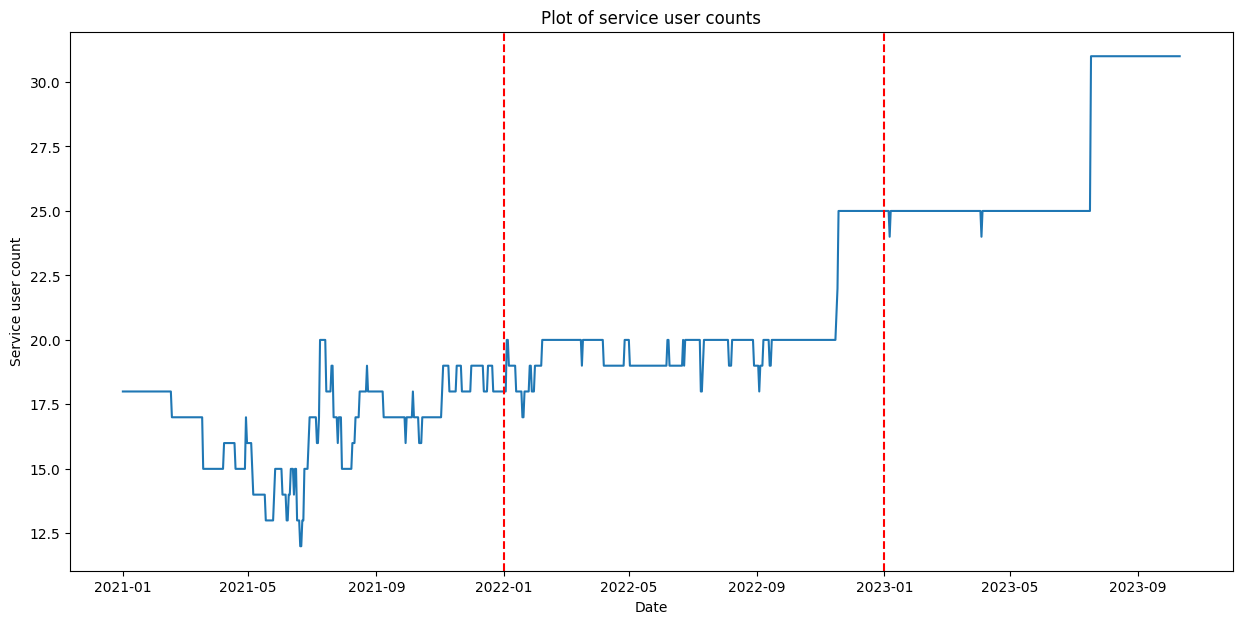

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,0)[7] intercept


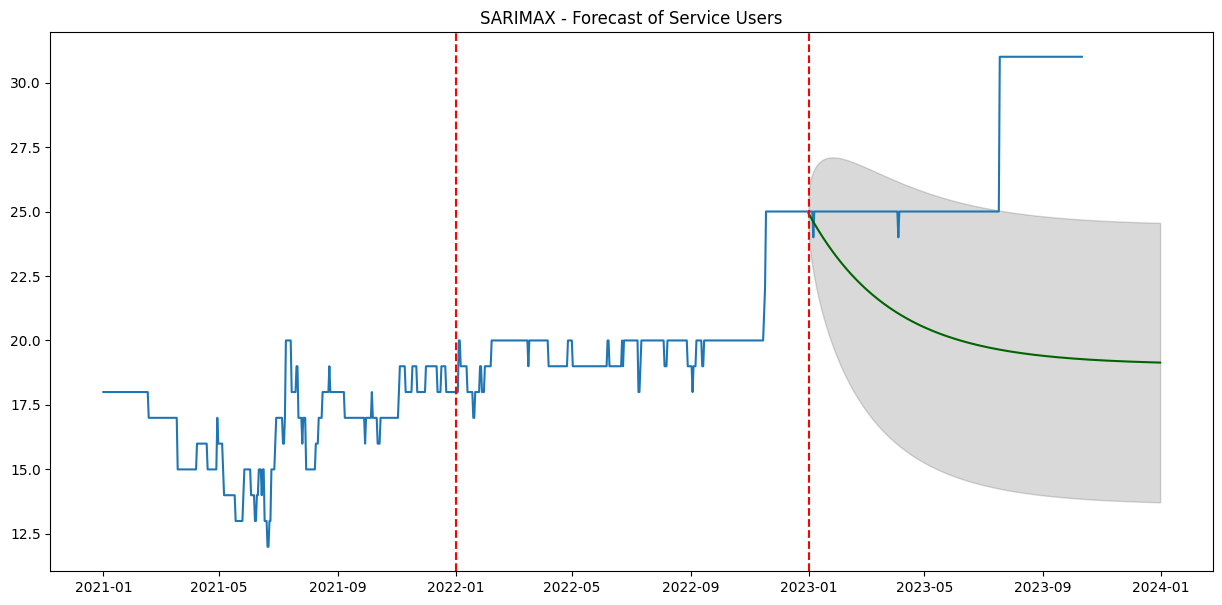

MSE:  51.25549616930061
RMSE:  7.159294390461997
MAE:  6.036305070504989
Moss Park


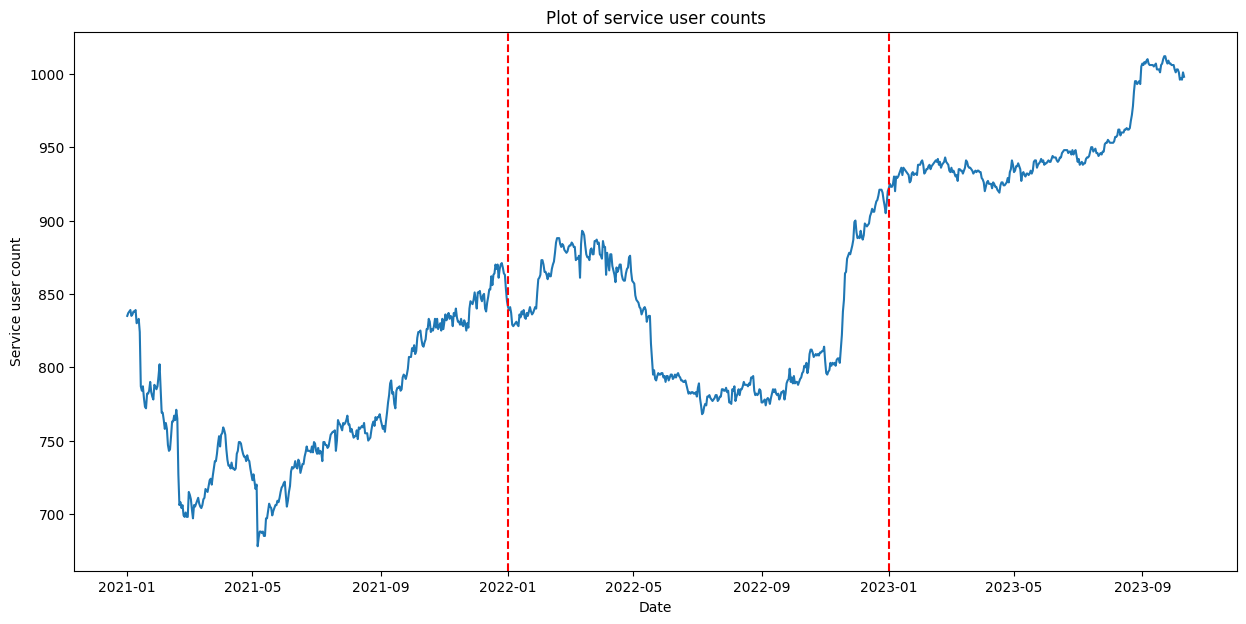

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


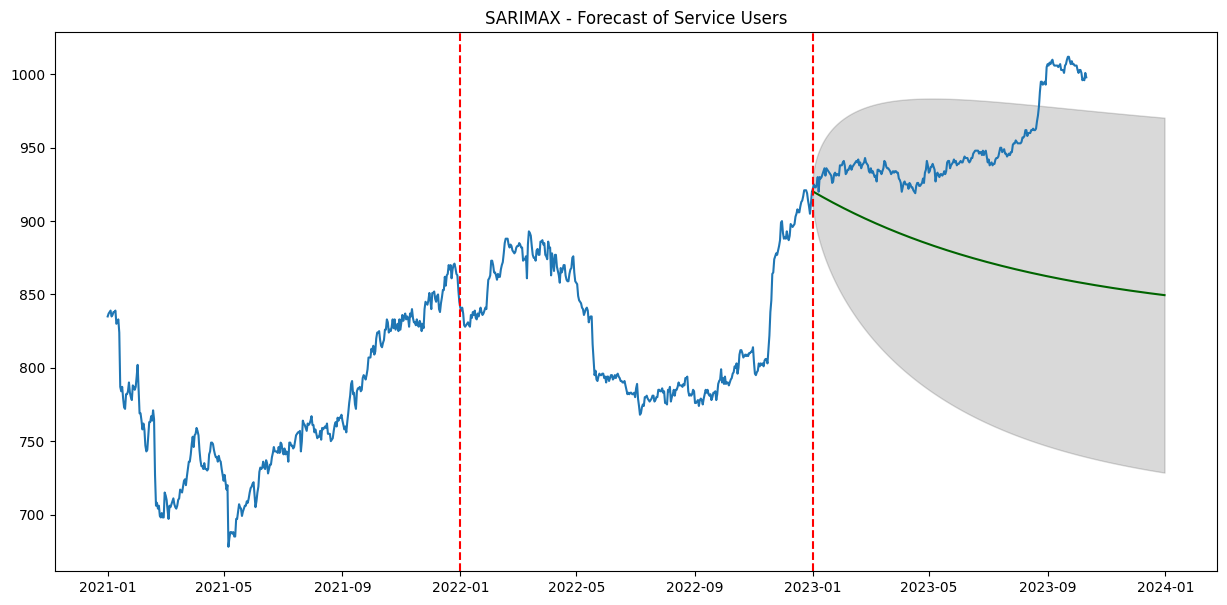

MSE:  6215.761097339102
RMSE:  78.84009828341858
MAE:  67.19251652572072
Newtonbrook East


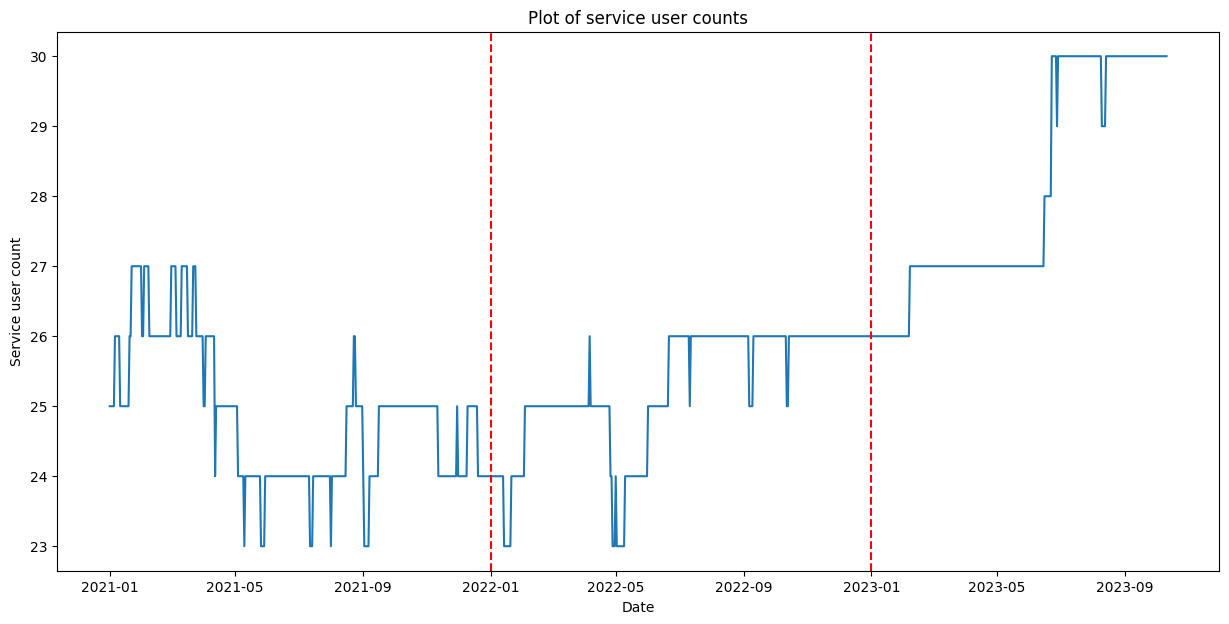

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


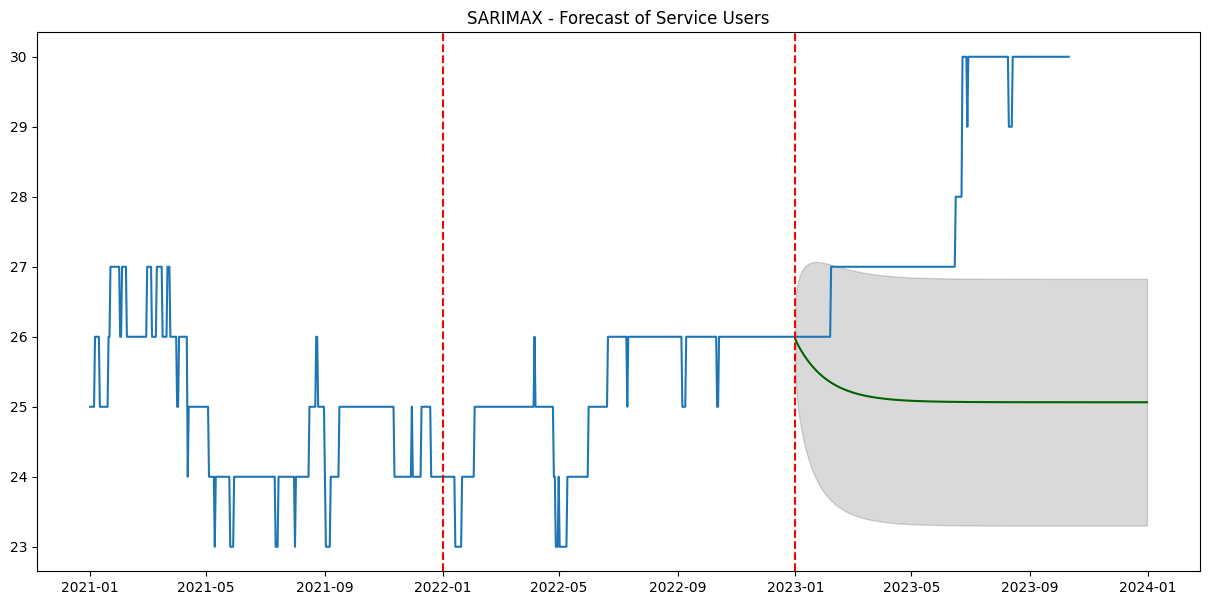

MSE:  11.180194869192949
RMSE:  3.3436798395170775
MAE:  2.882740435513551
North St.James Town


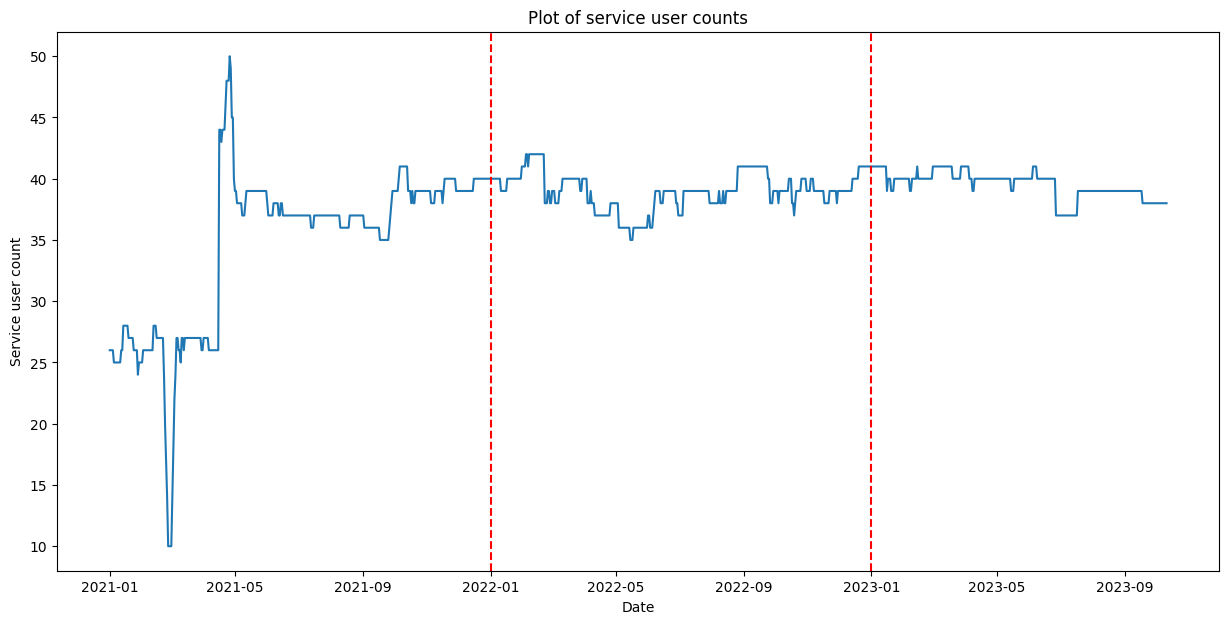

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


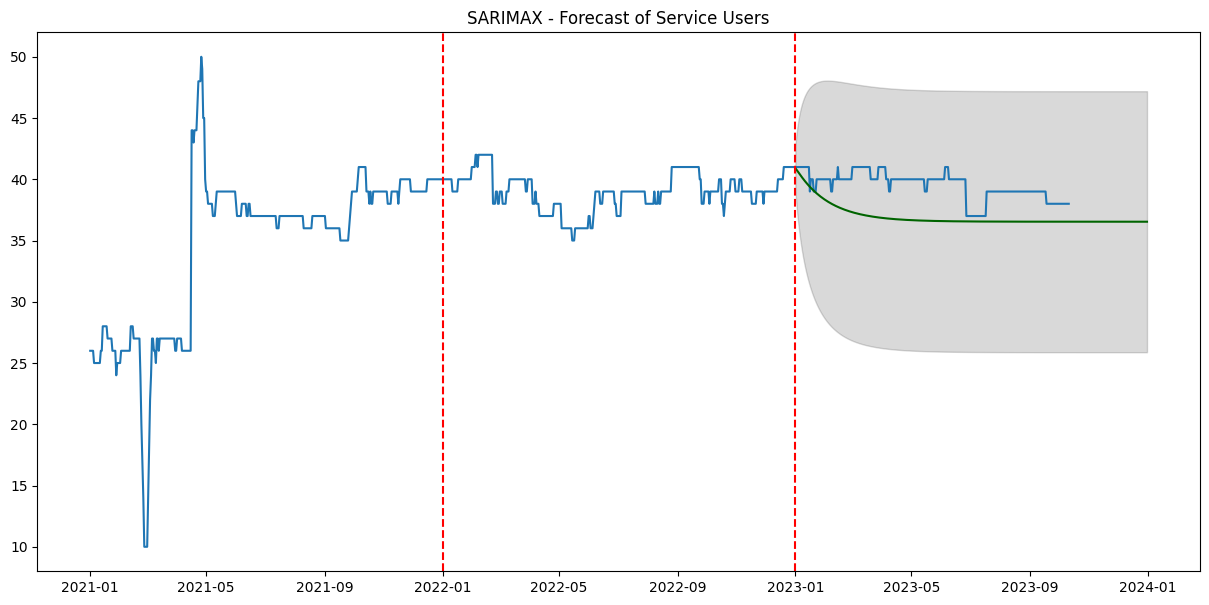

MSE:  7.197170252189943
RMSE:  2.68275422880851
MAE:  2.4498454297378327
North Toronto


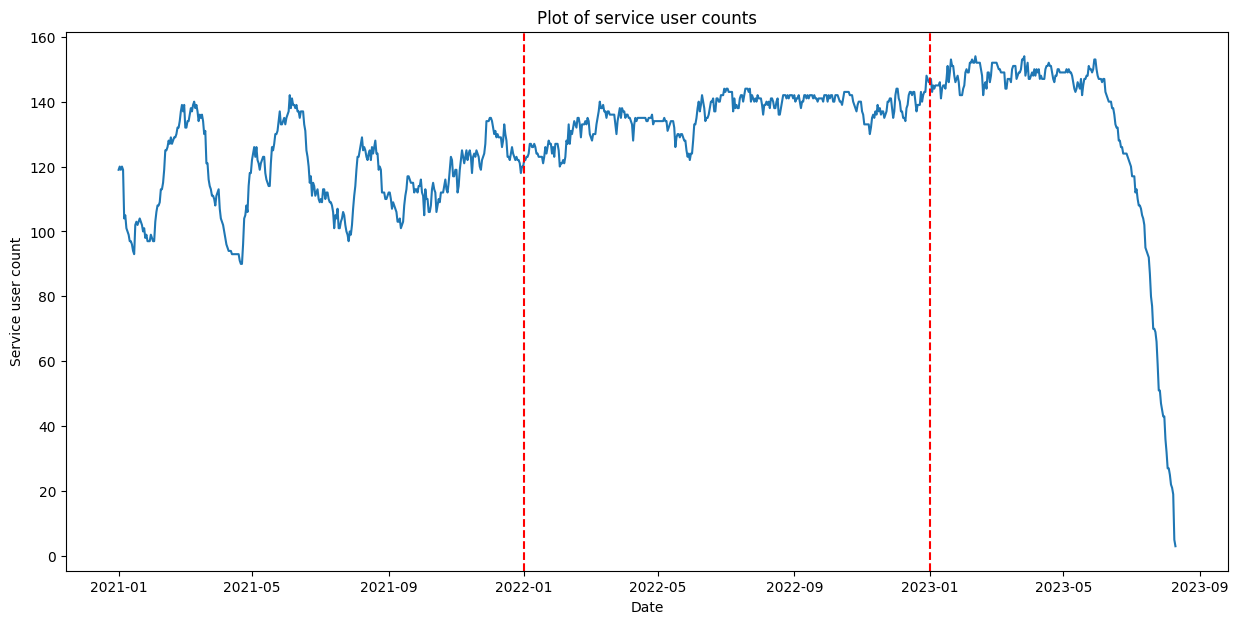

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,0)[7] intercept


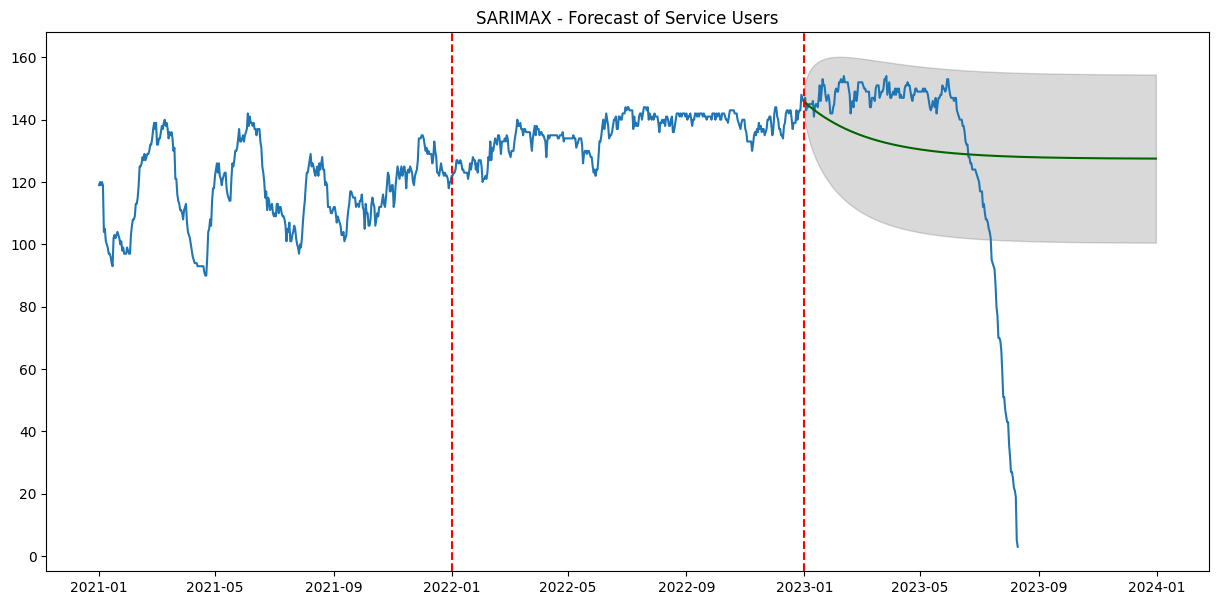

MSE:  1018.8030919120312
RMSE:  31.9186950220718
MAE:  21.205984924262175
Oakwood Village


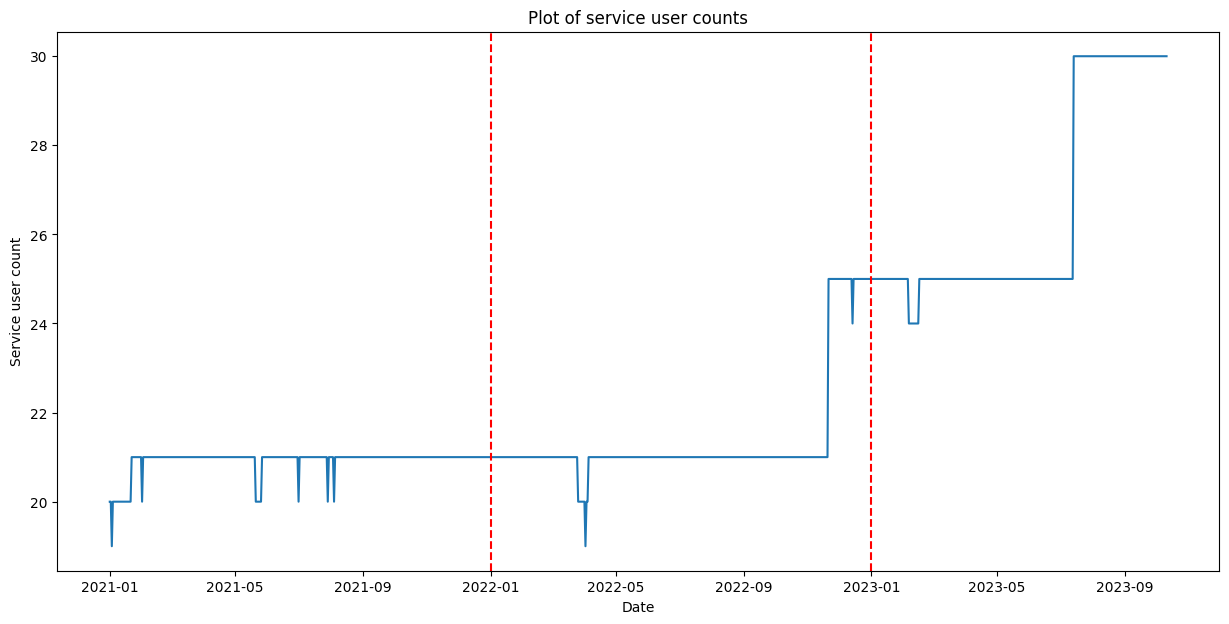

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


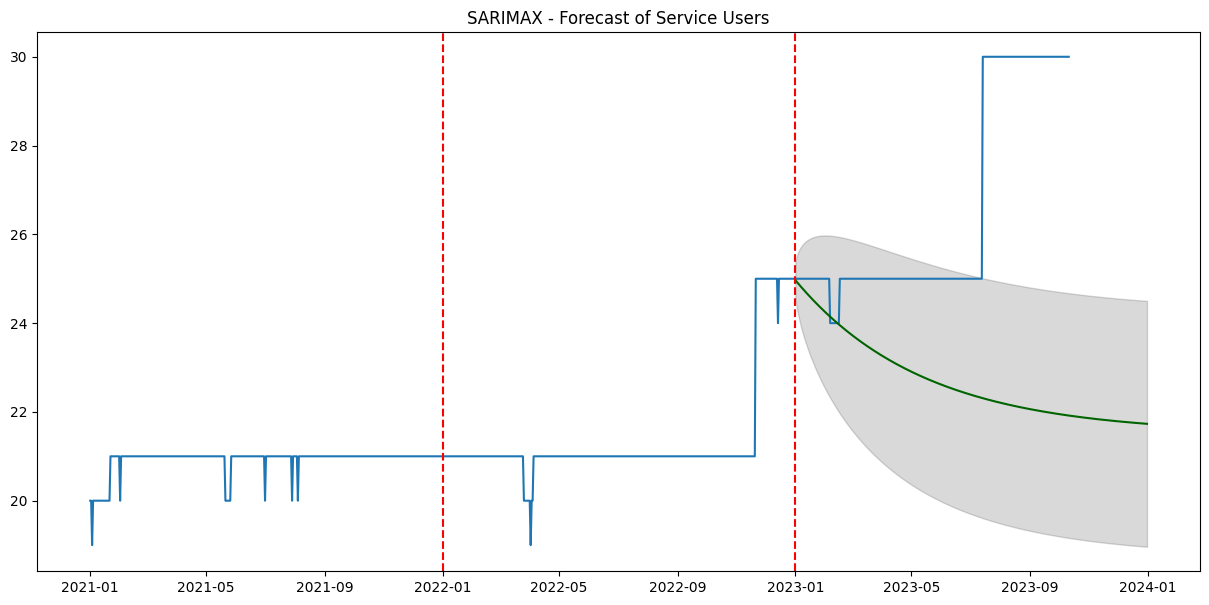

MSE:  22.084117278189233
RMSE:  4.69937413686006
MAE:  3.6149513153239377
Palmerston-Little Italy


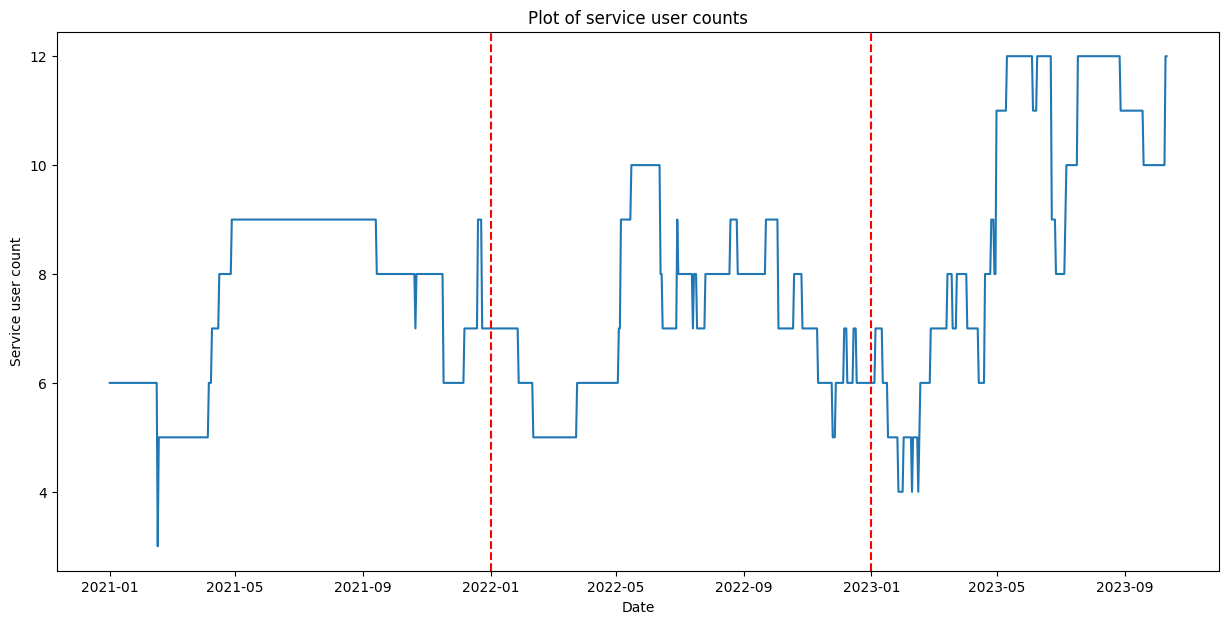

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,0)(0,0,0)[7] intercept


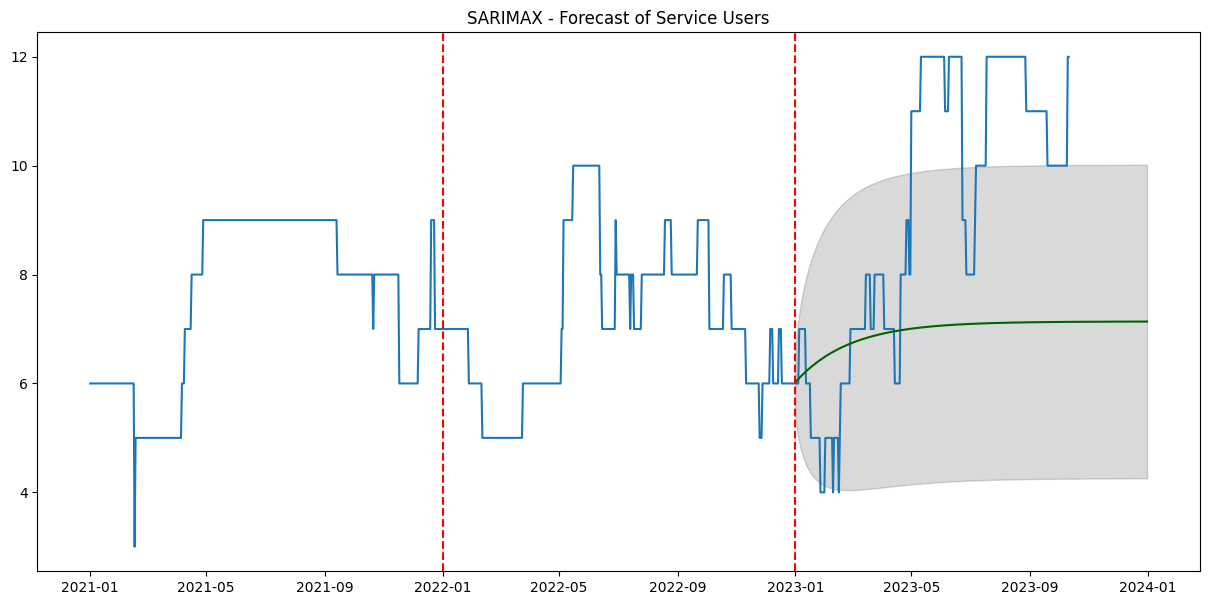

MSE:  10.467240528851539
RMSE:  3.235311504144777
MAE:  2.6839087200601193
Regent Park


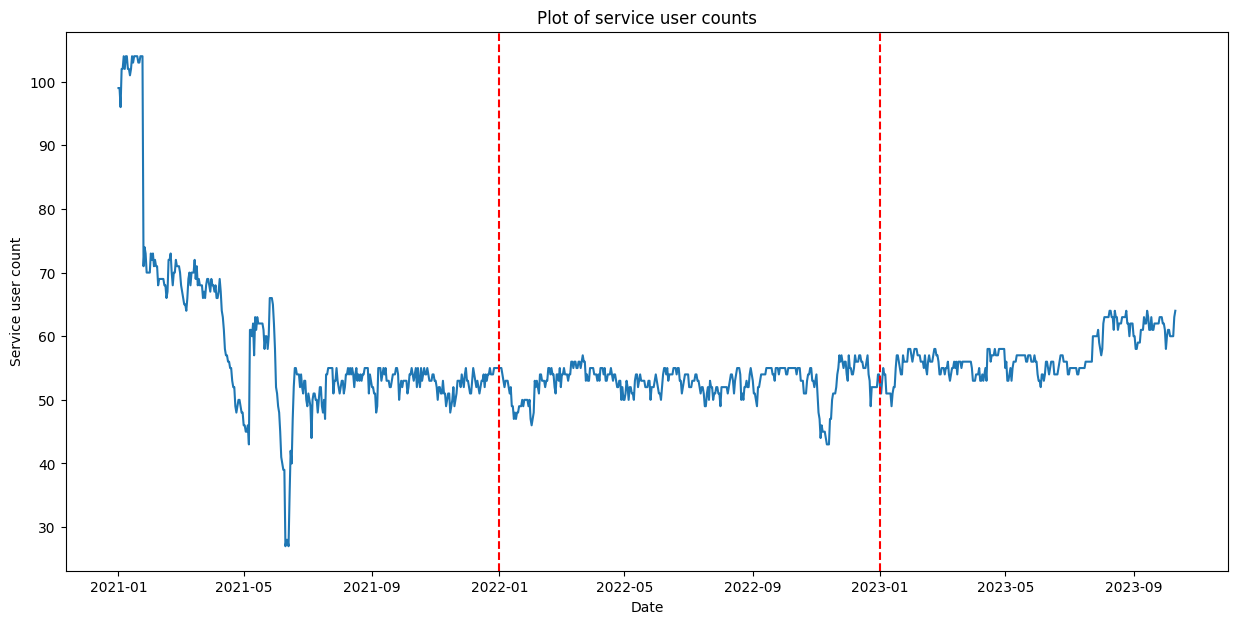

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[7] intercept


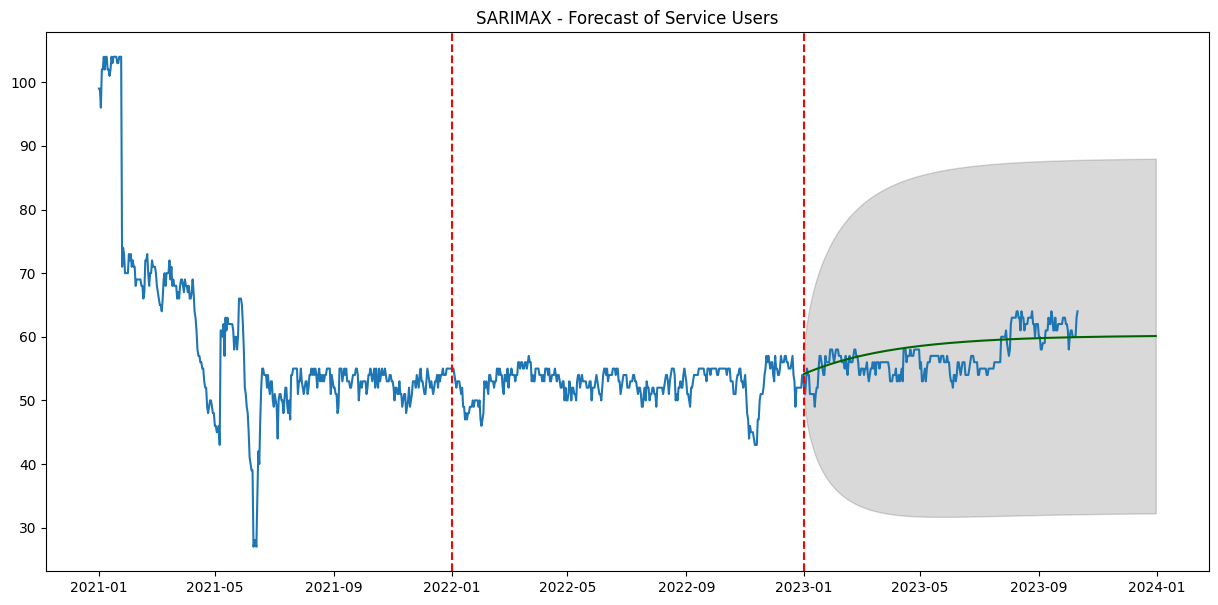

MSE:  8.64793745637289
RMSE:  2.940737570129795
MAE:  2.497086947259923
Rosedale-Moore Park


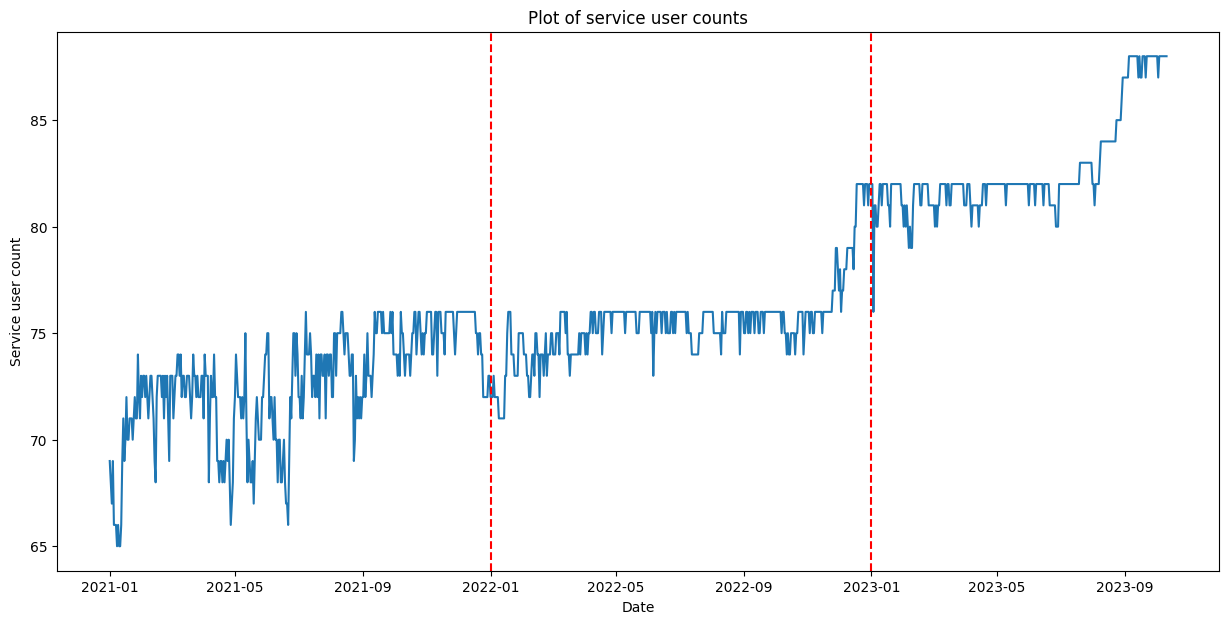

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[7] intercept


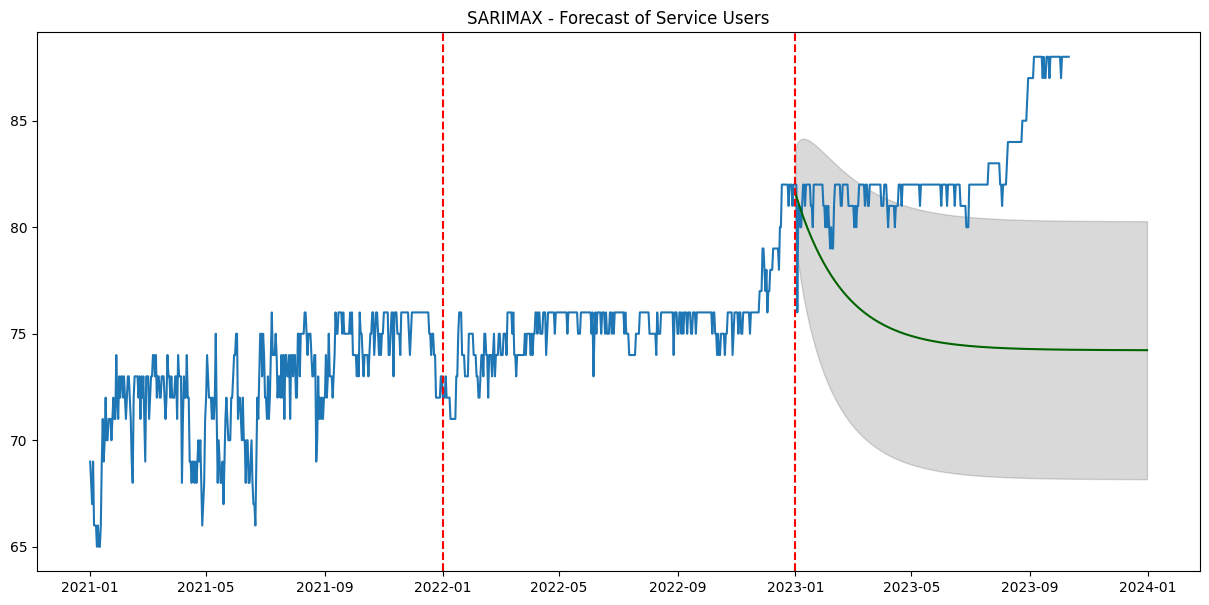

MSE:  64.64308362467631
RMSE:  8.040092264686788
MAE:  7.27901260417778
Scarborough Village


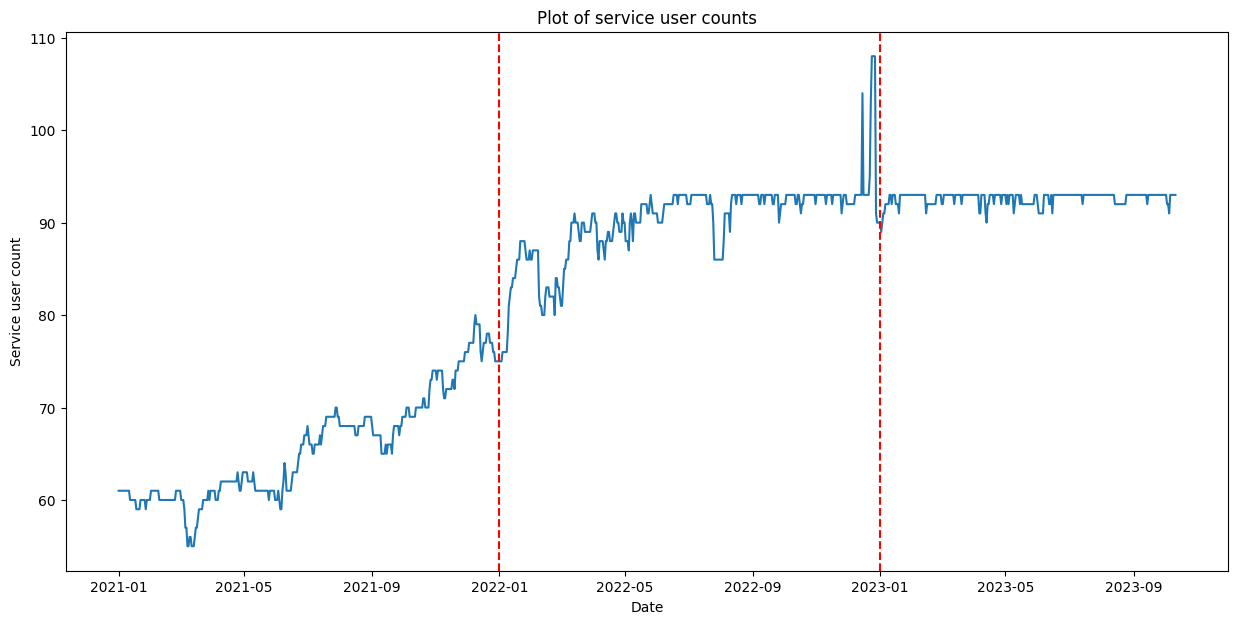

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


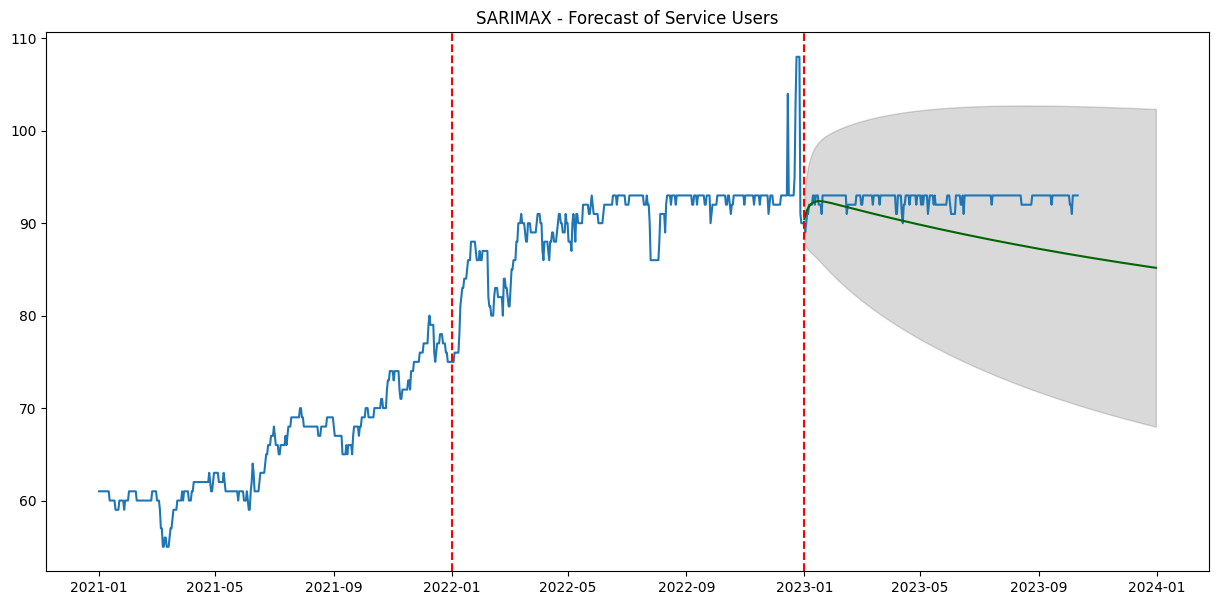

MSE:  14.426699920157297
RMSE:  3.7982495863433328
MAE:  3.2853507387134693
South Parkdale


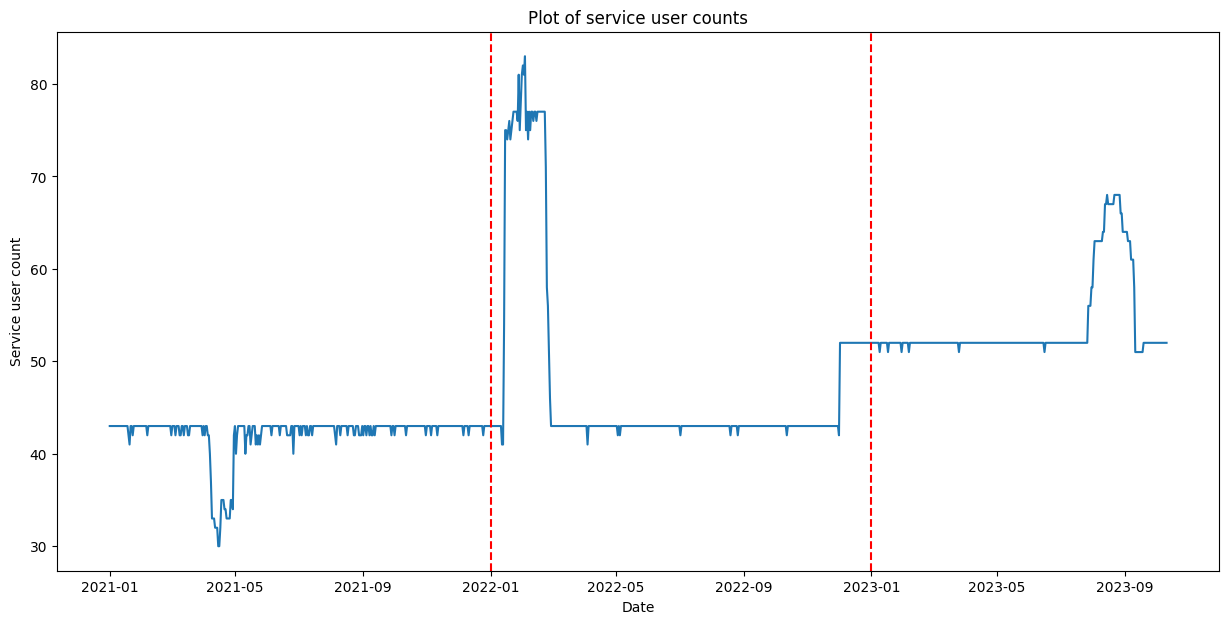

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(3,0,3)(0,0,0)[7] intercept


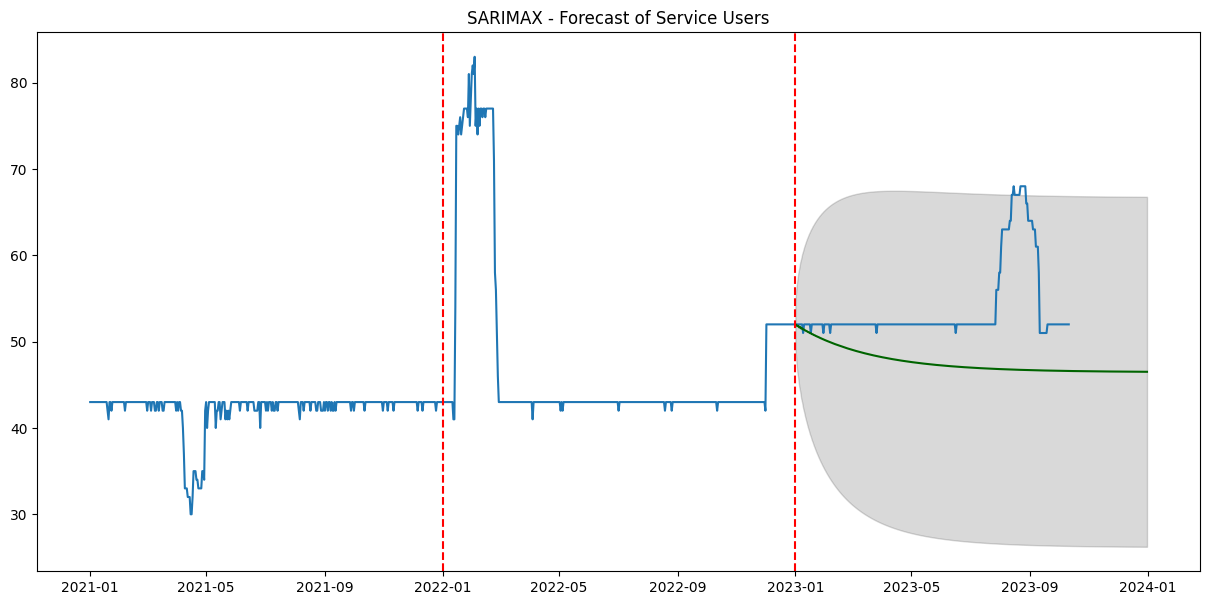

MSE:  61.79282269398046
RMSE:  7.86084109329151
MAE:  5.884473421804848
South Riverdale


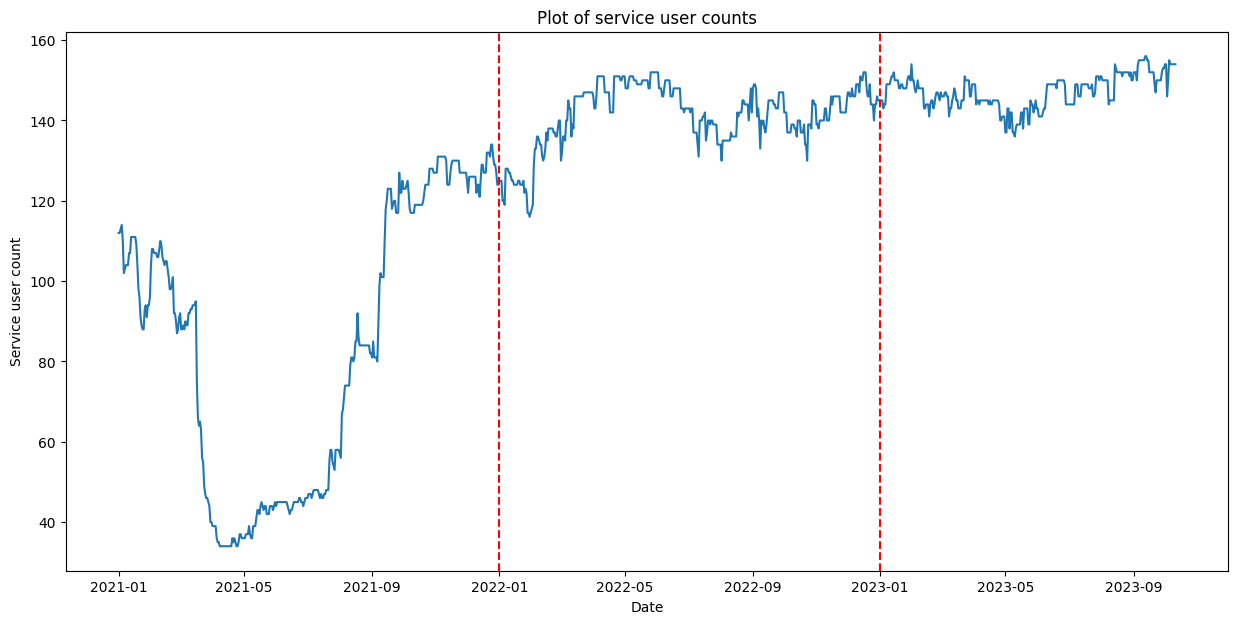

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


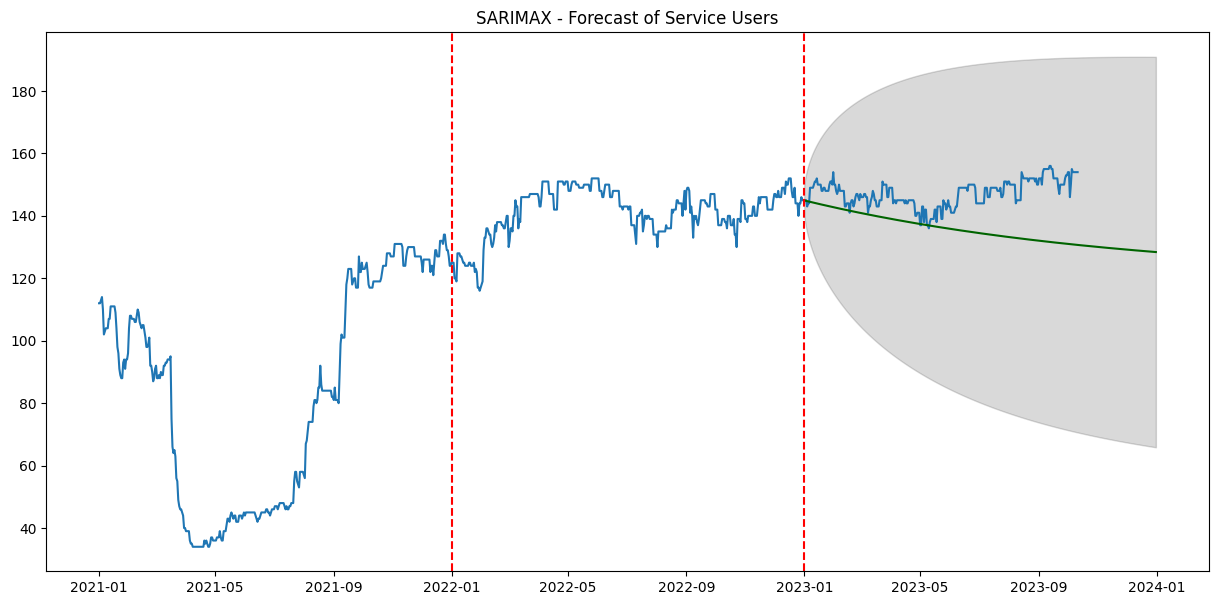

MSE:  155.48440783971924
RMSE:  12.469338708998134
MAE:  10.471998084137923
St Lawrence-East Bayfront-The Islands


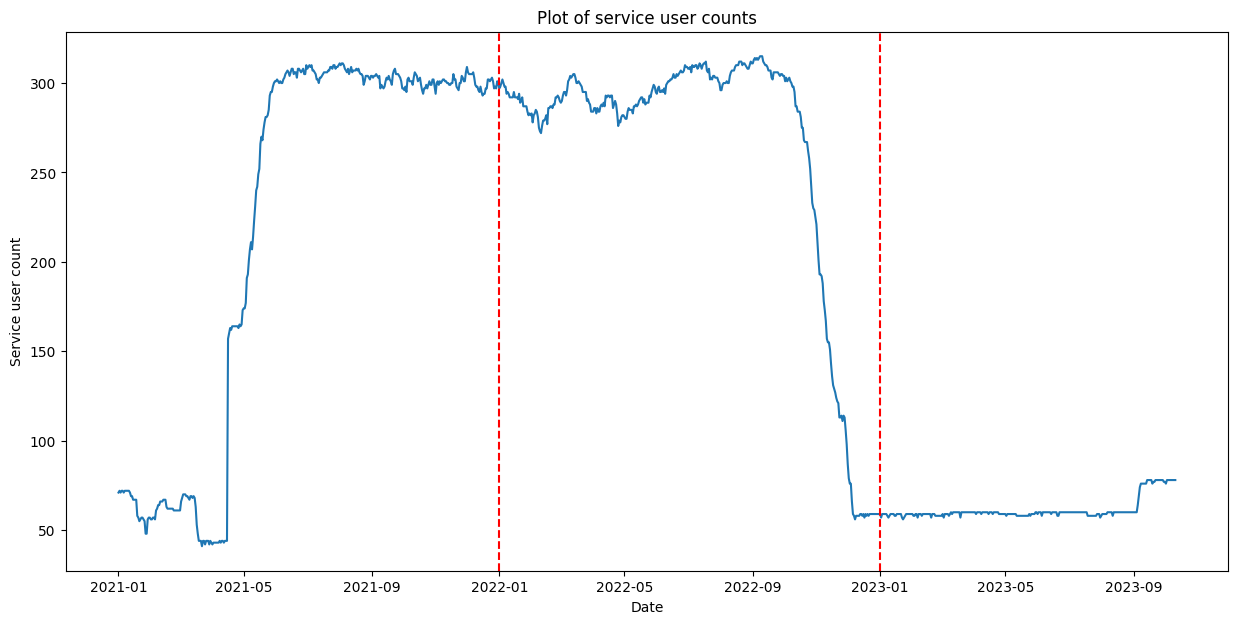

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,2)[7] intercept


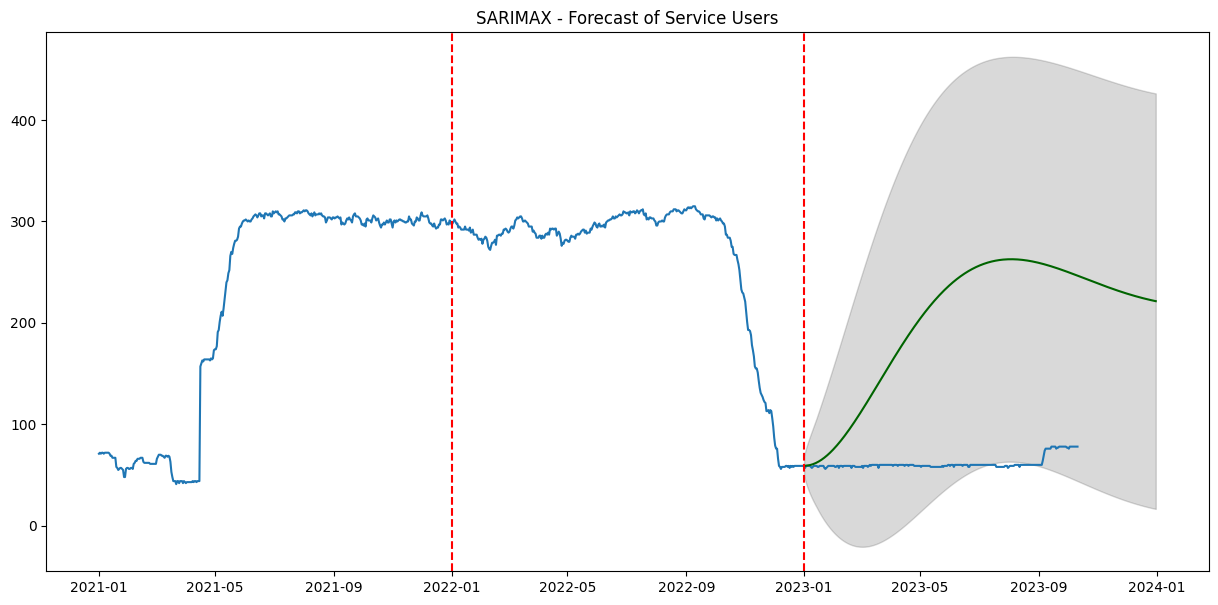

MSE:  22505.612920806794
RMSE:  150.01870856932075
MAE:  132.68735394396603
Thistletown-Beaumond Heights


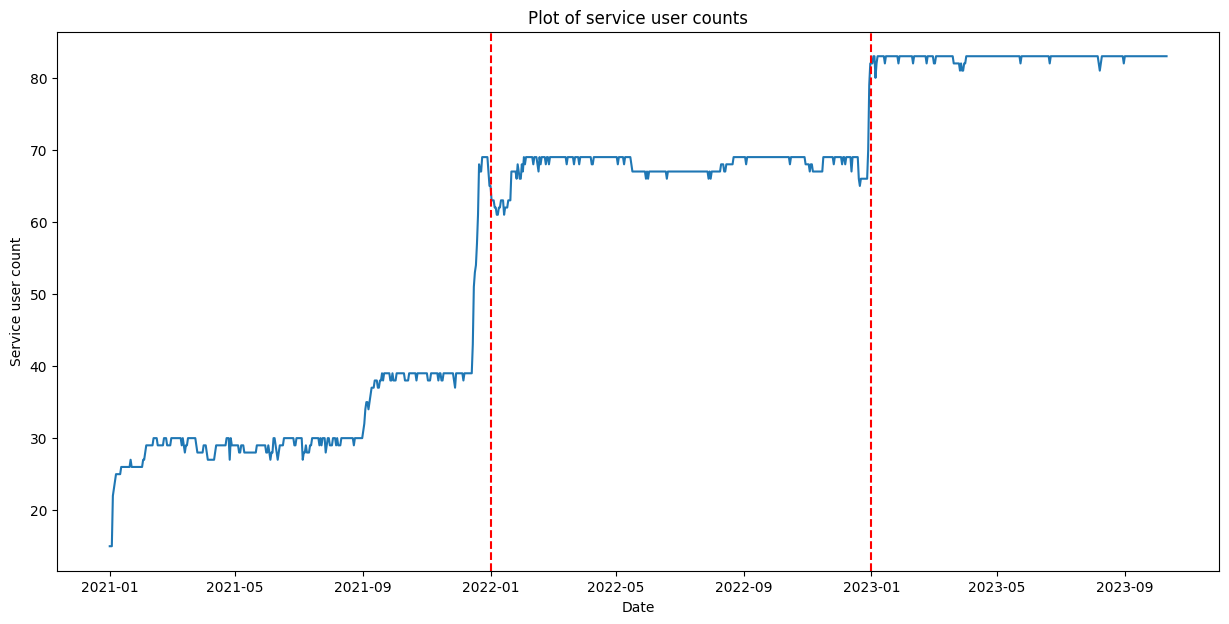

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(1,0,0)[7] intercept


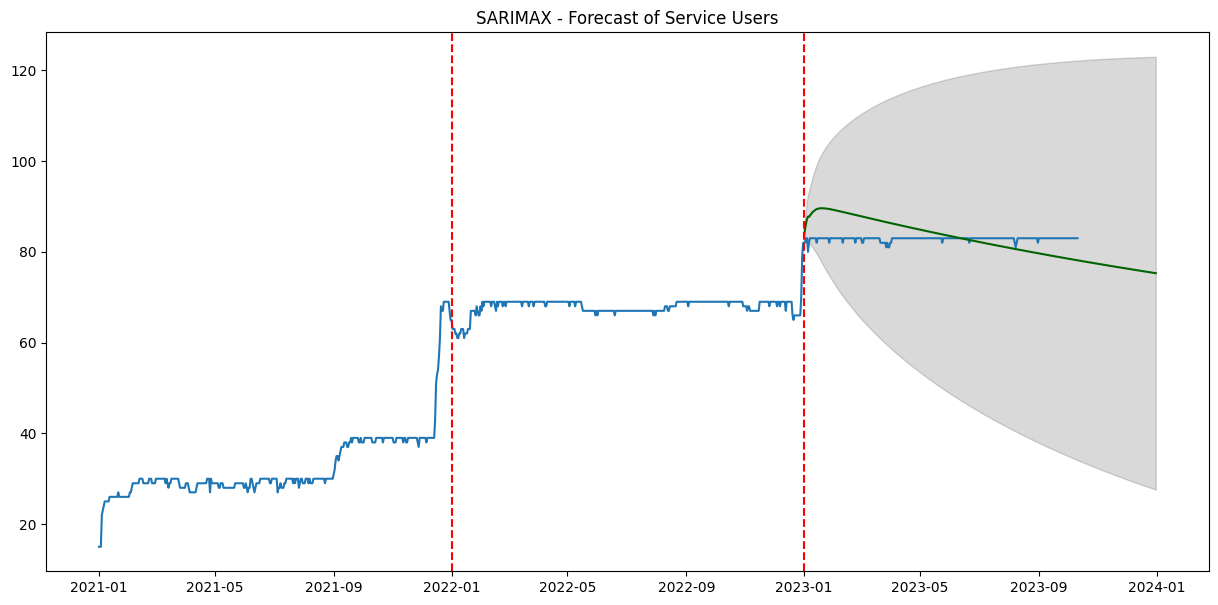

MSE:  13.981802965777284
RMSE:  3.7392249151097188
MAE:  3.190233381770791
University


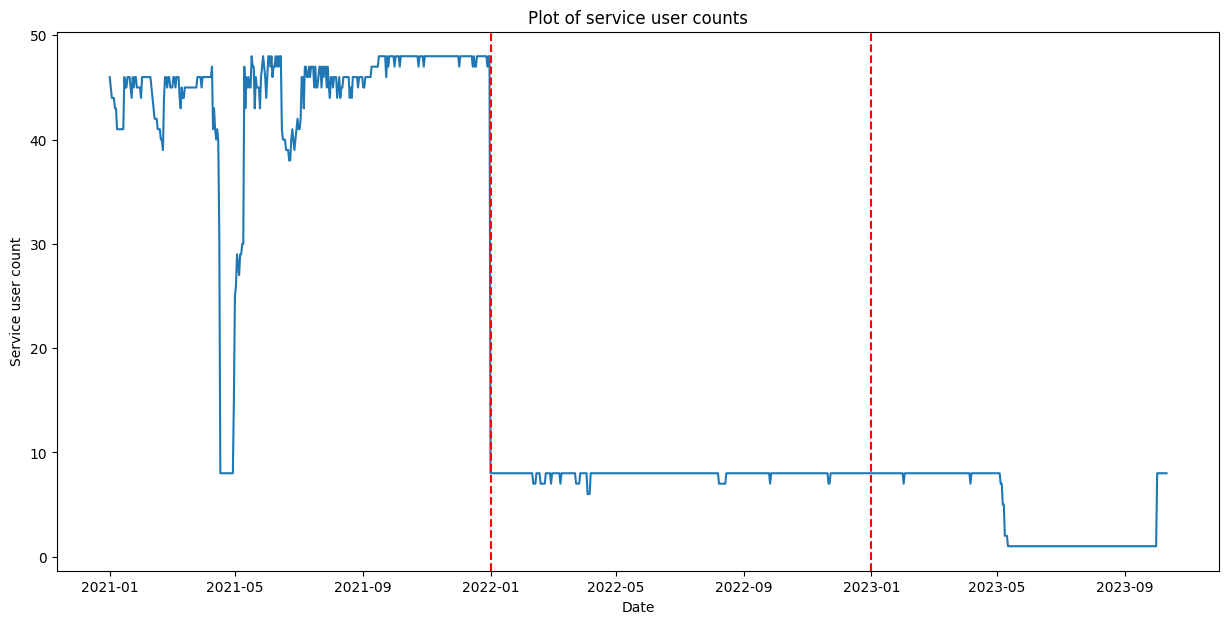

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,2)[7] intercept


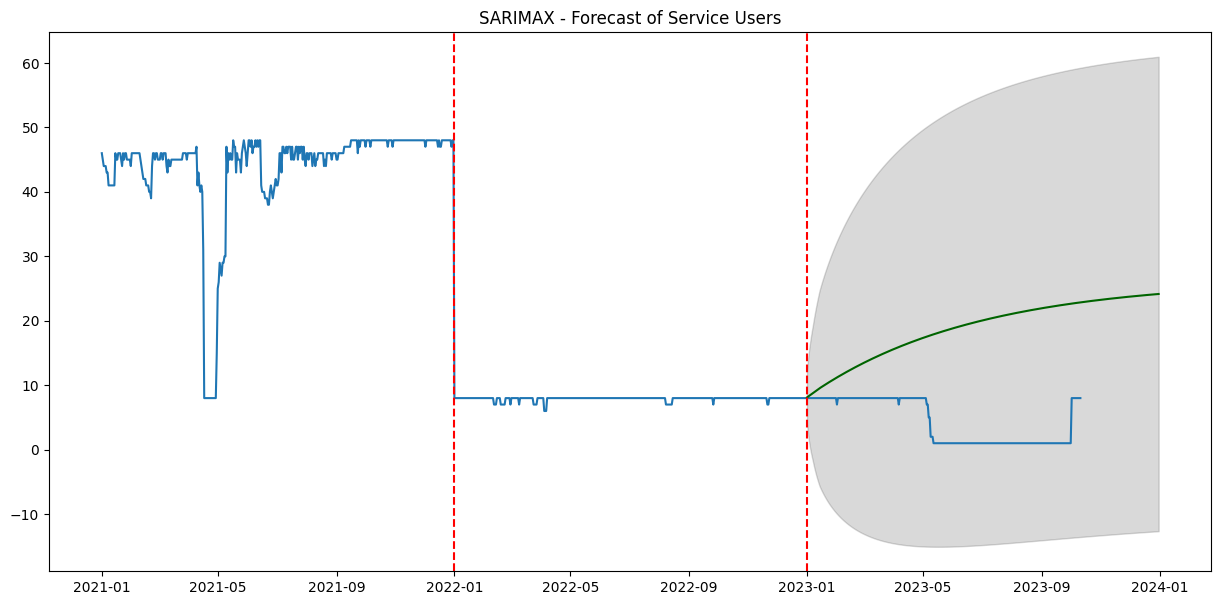

MSE:  222.38709243185323
RMSE:  14.912648739638886
MAE:  13.073791138347946
Wellington Place


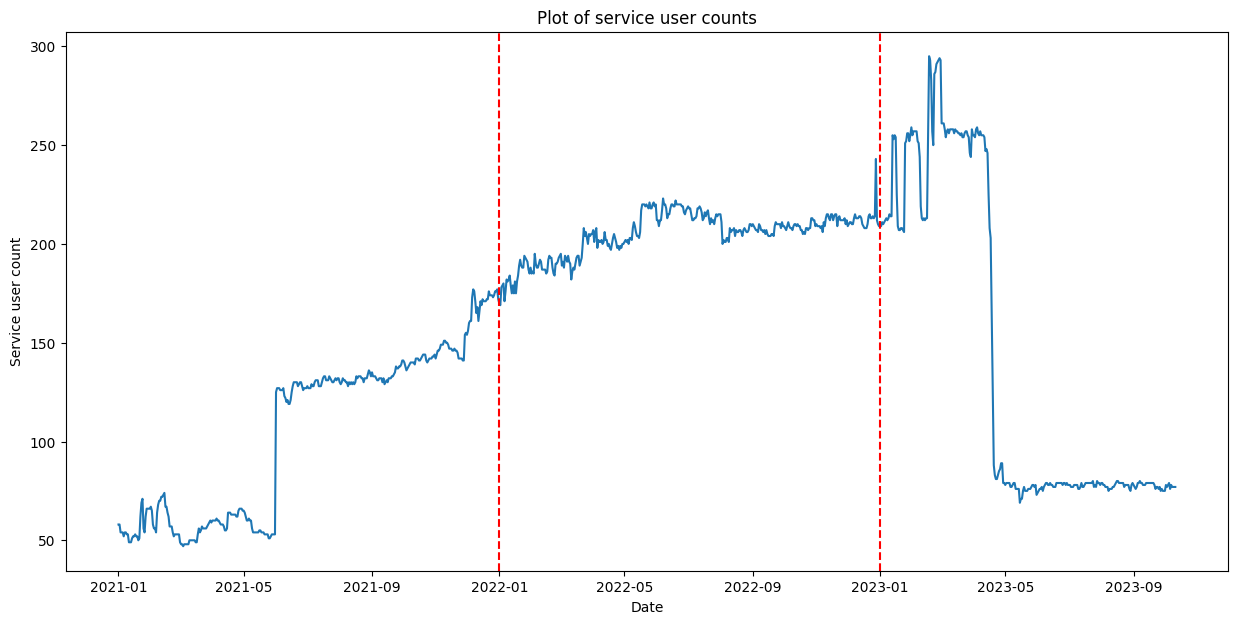

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,1)(0,0,0)[7] intercept


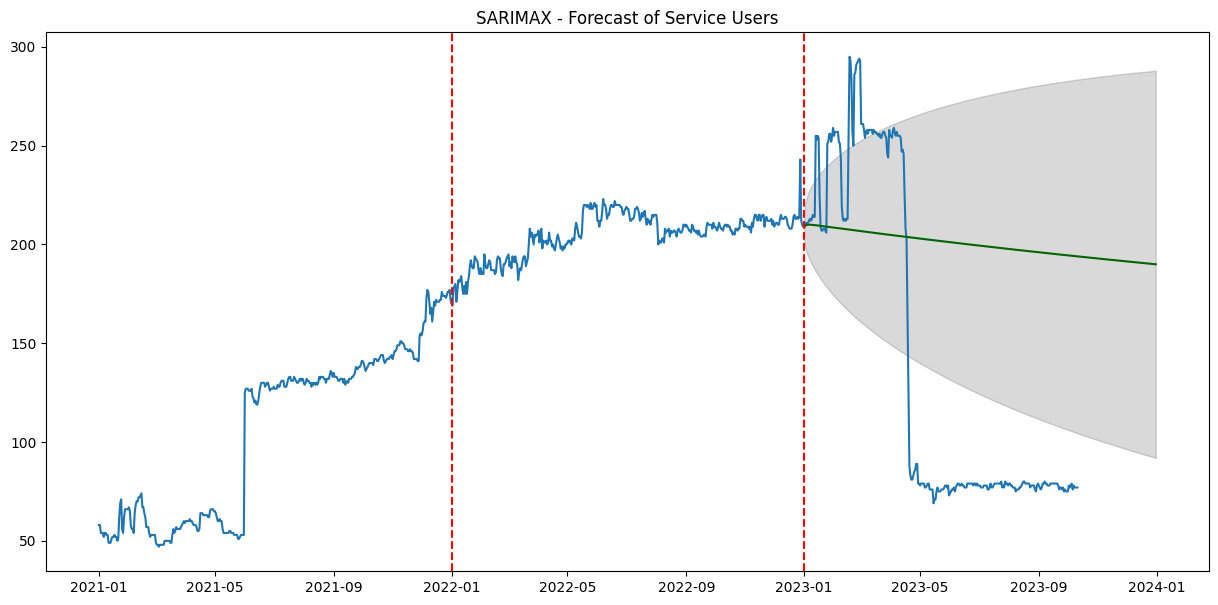

MSE:  9830.122295224255
RMSE:  99.1469732025353
MAE:  89.64495238236739
West Hill


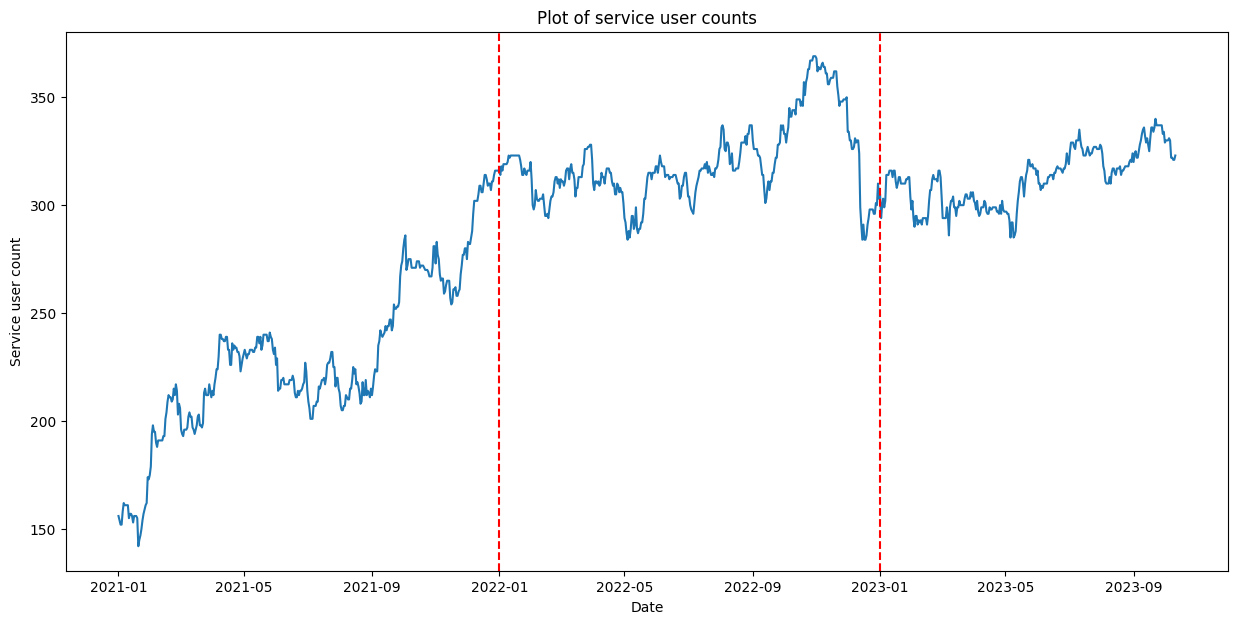

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,2)(0,0,0)[7] intercept


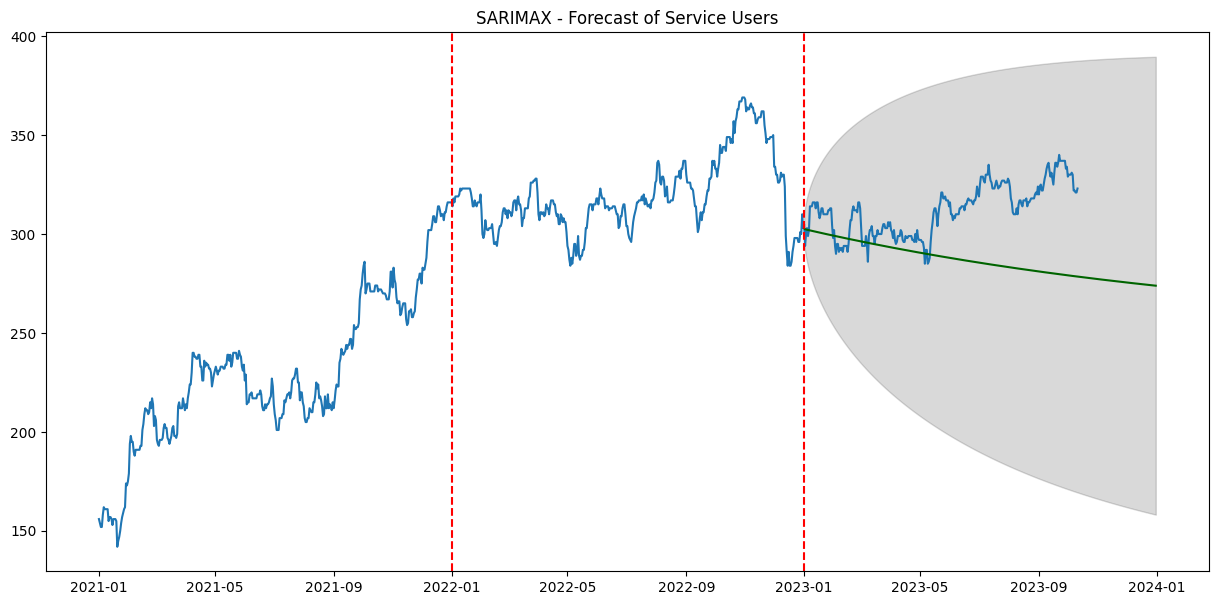

MSE:  856.7903785593791
RMSE:  29.27098185164582
MAE:  23.69081186270192
West Humber-Clairville


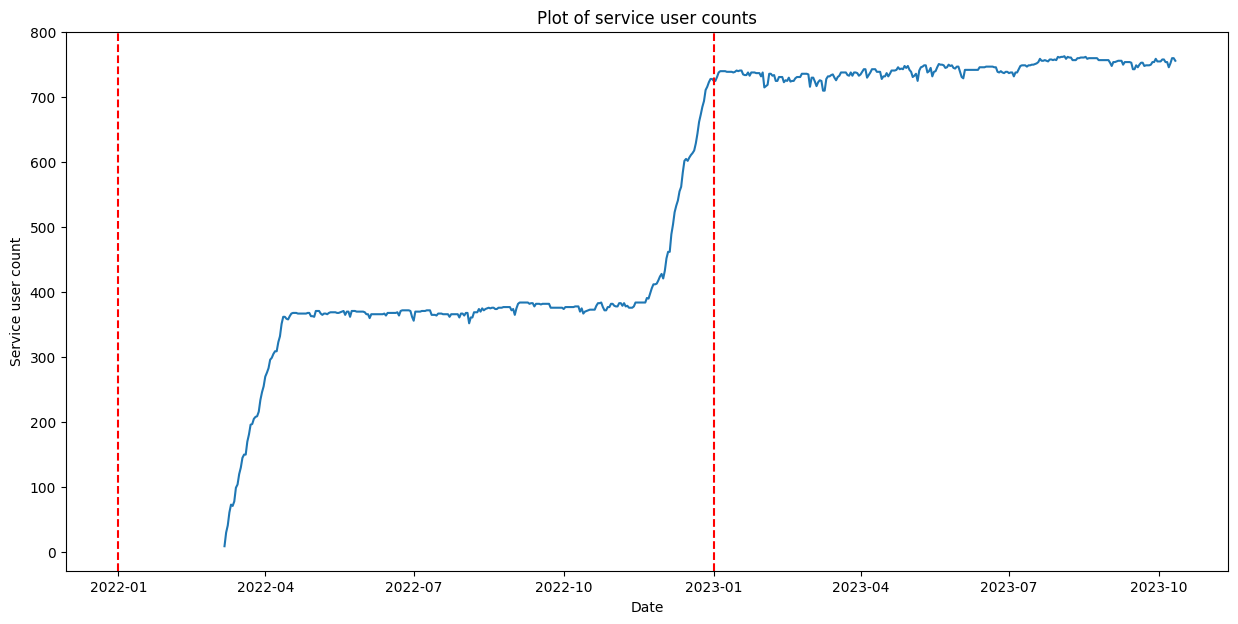

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,3)(0,0,0)[7] intercept


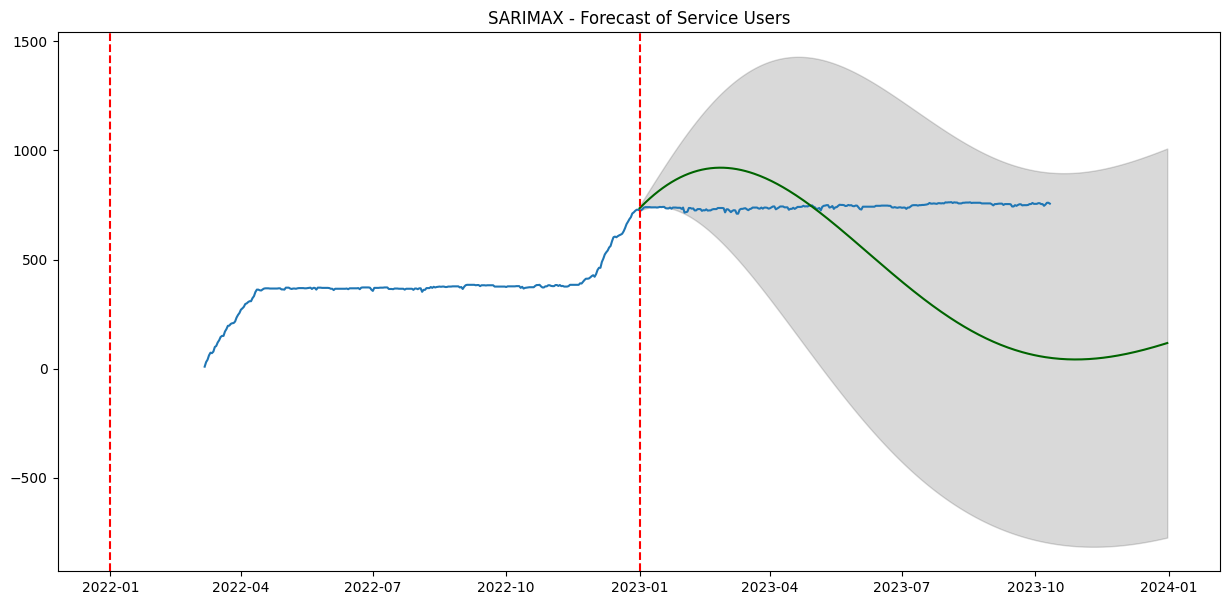

MSE:  138407.87632881533
RMSE:  372.03209045566933
MAE:  295.56372672376904
West Queen West


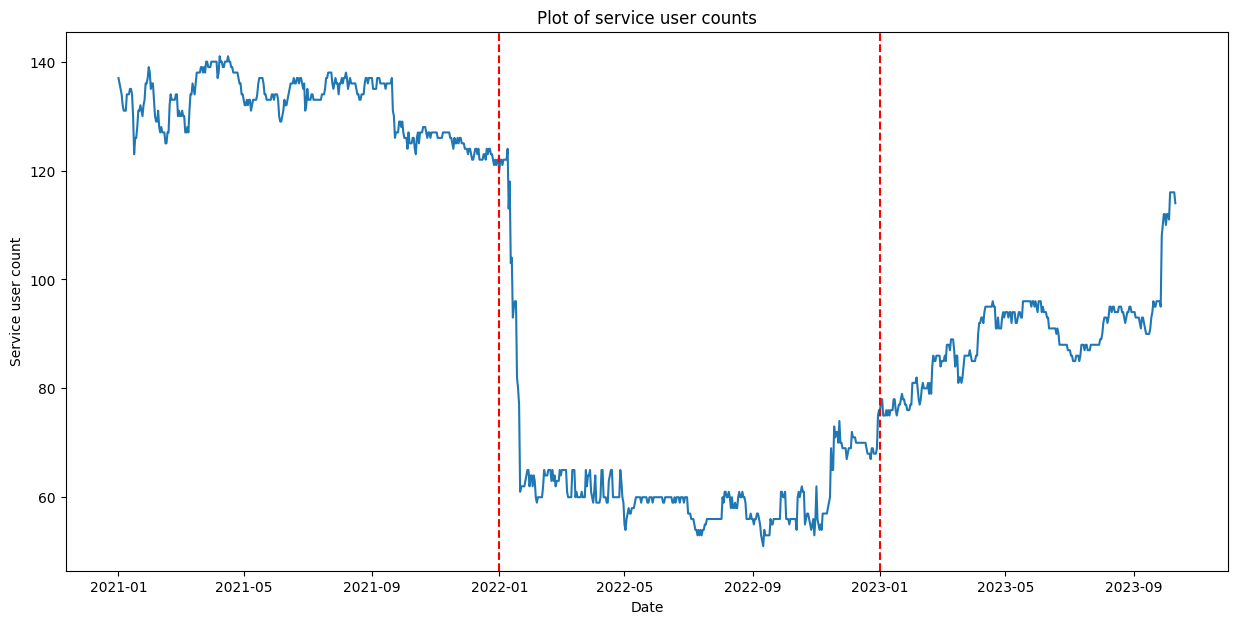

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(3,0,2)(0,0,0)[7] intercept


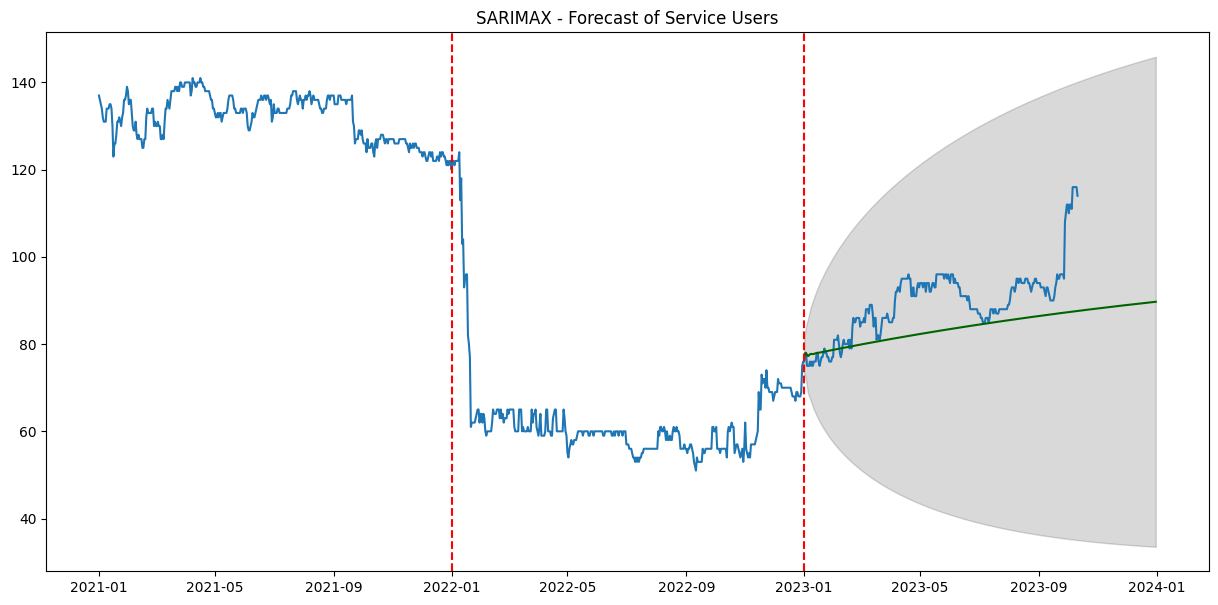

MSE:  82.67919133082583
RMSE:  9.092809869937115
MAE:  7.062651031205637
Wexford/Maryvale


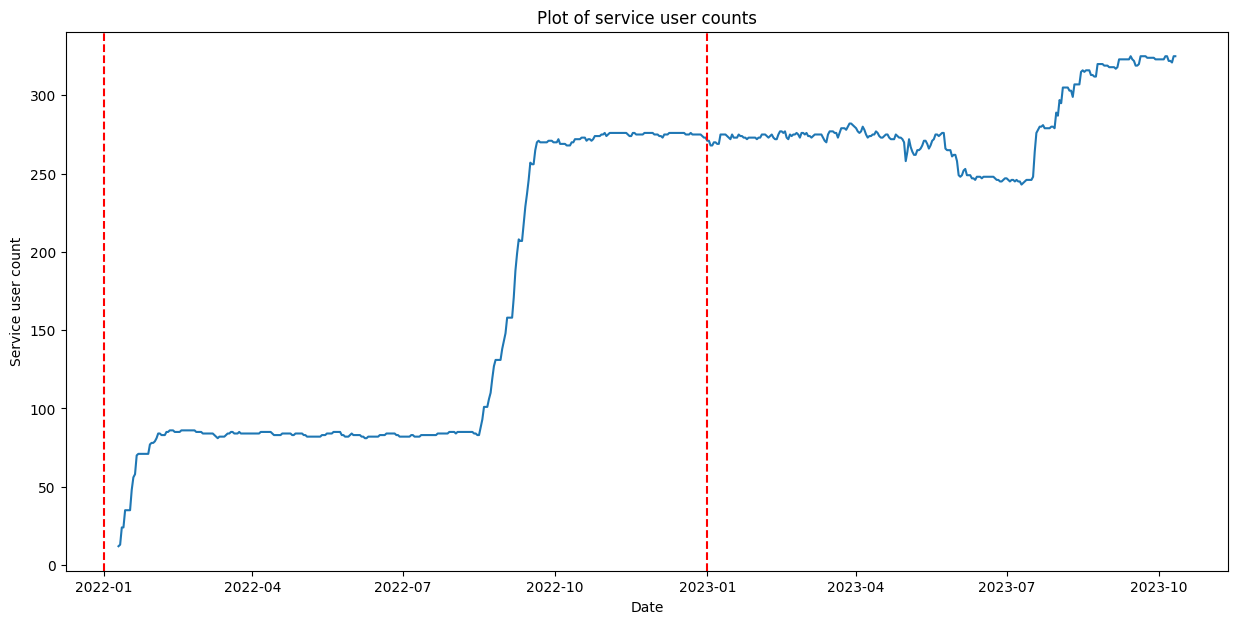

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(1,0,1)[7] intercept


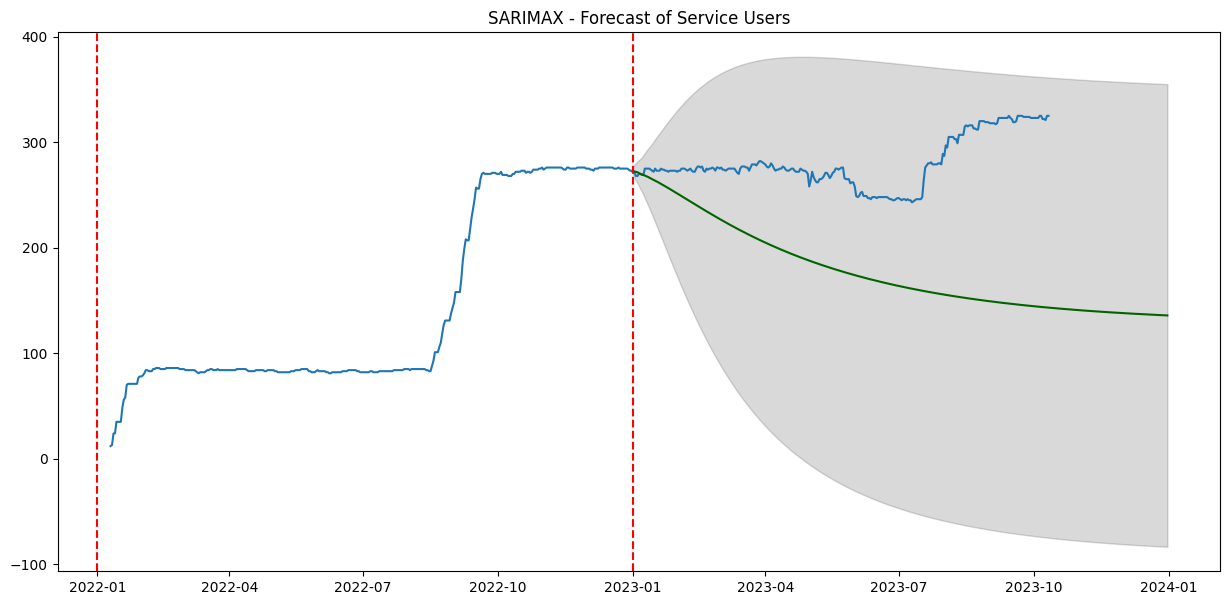

MSE:  11060.08345374362
RMSE:  105.16693136981615
MAE:  90.98457432192043
Woburn North


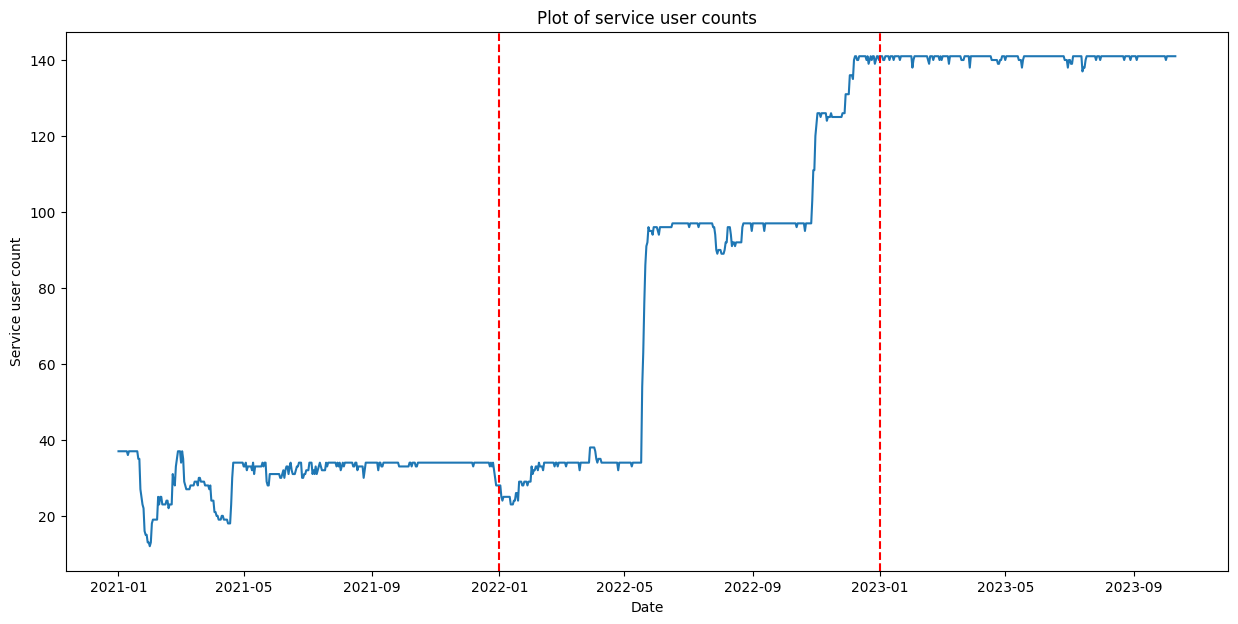

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(2,0,2)(0,0,2)[7] intercept


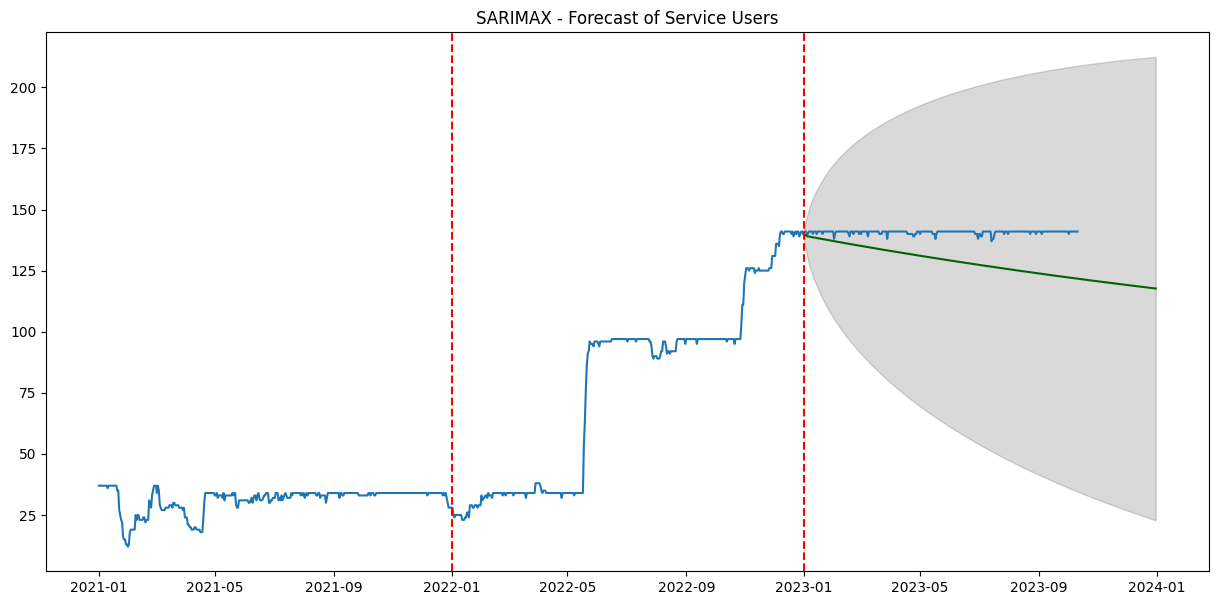

MSE:  142.28944630551226
RMSE:  11.928514002402489
MAE:  10.751730566878214
Wychwood


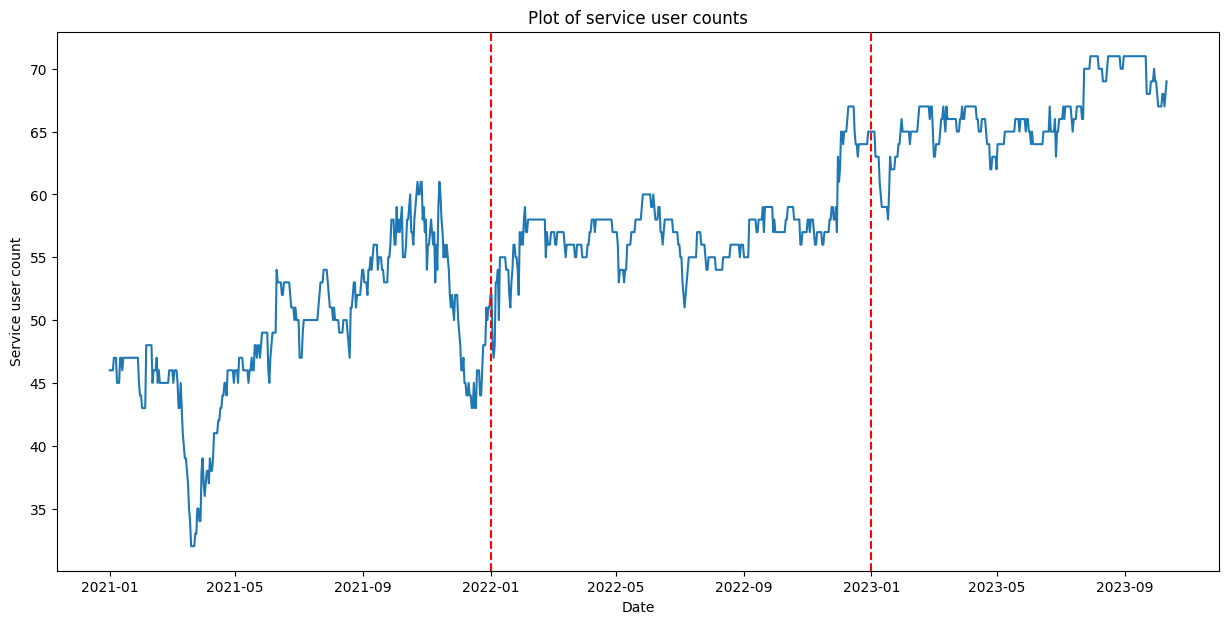

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(0,0,0)[7] intercept


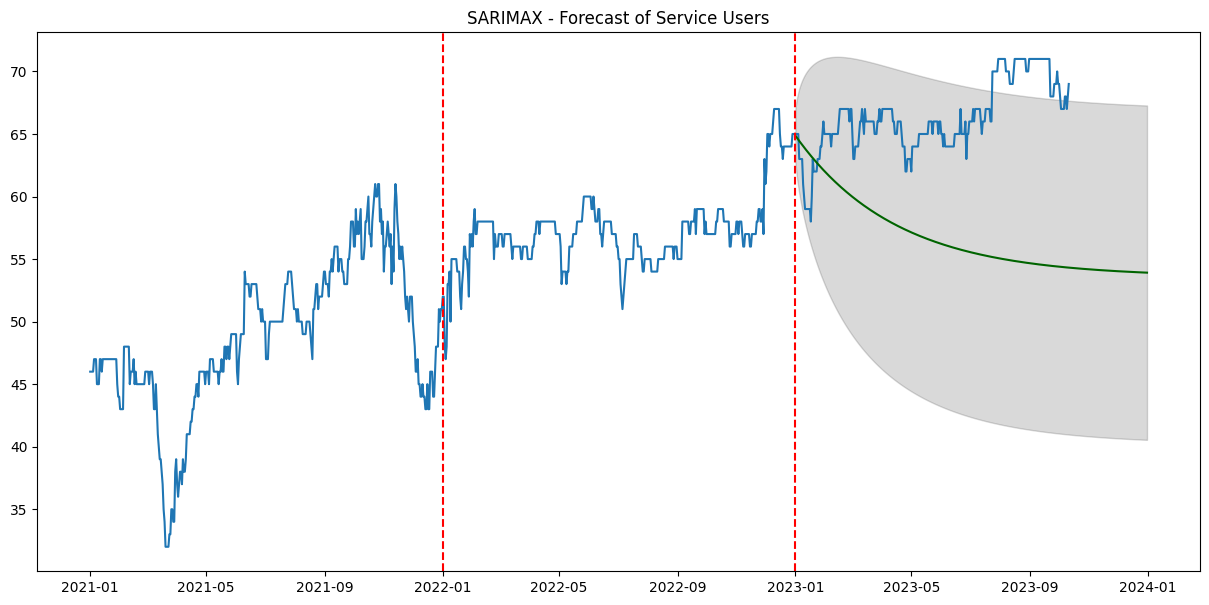

MSE:  107.06600448968109
RMSE:  10.347270388352722
MAE:  9.281337707662042
Yonge-Bay Corridor


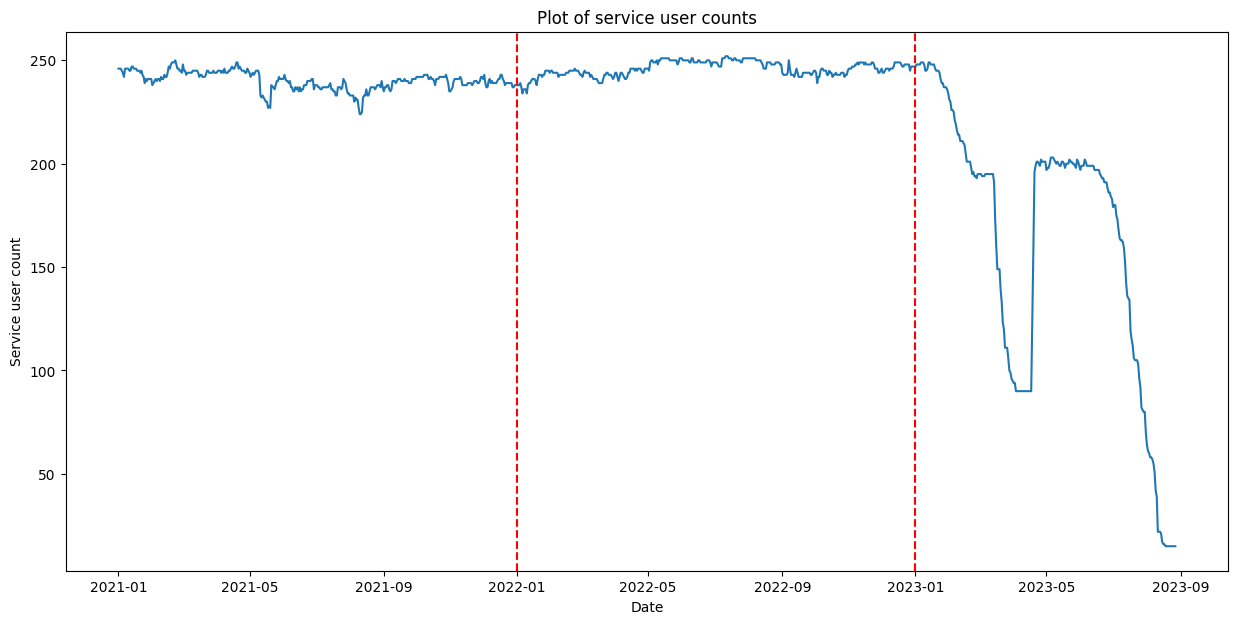

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,0)(0,0,1)[7] intercept


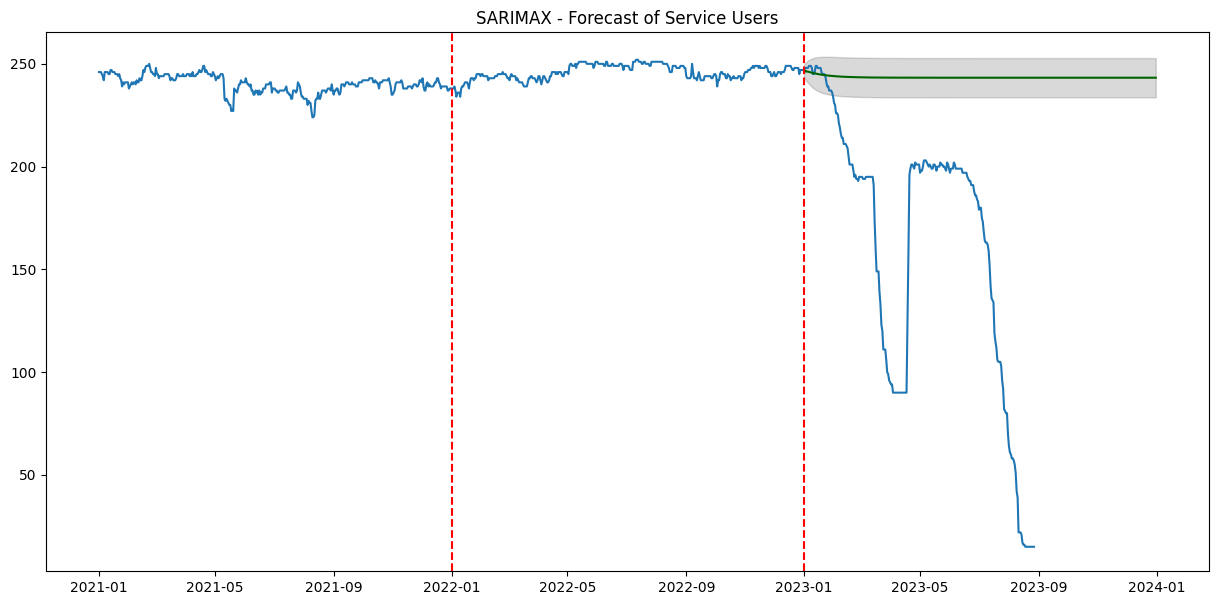

MSE:  10687.335874922015
RMSE:  103.37957184532162
MAE:  79.87622523944967
Yorkdale-Glen Park


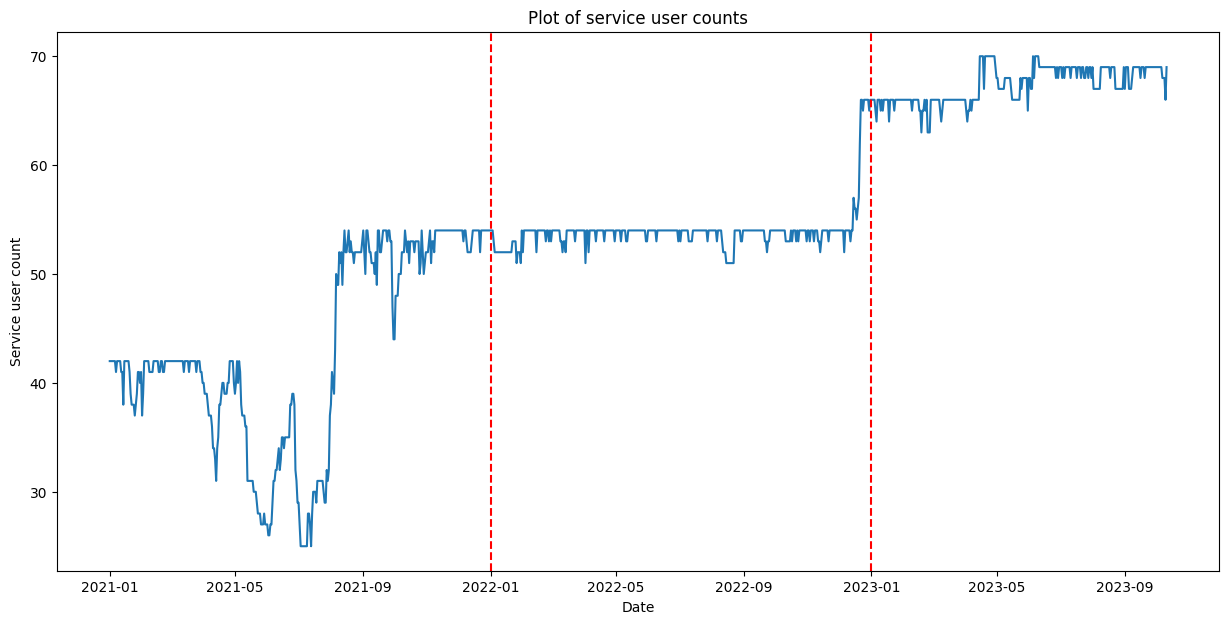

c:\Users\miche\AppData\Local\Programs\Python\Python312\Lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


 ARIMA(1,0,1)(1,0,1)[7] intercept


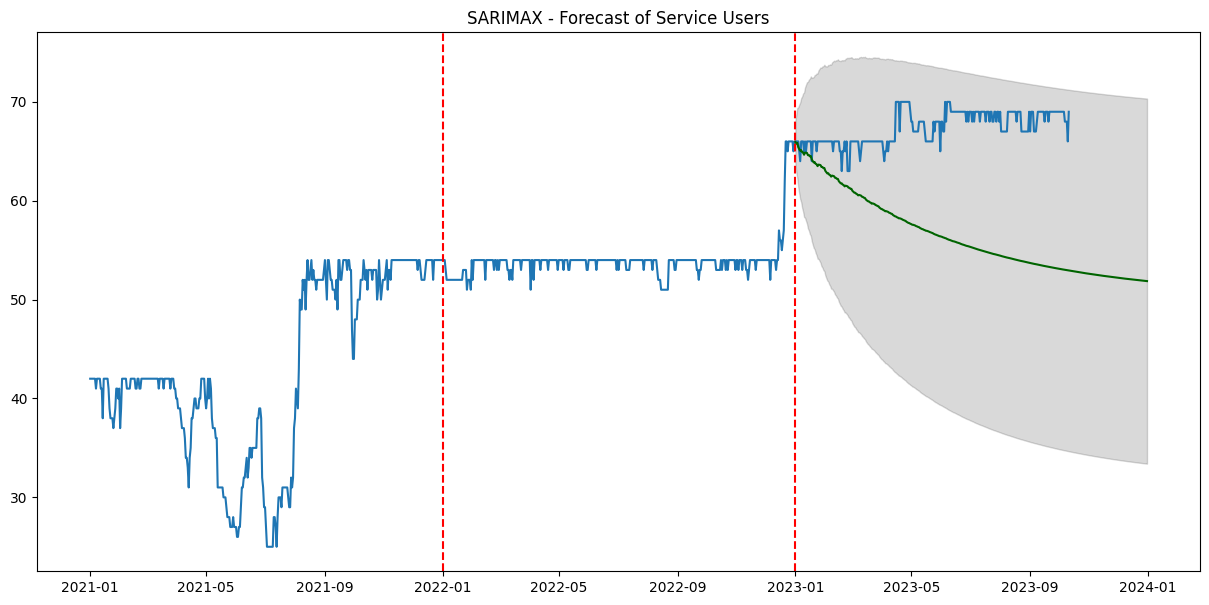

MSE:  120.43310821845625
RMSE:  10.974201939934233
MAE:  9.82072818893919


In [53]:
# List of Neighbourhoods
neighbourhoods = np.sort(data["Neighbourhood"].unique())
# print(neighbourhoods)

# remove these neighbourhoods as they seem to have shelters removed
neighbourhoodsRemove = np.array(["Downsview", # missing data
                                 "St.Andrew-Windfields", # missing data
                                 "Trinity-Bellwoods", "Willowdale West", "Woodbine Corridor", "East Willowdale" , "Yonge-Doris"])
mask = ~np.isin(neighbourhoods, neighbourhoodsRemove)
neighbourhoods = neighbourhoods[mask]

# Conduct Analysis for each of the neighbourhoods
Eval_values = pd.DataFrame(columns=["Neighbourhood", "MSE", "RMSE" "MAE"])

for neighbourhood in neighbourhoods:
    print(neighbourhood)
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    plotData(dataN, testN, trainN)
    SARIMAX_model = timeseriesModel(trainN)
    fitted_series, lower_series, upper_series = plotTimeseries(SARIMAX_model, dataN, trainN, testN)
    mse, rmse, mae = calcEval(testN["SERVICE_USER_COUNT"], fitted_series)
    dataEval = [[neighbourhood, mse, rmse, mae]]
    valueEval = pd.DataFrame(dataEval, columns=["Neighbourhood", "MSE", "RMSE", "MAE"])
    Eval_values = pd.concat([Eval_values, valueEval])


In [45]:
Eval_values = Eval_values.drop(columns=["RMSEMAE"])
Eval_values

Neighbourhood           MSE        RMSE         MAE
0                                  Annex    779.365572   27.917120   22.531401
0                    Bendale-Glen Andrew    499.665495   22.353199   20.942907
0                        Broadview North      3.218956    1.794145    1.649021
0                     Caledonia-Fairbank    243.069941   15.590700   13.324777
0                       Church-Wellesley    107.900446   10.387514    7.140427
0                     Dovercourt Village     76.741355    8.760214    6.842641
0                    Downtown Yonge East    291.605690   17.076466   13.610686
0                      East End-Danforth    117.947222   10.860351    9.397533
0              Fort York-Liberty Village   1528.152248   39.091588   35.420074
0                 Harbourfront-CityPlace  12888.244215  113.526403  109.325450
0                      High Park-Swansea      0.259032    0.508952    0.494409
0                      Hillcrest Village    312.862412   17.687917   15.845097
0                          Junction Area   1284.631080   35.841751   34.165650
0               Junction-Wallace Emerson     41.945012    6.476497    5.918103
0                           Kennedy Park    482.922975   21.975509   20.282774
0                   Kensington-Chinatown    713.959509   26.720021   22.939424
0                        Little Portugal     15.443730    3.929851    3.820101
0                       Mimico-Queensway     51.255496    7.159294    6.036305
0                              Moss Park   6215.761097   78.840098   67.192517
0                       Newtonbrook East     10.459468    3.234110    2.728803
0                    North St.James Town      7.197170    2.682754    2.449845
0                          North Toronto   1018.803092   31.918695   21.205985
0                        Oakwood Village     22.084117    4.699374    3.614951
0                Palmerston-Little Italy     10.467241    3.235312    2.683909
0                            Regent Park      8.647937    2.940738    2.497087
0                    Rosedale-Moore Park     64.643084    8.040092    7.279013
0                    Scarborough Village      1.597882    1.264074    1.052199
0                         South Parkdale     82.161177    9.064280    7.379533
0                        South Riverdale    155.484408   12.469339   10.471998
0  St Lawrence-East Bayfront-The Islands  21173.104710  145.509810  128.164227
0           Thistletown-Beaumond Heights     16.560573    4.069468    3.426501
0                             University    236.087771   15.365148   13.522518
0                       Wellington Place   9830.122295   99.146973   89.644952
0                              West Hill    856.790379   29.270982   23.690812
0                 West Humber-Clairville  62001.056841  249.000114  213.676473
0                        West Queen West     82.679191    9.092810    7.062651
0                       Wexford/Maryvale  16882.678786  129.933363  114.146676
0                           Woburn North    135.449765   11.638289   10.456107
0                               Wychwood    107.066004   10.347270    9.281338
0                     Yonge-Bay Corridor  10745.656191  103.661257   80.301099
0                     Yorkdale-Glen Park    114.181608   10.685579    9.528901

In [46]:
# Find the average MSE, RMSE and MAE
print("MSE :", np.mean(Eval_values["MSE"]))
print("RMSE :", np.mean(Eval_values["RMSE"]))
print("MAE", np.mean(Eval_values["MAE"]))

MSE : 3639.461735989639
RMSE : 33.262620020460204
MAE 28.808411612056556


In [32]:
# if we eliminated 2 major outliers 
Eval_exc = Eval_values[Eval_values["Neighbourhood"] != "West Humber-Clairville"]  # less than 1 year testing data and huge jump present - from 0 - 700 users
Eval_exc = Eval_exc[Eval_exc["Neighbourhood"] != "Wexford/Maryvale"]  # less than 1 year of data present and huge jump present - from 0 - 300+
Eval_exc

Neighbourhood           MSE        RMSE         MAE
0                                  Annex     37.833295    6.150878    5.126089
0                    Bendale-Glen Andrew    499.665495   22.353199   20.942907
0                        Broadview North     23.070394    4.803165    4.429850
0                     Caledonia-Fairbank     54.947183    7.412637    3.742958
0                       Church-Wellesley     42.894390    6.549381    3.657162
0                     Dovercourt Village    121.072574   11.003298    7.663521
0                    Downtown Yonge East    327.366197   18.093264   14.577465
0                      East End-Danforth     14.204225    3.768849    1.915493
0              Fort York-Liberty Village     14.376262    3.791604    2.878094
0                 Harbourfront-CityPlace    205.000242   14.317830   10.076959
0                      High Park-Swansea      0.872412    0.934030    0.872885
0                      Hillcrest Village    312.862412   17.687917   15.845097
0                          Junction Area    570.912580   23.893777   22.594843
0               Junction-Wallace Emerson      0.408451    0.639101    0.274648
0                           Kennedy Park    409.250832   20.229949   18.596068
0                   Kensington-Chinatown     66.390845    8.148058    6.130282
0                        Little Portugal     15.443730    3.929851    3.820101
0                       Mimico-Queensway     11.878442    3.446512    2.063458
0                              Moss Park   1543.506970   39.287491   29.188465
0                       Newtonbrook East      6.683150    2.585179    2.049308
0                    North St.James Town      7.197170    2.682754    2.449845
0                          North Toronto   1018.803092   31.918695   21.205985
0                        Oakwood Village      7.957746    2.820948    1.619718
0                Palmerston-Little Italy     16.387324    4.048126    3.394366
0                            Regent Park      8.647937    2.940738    2.497087
0                    Rosedale-Moore Park     64.643084    8.040092    7.279013
0                    Scarborough Village     87.471717    9.352632    8.460719
0                         South Parkdale     24.003521    4.899339    1.919014
0                        South Riverdale     22.676056    4.761938    3.838028
0  St Lawrence-East Bayfront-The Islands    385.677992   19.638686   17.879161
0           Thistletown-Beaumond Heights    582.913622   24.143604   22.436175
0                             University     25.130282    5.013011    3.623239
0                       Wellington Place  19499.547428  139.640780  118.792204
0                              West Hill    257.926079   16.060077   13.214086
0                        West Queen West    229.785678   15.158683   12.957589
0                           Woburn North      2.688275    1.639596    1.588906
0                               Wychwood      9.955207    3.155187    2.336188
0                     Yonge-Bay Corridor  10697.468750  103.428568   79.942259
0                     Yorkdale-Glen Park      4.836325    2.199165    1.715677

In [33]:
# Find the average MSE, RMSE and MAE
print("MSE :", np.mean(Eval_exc["MSE"]))
print("RMSE :", np.mean(Eval_exc["RMSE"]))
print("MAE", np.mean(Eval_exc["MAE"]))

MSE : 954.6758299812407
RMSE : 15.912015108911456
MAE 12.912690061544252


TESTING FUNCTIONS

In [ ]:
# Generate a date range with the expected frequency
for neighbourhood in neighbourhoods: 
    dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
    df = trainN
    expected_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

    # Find missing dates
    missing_dates = expected_date_range[~expected_date_range.isin(df.index)]

    # Display missing dates
    if not missing_dates.empty:
        print(neighbourhood, missing_dates)
        # else:
        #     print("No missing dates.")

In [ ]:
neighbourhood = "Annex"
dataN, testN, trainN = subsetNeighbourhood(data1_exo, test1, train1, neighbourhood)
plotData(dataN, testN, trainN)
SARIMAX_model = timeseriesModel(trainN)
fitted_series, lower_series, upper_series = plotTimeseries(SARIMAX_model, dataN, trainN, testN)
print(fitted_series)
mse, rmse, mae = calcEval(testN["SERVICE_USER_COUNT"], fitted_series)
dataEval = [[neighbourhood, mse, rmse, mae]]
valueEval = pd.DataFrame(dataEval, columns=["Neighbourhood", "MSE", "RMSE", "MAE"])
# Eval_values = pd.concat([Eval_values, valueEval])

In [ ]:
# Forecast
df = trainN
all = dataN
n_periods = 365

# get indices for new dataframe
forecast_df = pd.DataFrame({"day_index":pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D').day},
                index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))


index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

# get predictions and confidence intervals
fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                        return_conf_int=True,
                                        index = index_of_fc
                                        )

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

Extract for 1 City - test Annex

In [40]:
# extract city specific data
data_Annex = data1_exo[data1_exo["Neighbourhood"] == "Annex"] 
test_Annex = test1[test1["Neighbourhood"] == "Annex"]
train_Annex = train1[train1["Neighbourhood"] == "Annex"]

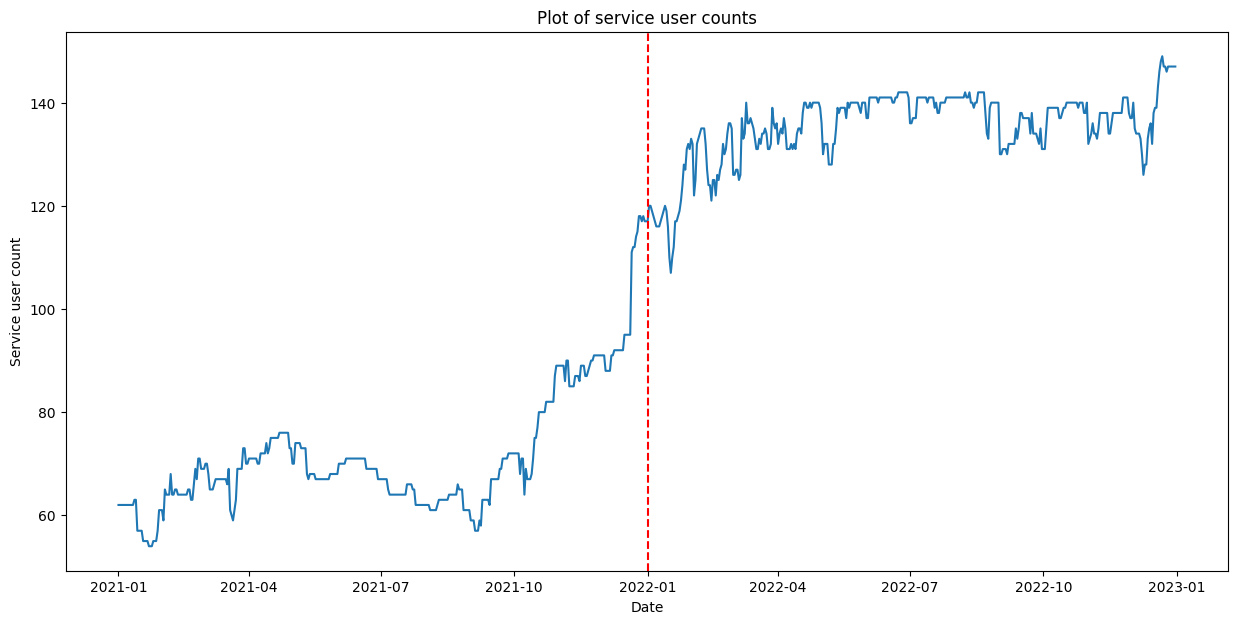

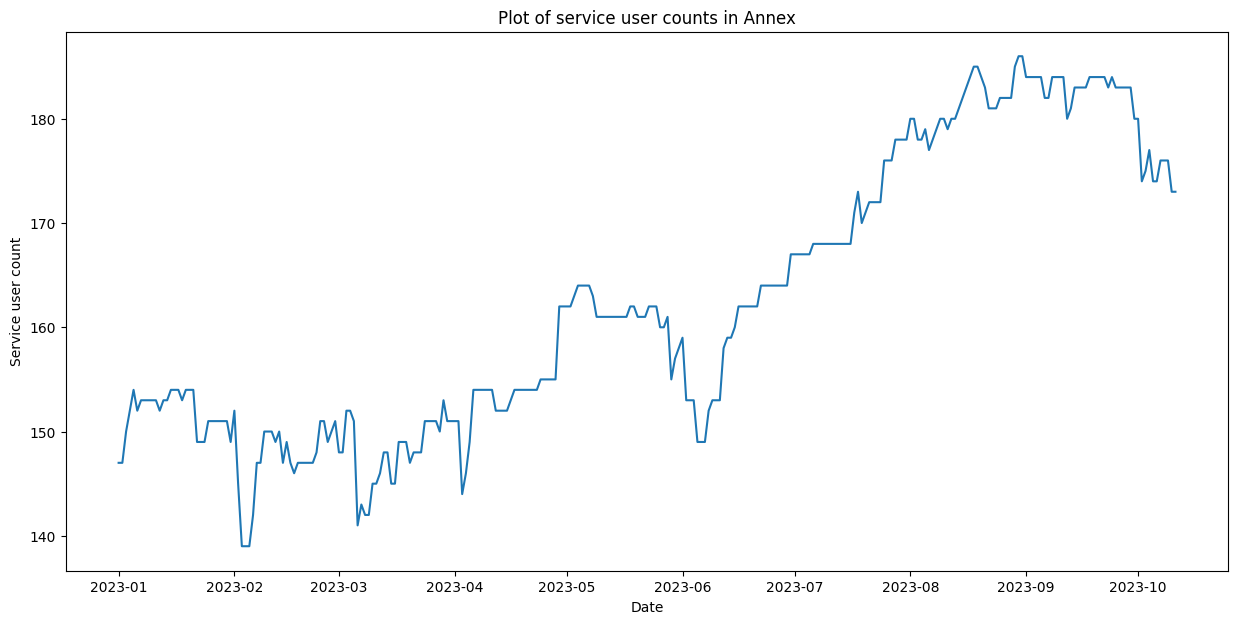

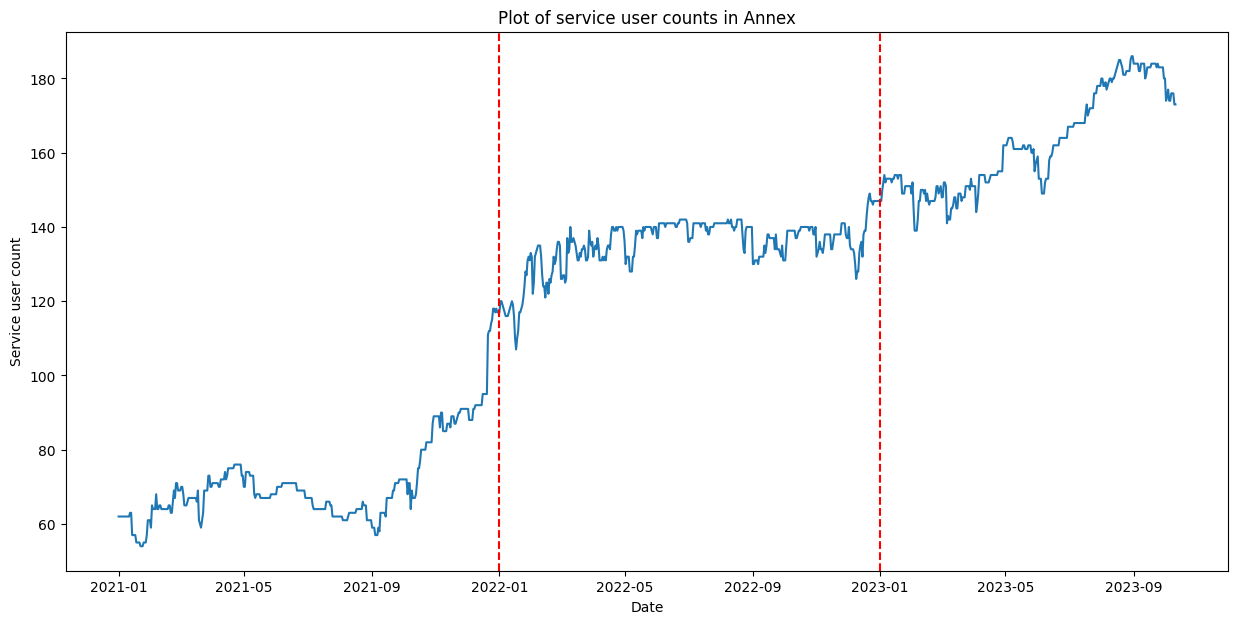

In [41]:
# plot for Annex 
# plot train 
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(train_Annex["SERVICE_USER_COUNT"])
plt.plot()
plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
plt.show()

# plot test
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts in Annex")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(test_Annex["SERVICE_USER_COUNT"])
plt.plot()

plt.show()

# plot all  
plt.figure(figsize=(15,7))
plt.title("Plot of service user counts in Annex")
plt.xlabel('Date')
plt.ylabel('Service user count')
plt.plot(data_Annex["SERVICE_USER_COUNT"])
plt.plot()
plt.axvline(x=pd.to_datetime("2022-01-01"), color="red", linestyle="--")
plt.axvline(x=pd.to_datetime("2023-01-01"), color="red", linestyle="--")
plt.show()

In [42]:
# perform the Dickey Fuller Test
import statsmodels.api as stats

result = stats.tsa.adfuller(train_Annex[['SERVICE_USER_COUNT']])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -0.7587962378434954
p-value: 0.8309268485478227
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}


In [ ]:
#adding exogenous variable

# SARIMAX Model
SARIMAX_model = pm.auto_arima(train_Annex[['SERVICE_USER_COUNT']], 
                            #   exogenous=data_Annex.iloc[:, 2:],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, 
                           max_q=3, 
                           m=365,
                           seasonal_test=True,
                           seasonal=True,
                           # d=None, 
                           start_P = 1,
                           max_P = 3,
                           D=1,
                           error_action='ignore',  
                           suppress_warnings=False, 
                           stepwise=True,
                           n_jobs= -1,
                           stationary= True,
                           trace=True,
                           scoring='mse')

In [ ]:
# Forecast
df = train_Annex
all = data_Annex
n_periods = 365

# get inices for new dataframe
forecast_df = pd.DataFrame({"month_index":pd.date_range(df.index[-1], periods = n_periods, freq='D').day},
                index = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

# get predictions and confidence intervals
fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                        return_conf_int=True,
                                        exogenous=forecast_df.iloc[:, 2:]
                                        )
index_of_fc = pd.date_range(df.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,7))
plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                lower_series, 
                upper_series, 
                color='k', alpha=.15)

plt.title("SARIMAX - Forecast of Service Users")
plt.show()

In [ ]:
# show the predictions
def sarimax_forecast(SARIMAX_model, train, all , periods=365):
    # Forecast
    train = train
    all = all
    n_periods = periods

    # get inices for new dataframe
    forecast_df = pd.DataFrame({"month_index":pd.date_range(train.index[-1], periods = n_periods, freq='D').month},
                    index = pd.date_range(train.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D'))

    # get predictions and confidence intervals
    fitted, confint = SARIMAX_model.predict(n_periods=n_periods, 
                                            return_conf_int=True,
                                            exogenous=forecast_df.iloc[:, 2:])
    index_of_fc = pd.date_range(train.index[-1] + pd.DateOffset(days=1), periods = n_periods, freq='D')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(all['SERVICE_USER_COUNT'], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Service Users")
    plt.show()